In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.linalg as spla
import numpy.linalg as npla
import seaborn as sns
from itertools import groupby
from matplotlib.colors import LogNorm
import csv

In [297]:
from model_pvp import model_pvp
from generate_distribution import generate_distribution
from make_prob_matrix import make_prob_matrix
from get_fundamental_matrix import get_fundamental_matrix
from get_mean_time import get_mean_time
from get_border_cases import get_border_cases

In [298]:
from digitalize_states import digitalize_states
import get_games_strategy

In [299]:
N = 16

counts_pvp = np.load('../data/qr_counts_pvp.npy')
counts_pvp_400 = np.load('../data/qr_counts_pvp_400.npy')
counts_pve_border = np.load('../data/qr_counts_pve_border.npy')
counts_pve_center = np.load('../data/qr_counts_pve_center.npy')

qr_pve_border = np.load('../data/qr_pve_border.npy')
qr_pve_center = np.load('../data/qr_pve_center.npy')
qr_pvp = np.load('../data/qr_pvp.npy')
qr_pvp_400 = np.load('../data/qr_pvp_400.npy')

# PvE Center
strategy_pve_center = np.load('../data/strategy_pve_center.npy')

# PvE Border
strategy_pve_border = np.load('../data/strategy_pve_border.npy')

# Random
strategy_random = np.ones ((N + 1, N + 1), dtype=np.float64) * 0.5

# PvP Border
strategy_pvp_border = np.load('../data/strategy_pvp_border.npy')

# PvP Center
strategy_pvp_center = np.load('../data/strategy_pvp_center.npy')

# PvP 400+ Border
strategy_pvp_400_border = np.load('../data/strategy_pvp_400_border.npy')

# PvP 400+ Center
strategy_pvp_400_center = np.load('../data/strategy_pvp_400_center.npy')

# PvE Border Optimal
strategy_pve_border_optimal = np.zeros ((N + 1, N + 1), dtype=np.float64)
qr_pve_border_optimal, probabilities = make_prob_matrix(N, strategy_random, strategy_pve_border_optimal)

# PvE Border Optimal All Horizontal
strategy_pve_border_optimal_all_horizontal = np.ones((N + 1, N + 1), dtype=np.float64) * 0.5
qr_pve_border_optimal_all_horizontal, probabilities = make_prob_matrix(N, strategy_random, \
                                                                       strategy_pve_border_optimal_all_horizontal)

# PvE Center Optimal
strategy_pve_center_optimal = np.zeros((N + 1, N + 1), dtype=np.float64)
strategy_pve_center_optimal = \
    np.diag(np.ones(N + 1) * 0.5) + \
    np.diag(np.ones(N), -1) + \
    np.diag(np.zeros(N), +1)
strategy_pve_center_optimal = strategy_pve_center_optimal.T
qr_pve_center_optimal, probabilities = make_prob_matrix(N, strategy_pve_center_optimal, strategy_random)

# PvE Center Optimal 2d 
strategy_pve_center_optimal_2d = np.zeros((N + 1, N + 1), dtype=np.float64)
strategy_pve_center_optimal_2d[1:N, 1] = 1
strategy_pve_center_optimal_2d[N - 1, 1:N] = 1
strategy_pve_center_optimal_2d = strategy_pve_center_optimal_2d.T
qr_pve_center_optimal_2d, probabilities = make_prob_matrix(N, strategy_pve_center_optimal_2d, strategy_random)


# PvE Center Optimal 2d All Horizontal
strategy_pve_center_optimal_2d_all_horizontal = np.ones((N + 1, N + 1), dtype=np.float64) * 0.5
strategy_pve_center_optimal_2d_all_horizontal[1:N, 1] = 1
strategy_pve_center_optimal_2d_all_horizontal[N - 1, 1:N] = 1
strategy_pve_center_optimal_2d_all_horizontal = strategy_pve_center_optimal_2d_all_horizontal.T
qr_pve_center_optimal_2d_all_horizontal, probabilities = make_prob_matrix(N, \
                                    strategy_pve_center_optimal_2d_all_horizontal, strategy_random)

# BvB
qr_bvb, probabilities = make_prob_matrix(N, strategy_random, strategy_random)

qr_pve_border_pure, probabilities = make_prob_matrix(N, strategy_random, strategy_pve_border)
qr_pve_center_pure, probabilities = make_prob_matrix(N, strategy_pve_center, strategy_random)
qr_pvp_pure, probabilities = make_prob_matrix(N, strategy_pvp_center, strategy_pvp_border)
qr_pvp_400_pure, probabilities = make_prob_matrix(N, strategy_pvp_400_center, strategy_pvp_400_border)

In [300]:
def qr_to_probabilities(qr, N):
    frequencies = qr.copy()
    border = get_border_cases(N)
    for i in np.arange(len(border)-1, -1, step = -1):
        frequencies = np.delete(frequencies, border[i], axis = 0)
        frequencies = np.delete(frequencies, border[i], axis = 1)
    return frequencies

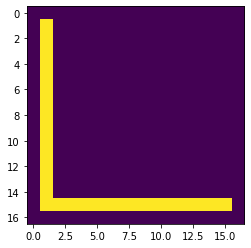

In [301]:
plt.imshow(strategy_pve_center_optimal_2d.T)

In [302]:
x, y = 8, 9
qr_pve_center_optimal[(N+1) * x + y, (N+1) * (x - 0) + (y + 1)]

0.0

In [303]:
qrs = {
    'pve_border': qr_pve_border,
    'pve_center': qr_pve_center,
    'bvb': qr_bvb,
    'pve_border_pure': qr_pve_border_pure,
    'pve_center_pure': qr_pve_center_pure,
    'pvp': qr_pvp,
    'pvp_pure': qr_pvp_pure,
    'pvp_400': qr_pvp_400,
    'pvp_400_pure': qr_pvp_400_pure,
    'pve_border_optimal': qr_pve_border_optimal,
    'pve_center_optimal': qr_pve_center_optimal,
    'pve_center_optimal_2d': qr_pve_center_optimal_2d,
    #'pve_border_optimal_all_horizontal': qr_pve_border_optimal_all_horizontal,
    #'pve_center_optimal_2d_all_horizontal': qr_pve_center_optimal_2d_all_horizontal,
}

In [304]:
def remove_absorption_states(qr, N):
    new_matrix = qr.copy()
    border_states = get_border_cases(N)
    
    new_matrix = np.delete(new_matrix, border_states, axis=0)
    new_matrix = np.delete(new_matrix, border_states, axis=1)
    
    return new_matrix

In [305]:
def get_max_eigenvectors_h(qr):
    e_values, e_vec_r = npla.eigh(qr) 
    
    max_ev_index = np.where(np.isclose(abs(e_values), abs(max(e_values, key=abs))))[0][0]
    
    max_right_vec = e_vec_r[:, max_ev_index]
    
    return e_values, e_vec_r, max_right_vec, max_ev_index

In [306]:
def get_max_eigenvectors(qr, index_max=0, index_min=-1):
    e_values, e_vec_l, e_vec_r = spla.eig(qr, left=True, right=True) 
    
    # Make eigenvalues real
    e_values = np.real(e_values)
    
    # Make an array of indices for eigenvalues
    indices = range(0, len(e_values))  
    
    # Sort eigenvalues array from Max to Min
    e_values, indices = zip(*sorted(zip(e_values, indices), reverse=True))
    indices = list(indices)
    
    
    # Get unique eigenvalues and their multiplicity. Array is sorted from Min to Max
    unique_e_vals, counts = np.unique(e_values, return_counts=True)
    
    # Reverse counts to match e_values order
    counts = counts[::-1]
    
    # We need to get all vectors corresponding to Max eigenvalue
    # Max eigenvalue has index of indices[0]. There are counts[0] of vectors
    # corresponing to that eigenvalue. 
    # Supposedly, these vectors are first in indices[0 : counts[0]] places for positive eigenvalue.
    # For negative value, it's indicies[-counts[-1] : ]
    left_vectors_for_max_positive_evalue = e_vec_l[:, indices[0 : counts[0]]]
    left_vectors_for_max_positive_evalue = np.reshape(left_vectors_for_max_positive_evalue, newshape=(counts[0], 15*15))
    
    right_vectors_for_max_positive_evalue = e_vec_r[:, indices[0 : counts[0]]]
    right_vectors_for_max_positive_evalue = np.reshape(right_vectors_for_max_positive_evalue, newshape=(counts[0], 15*15))
    
    left_vectors_for_min_negative_evalue = e_vec_l[:, indices[-counts[-1] : ]]
    left_vectors_for_min_negative_evalue = np.reshape(left_vectors_for_min_negative_evalue, newshape=(counts[-1], 15*15))
    
    right_vectors_for_min_negative_evalue = e_vec_r[:, indices[-counts[-1] : ]]
    right_vectors_for_min_negative_evalue = np.reshape(right_vectors_for_min_negative_evalue, newshape=(counts[-1], 15*15))
    
    
    max_left_vec_positive = get_nonzero_vector(left_vectors_for_max_positive_evalue)
    max_right_vec_positive = get_nonzero_vector(right_vectors_for_max_positive_evalue)
    
    max_left_vec_negative = get_nonzero_vector(left_vectors_for_min_negative_evalue)
    max_right_vec_negative = get_nonzero_vector(right_vectors_for_min_negative_evalue)
    
    return e_values, unique_e_vals, e_vec_l, e_vec_r, max_left_vec_positive, max_right_vec_positive, \
            max_left_vec_negative, max_right_vec_negative

In [320]:
'''
Returns a vector, which has a non-zero value in center of grid.
'''
def get_nonzero_vector(vectors, N=16):
    for v in vectors:
        if (v[7 * 15 + 7] != 0):
            return v
        else:
            return None

In [321]:
def visualise_eigenvalues(e_values, case):
    plt.clf()
    unique_e_vals, counts = np.unique(e_values, return_counts=True)
    
    fig, ax = plt.subplots(1, figsize=(16,9), dpi=300)
        
    xs_for_axis = unique_e_vals
    ys_for_axis = np.zeros(shape=(len(xs_for_axis)))
        
    ax.set_title("Eigenvalues")
    ax.set_xlabel("Eigenvalue")
    ax.set_ylabel("Eigenvalue multiplicity")
    ax.plot(xs_for_axis, ys_for_axis, marker='x')
    
    for i in range(len(unique_e_vals)):
        x = unique_e_vals[i]
        y_max = counts[i]
        
        ys = np.arange(start=0, stop=y_max, step=0.01)
        xs = [x] * len(ys)
        ax.plot(xs, ys)
        
    fig.savefig("../Eigenvectors/" + case + '/' + "eigenvalues.png", transparent=False, \
                facecolor='white', edgecolor='white')
    
    return unique_e_vals, counts

In [322]:
def visualise_eigenvector(vector, N, case, lr):    
    fig, ax = plt.subplots(1)
    fig.dpi = 300 
    ax.set_title("Eigenvector " + lr)
    
    ax.set_yticks(np.arange(start=0, stop=N, step=2))
    ax.set_xticks(np.arange(start=0, stop=N, step=2))
    ax.xaxis.tick_top()
    
    grid = np.zeros(shape=(N, N))
    for i in range(N):
        for j in range(N):
            grid[i, j] = vector[i * N + j]
            
    ax.set_xlim((-0.5, N-0.5))
    ax.set_ylim((-0.5, N-0.5)) 
    t = ax.imshow(grid)
    ax.invert_yaxis()
    fig.colorbar(t)
    
    fig.savefig("../Eigenvectors/" + case + '/' + "eigenvector_" + lr + ".png", transparent=False, \
                facecolor='white', edgecolor='white')

In [323]:
def visualise_qr(qr, case):
    fig, ax = plt.subplots(1)
    fig.dpi = 300
    ax.set_title("QR matrix for " + case)
    
    ax.set_yticks(np.arange(start=0, stop=qr.shape[0], step=20))
    ax.set_xticks(np.arange(start=0, stop=qr.shape[1], step=20))
    ax.xaxis.tick_top()
    ax.invert_yaxis()
    t = ax.imshow(qr)
    
    fig.colorbar(t)
    fig.savefig("../Eigenvectors/" + case + '/' + "qr.png", transparent=False, \
                facecolor='white', edgecolor='white')

In [324]:
from pathlib import Path
def make_directory(case):
    p = Path("../Eigenvectors/" + case + '/')
    p.mkdir(parents=True, exist_ok=True)

In [327]:
import csv
def save_evalues(unique_evals, counts, case, vl_pos, vr_pos, vl_neg, vr_neg):
    
    unique_evals = np.real(unique_evals)
    
    unique_evals, counts = zip(*sorted(zip(unique_evals, counts), reverse=True))
        
    unique_evals = list(unique_evals)
    counts = list(counts)
    path = '../Eigenvectors/' + case + '/' + 'values.txt'

    
    with open(path, 'w') as out_file:
        tsv_writer = csv.writer(out_file, delimiter='\t')
        
        out_file.write('l2/l1\n')
        out_file.write(str(unique_evals[1] / unique_evals[0]))
        out_file.write('\n')
        
        
        out_file.write('lambdas\n')
        
        [out_file.write('{:.5f} '.format(x)) for x in unique_evals]
        out_file.write('\n')
        [out_file.write('{0:7d} '.format(c)) for c in counts]
        out_file.write('\n')
        
        out_file.write('max left eigenvector for positive lambda\n')
        tsv_writer.writerow(vl_pos)
        out_file.write("max right eigenvector for positive lambda\n")
        tsv_writer.writerow(vr_pos)

        out_file.write("max left eigenvector for negative lambda\n")
        tsv_writer.writerow(vl_neg)
        out_file.write("max right eigenvector for negative lambda\n")
        tsv_writer.writerow(vr_neg)

C:\Users\serge\AppData\Local\Temp/ipykernel_12744/876194704.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  grid[i, j] = vector[i * N + j]
C:\Users\serge\AppData\Local\Temp/ipykernel_12744/876194704.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  grid[i, j] = vector[i * N + j]
C:\Users\serge\AppData\Local\Temp/ipykernel_12744/876194704.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  grid[i, j] = vector[i * N + j]
C:\Users\serge\AppData\Local\Temp/ipykernel_12744/876194704.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)
C:\Users\serge\AppData\Local\Temp/ipykernel_12744/876194704.py:13: ComplexWarning: Casting complex values to rea

<Figure size 432x288 with 0 Axes>

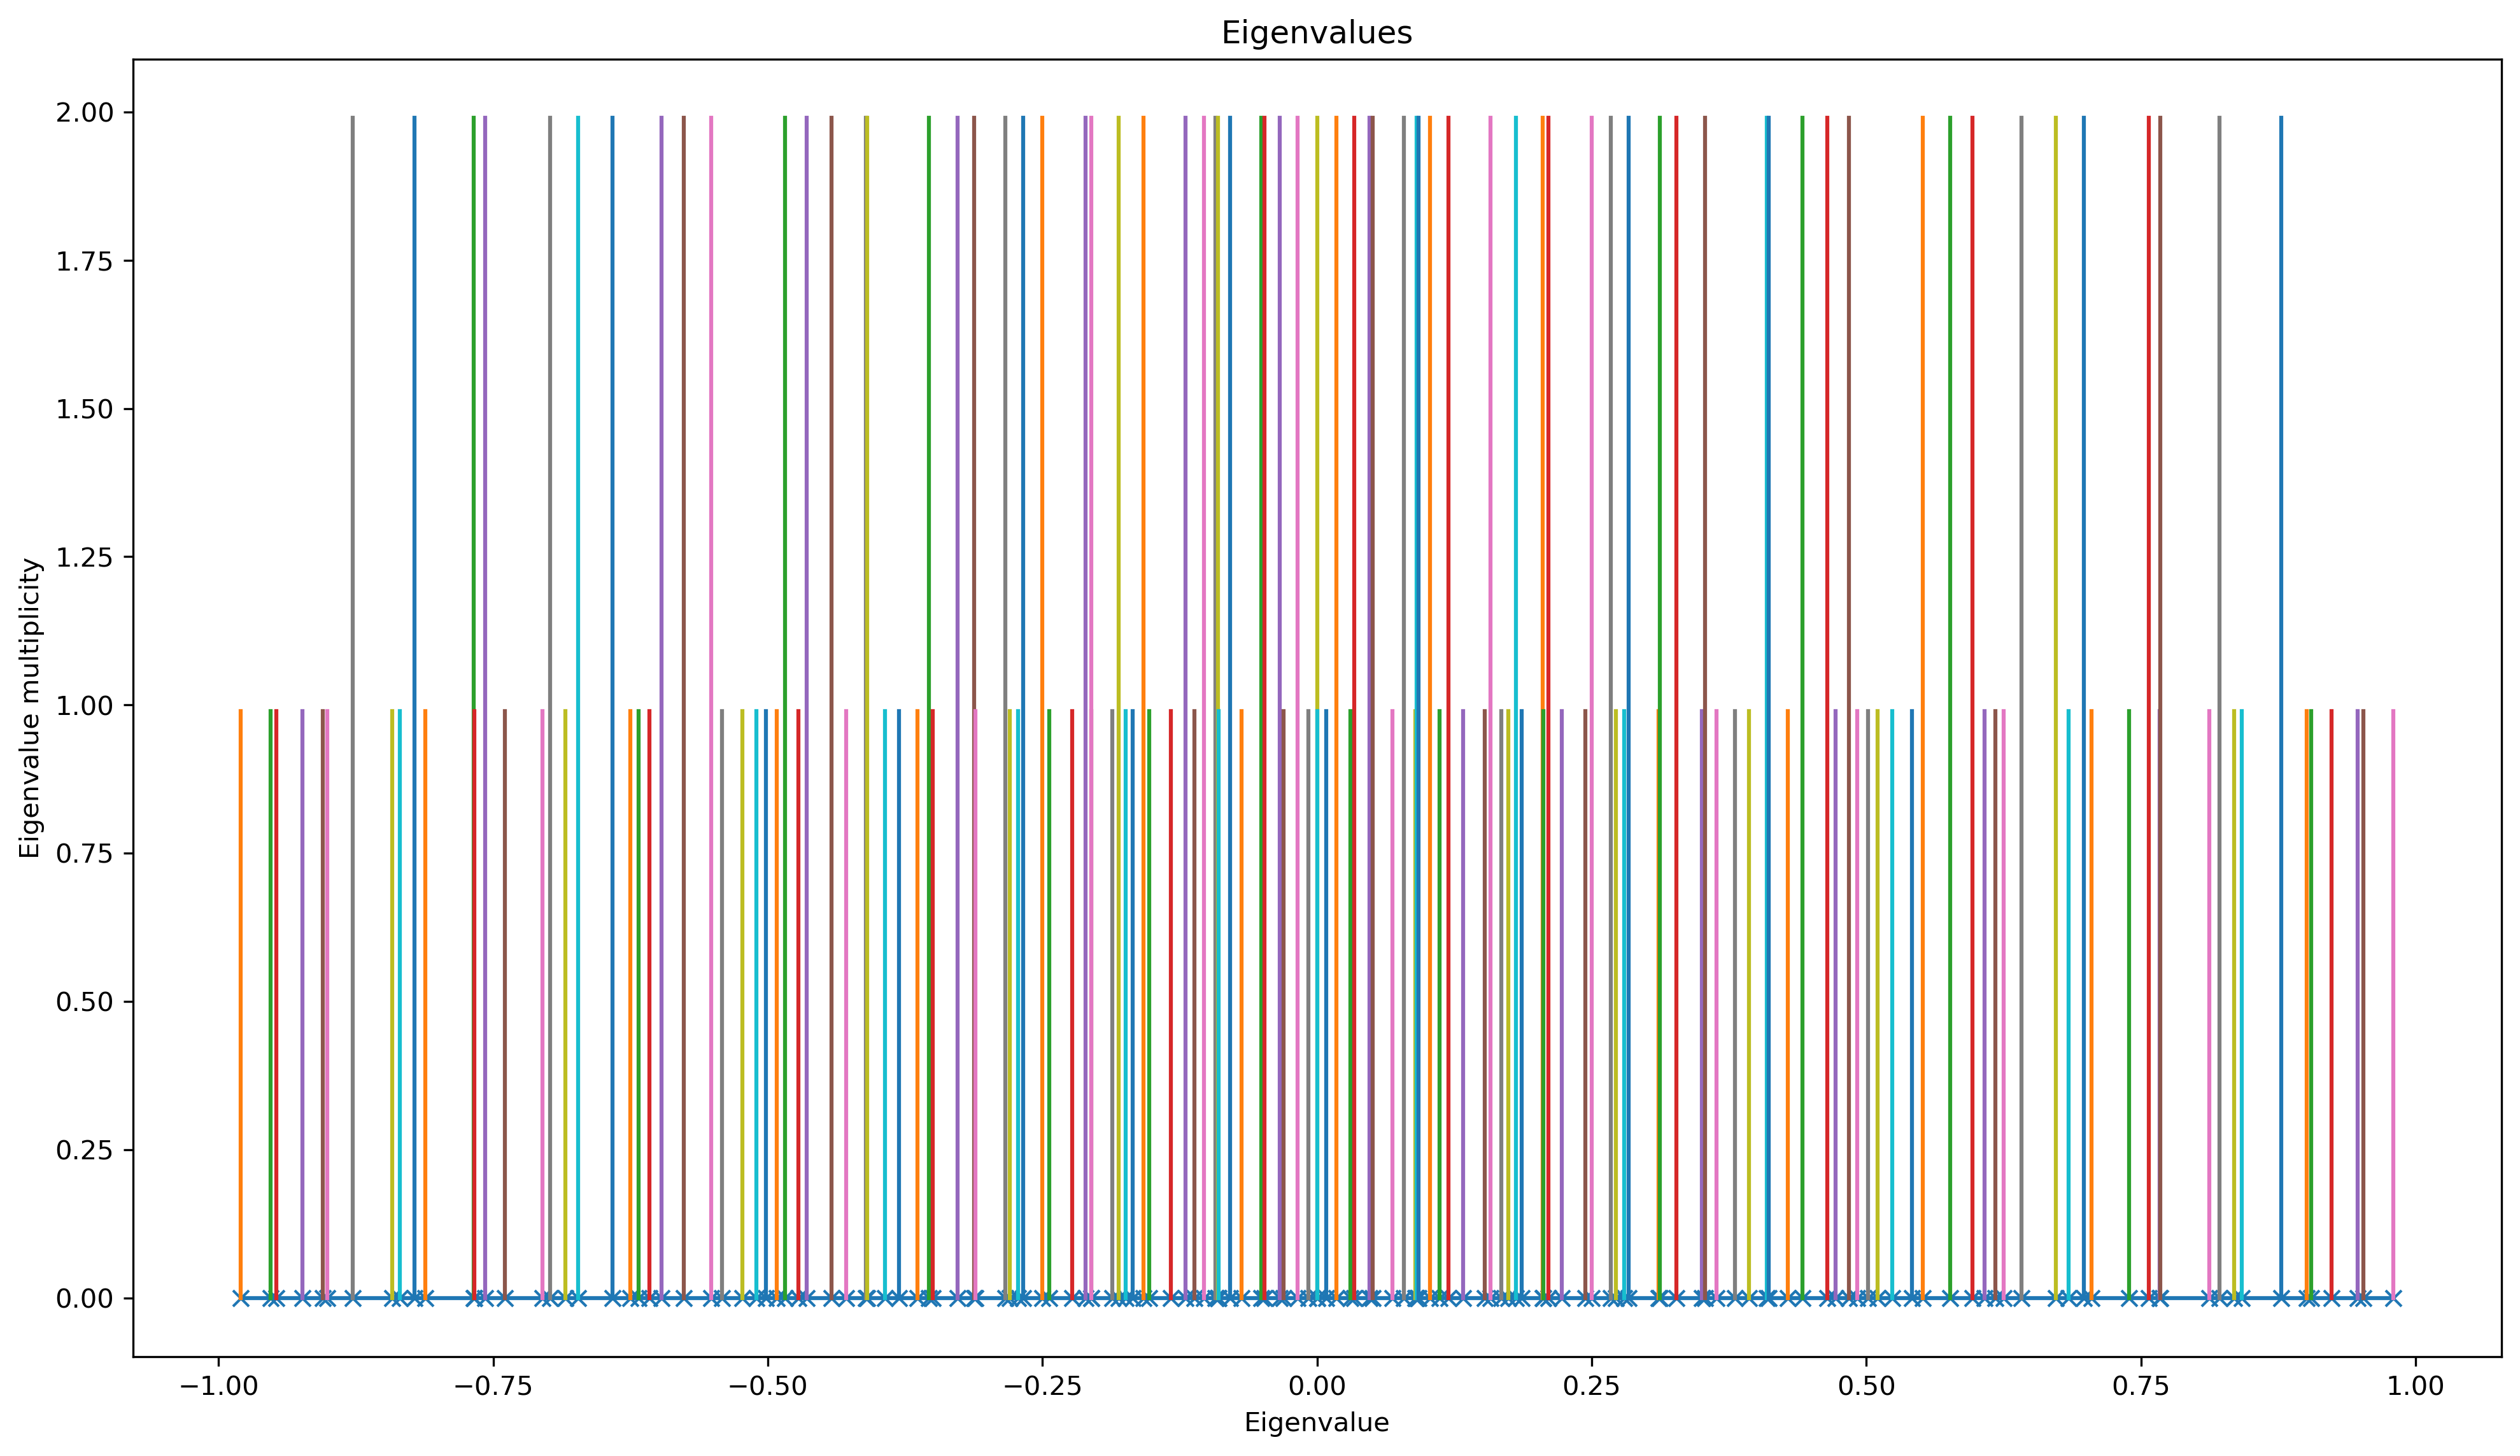

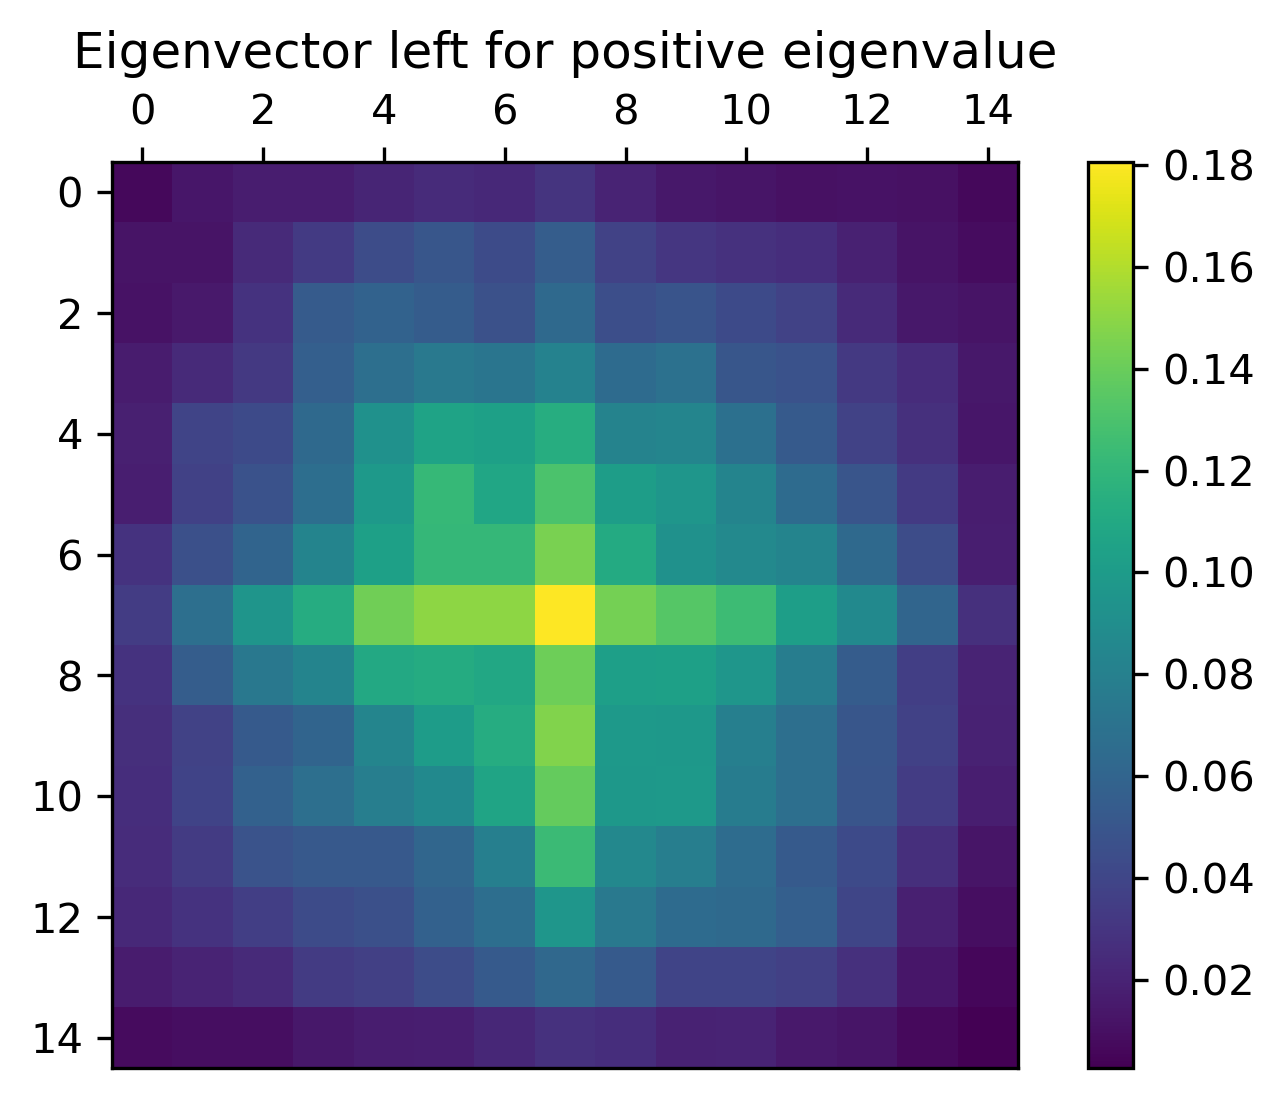

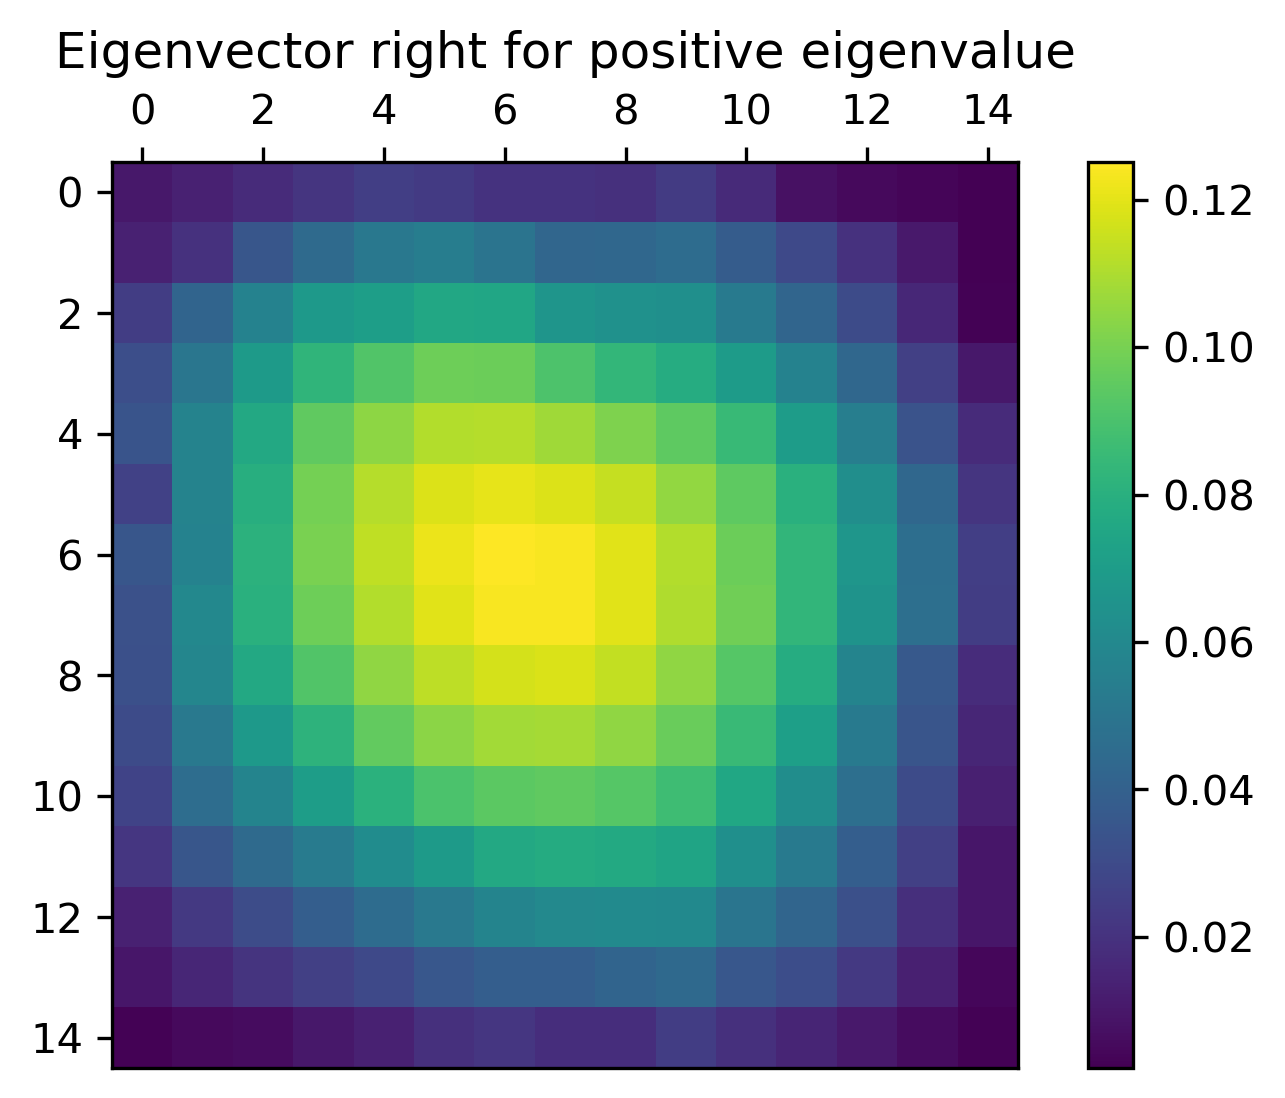

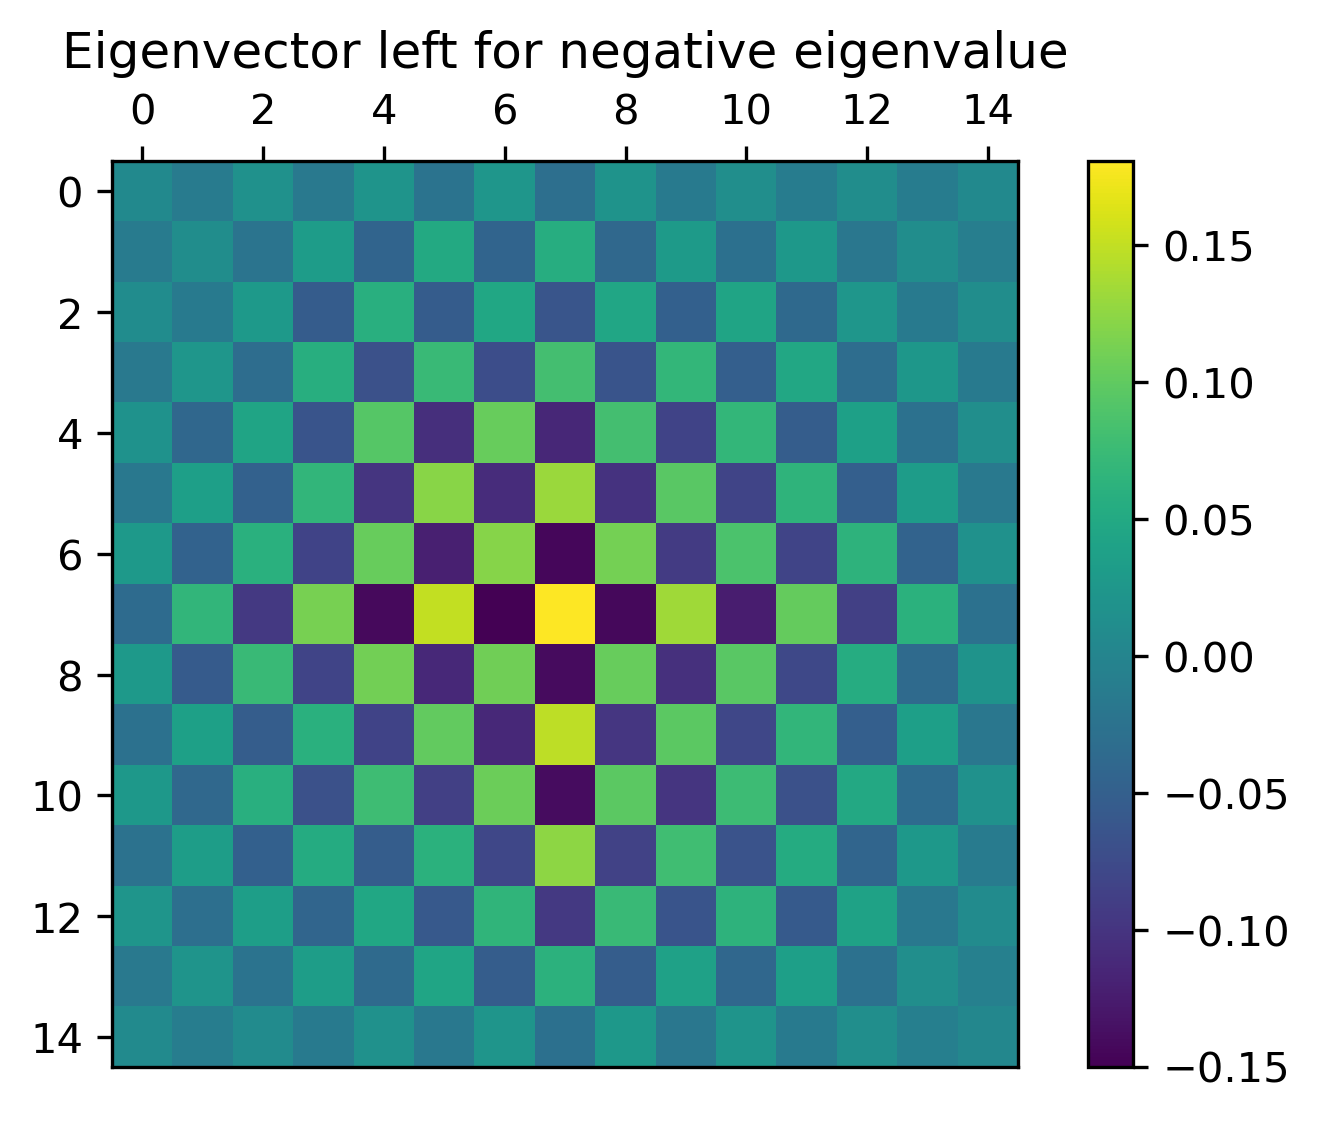

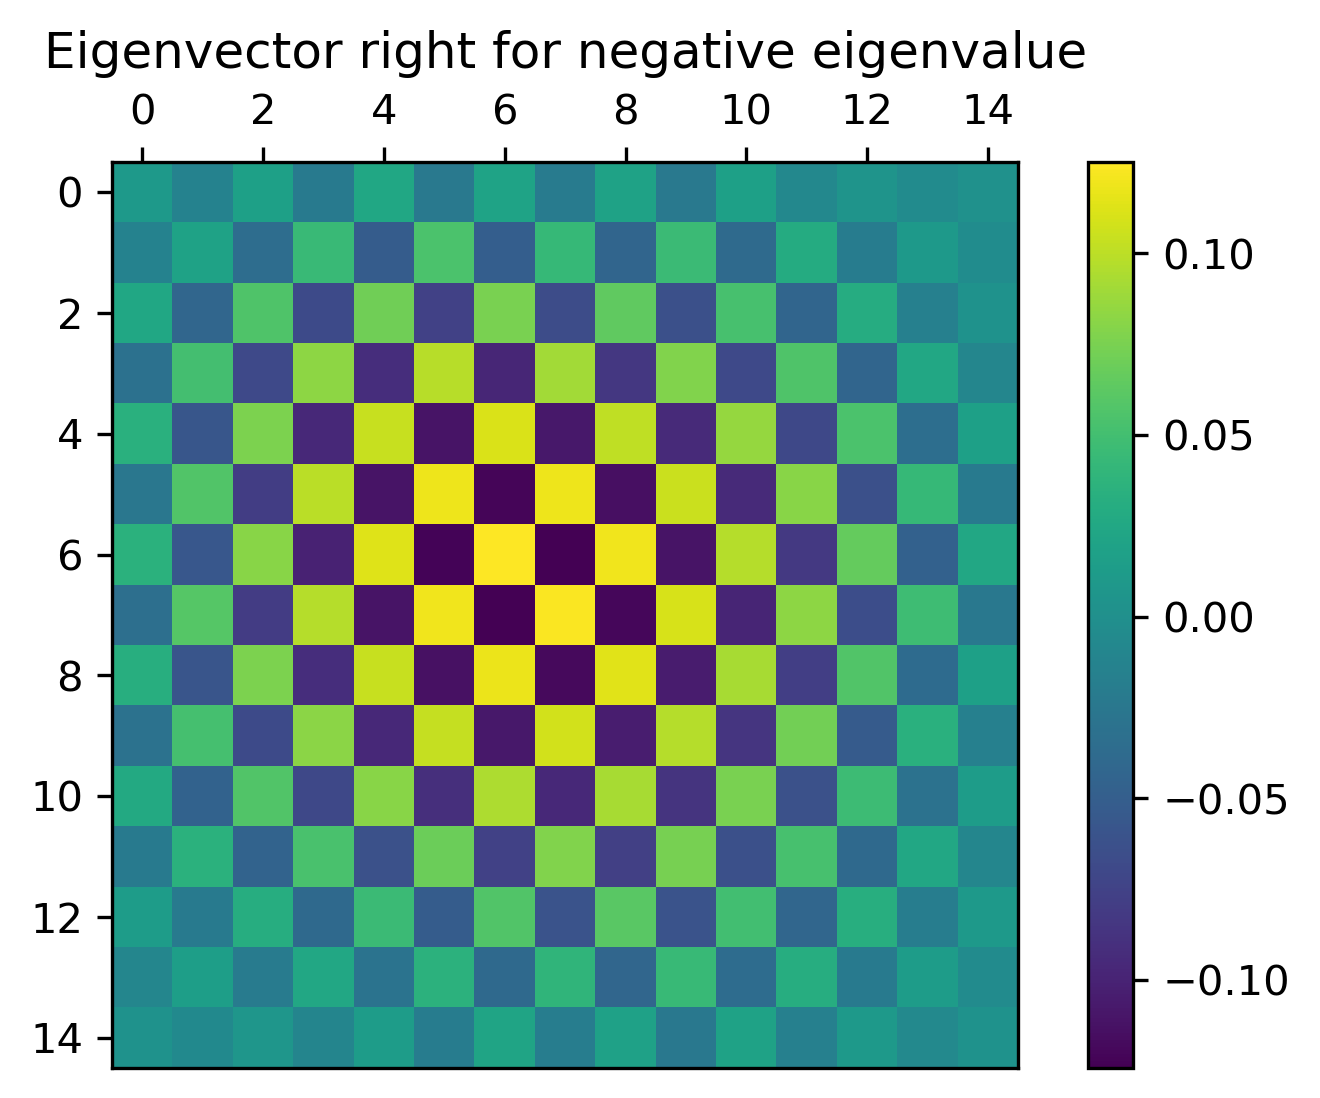

<Figure size 1800x1200 with 0 Axes>

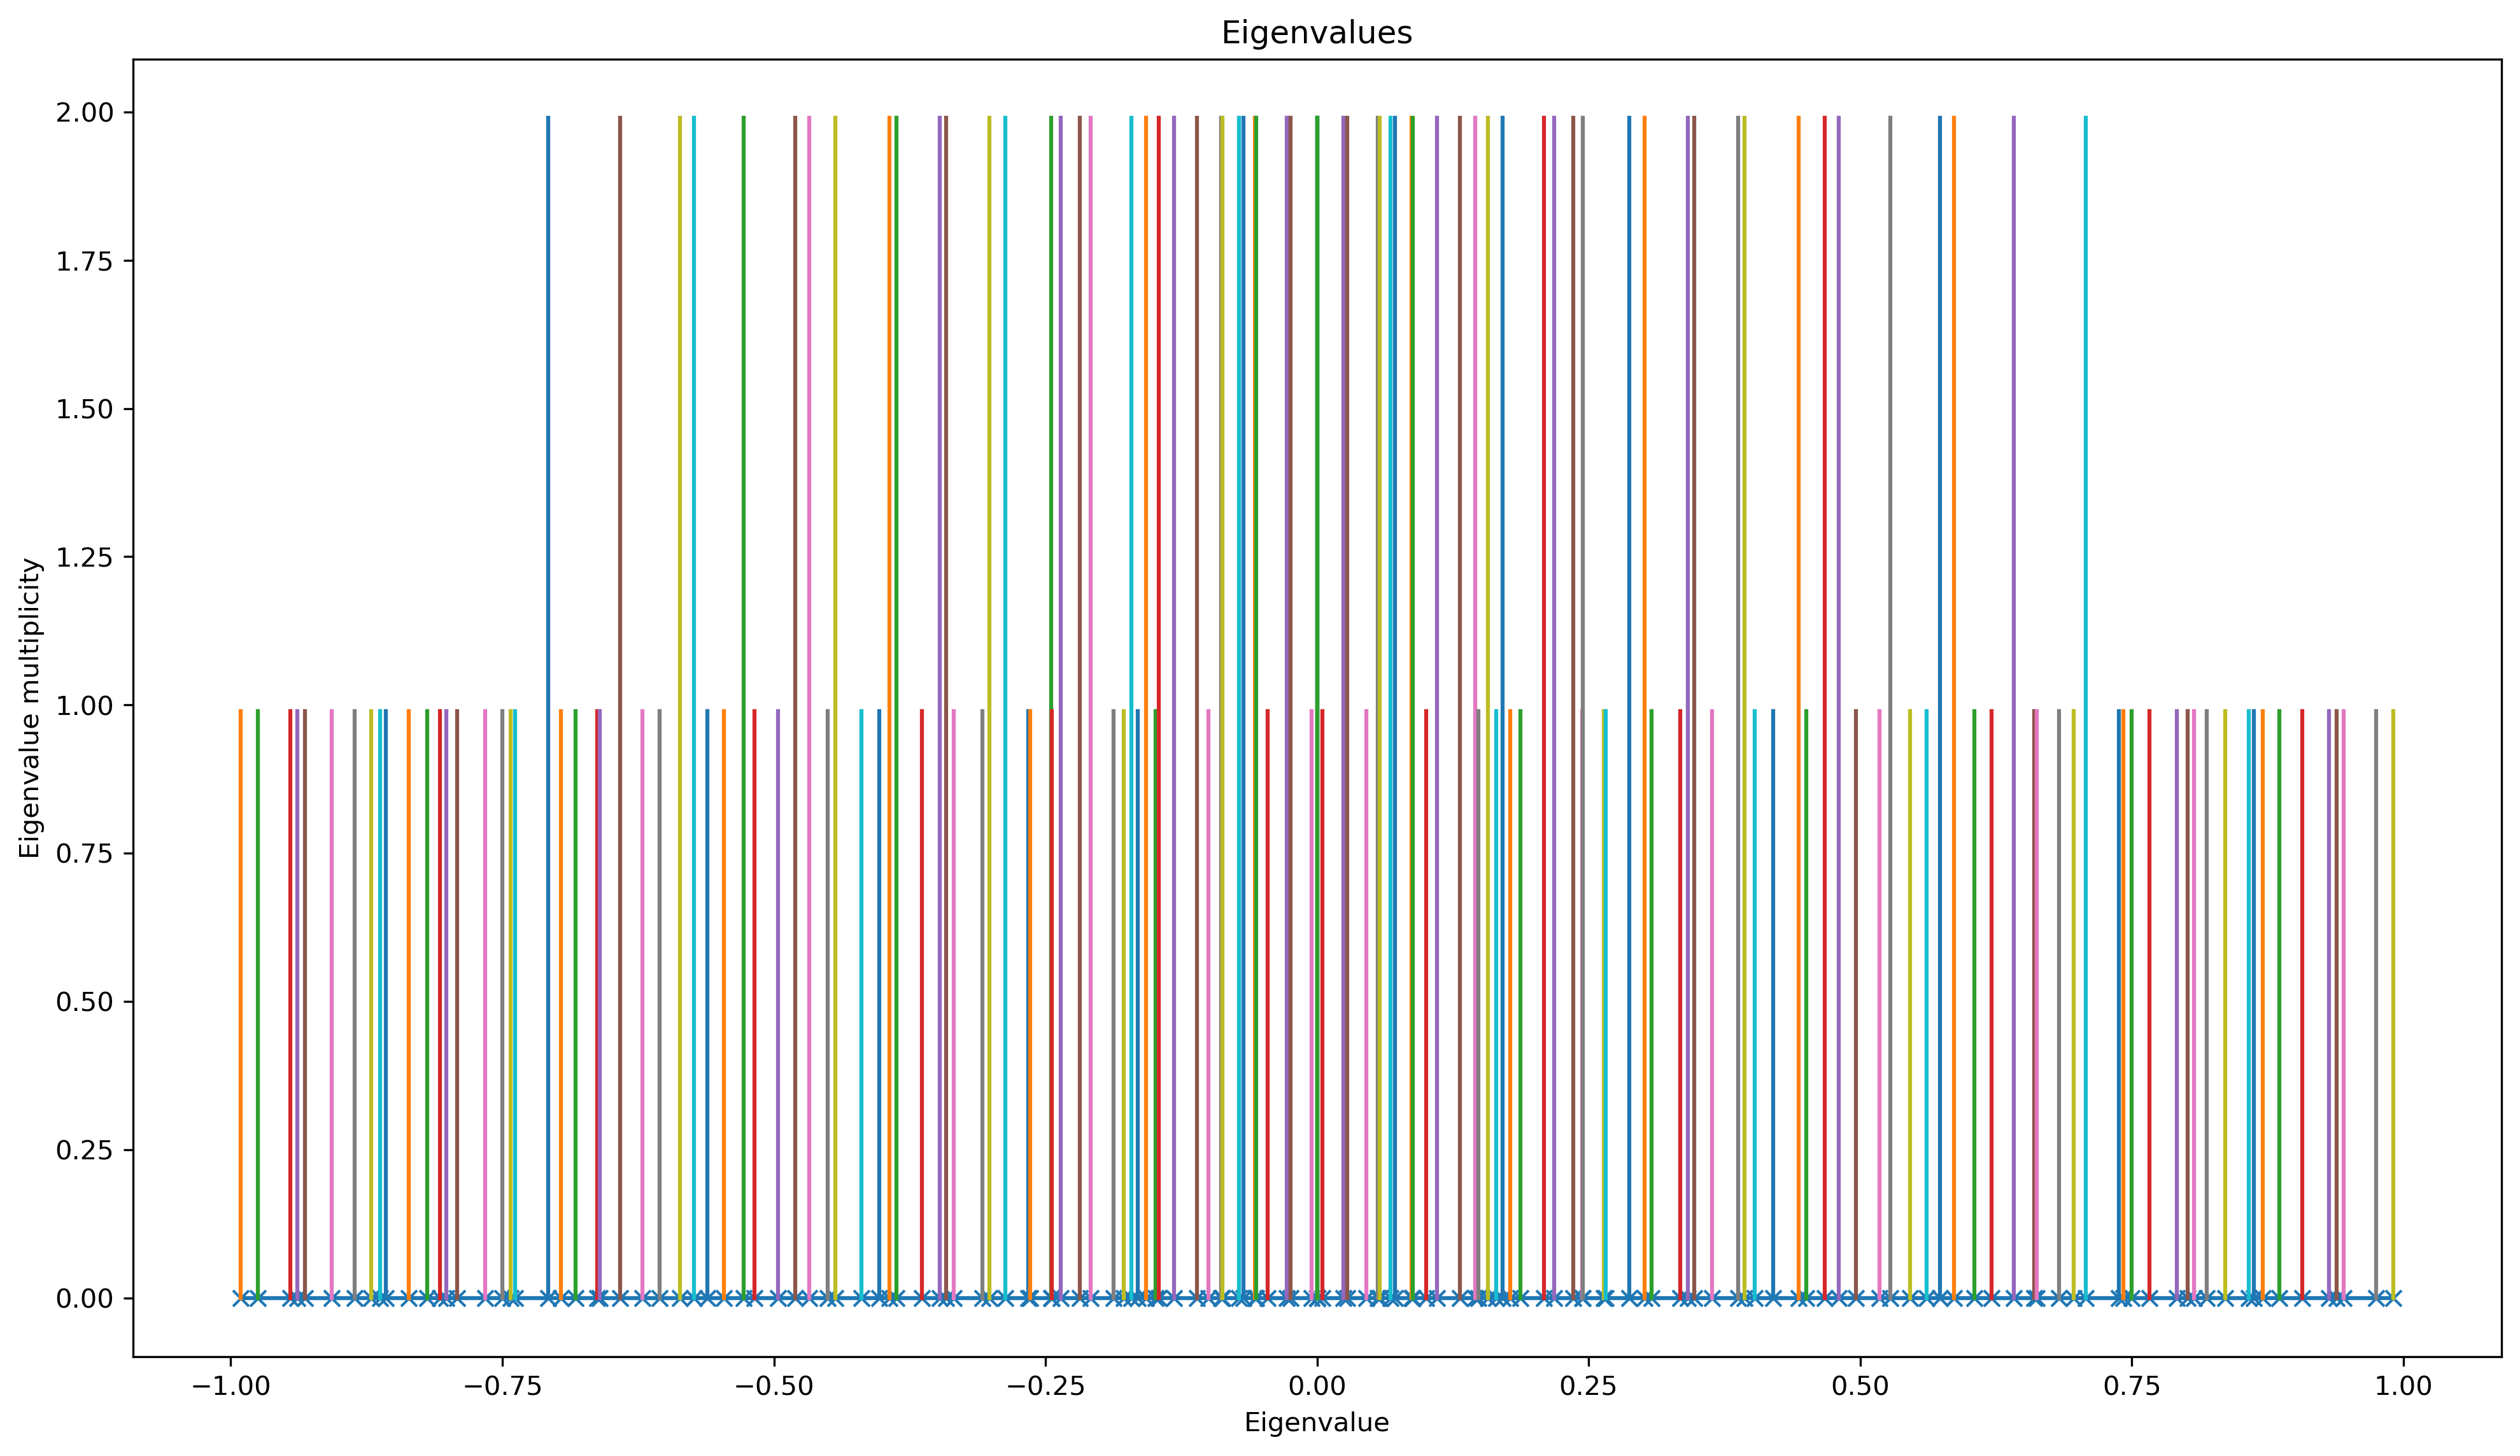

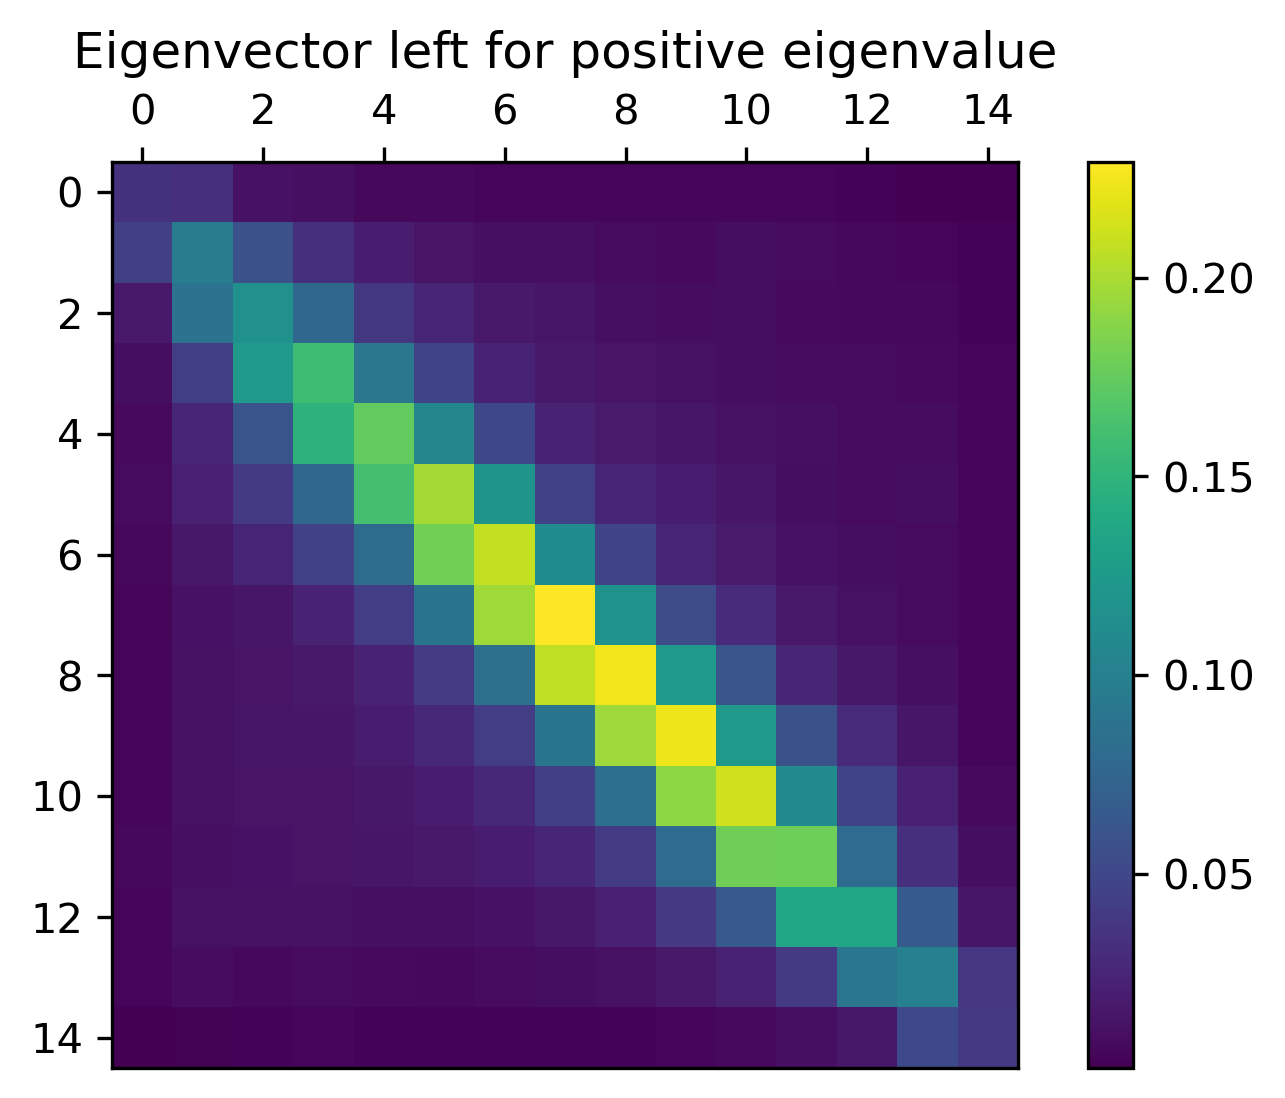

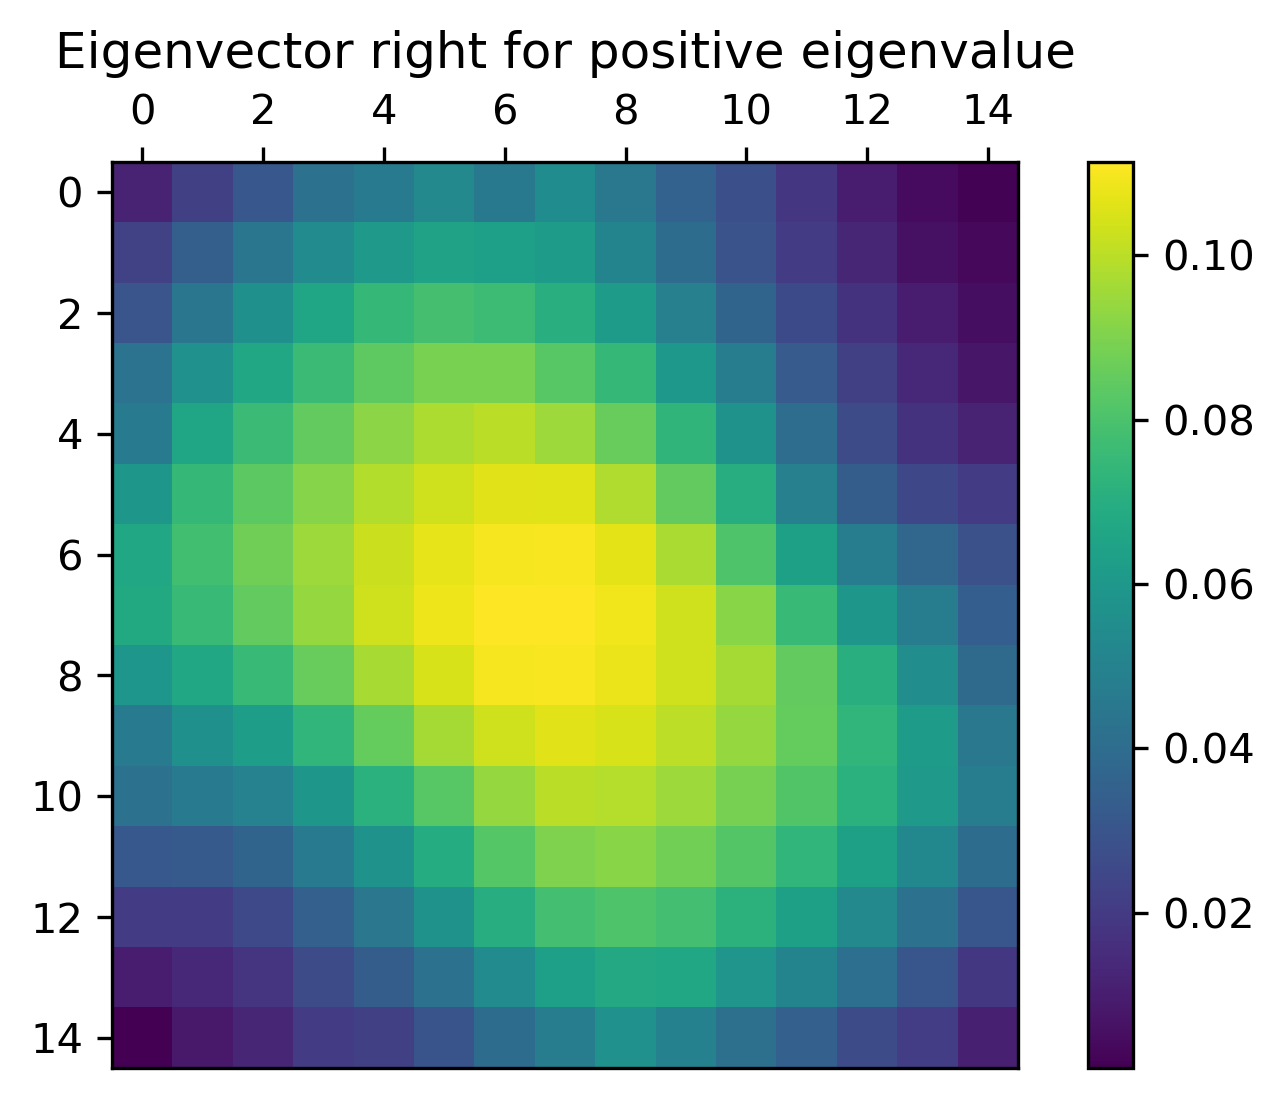

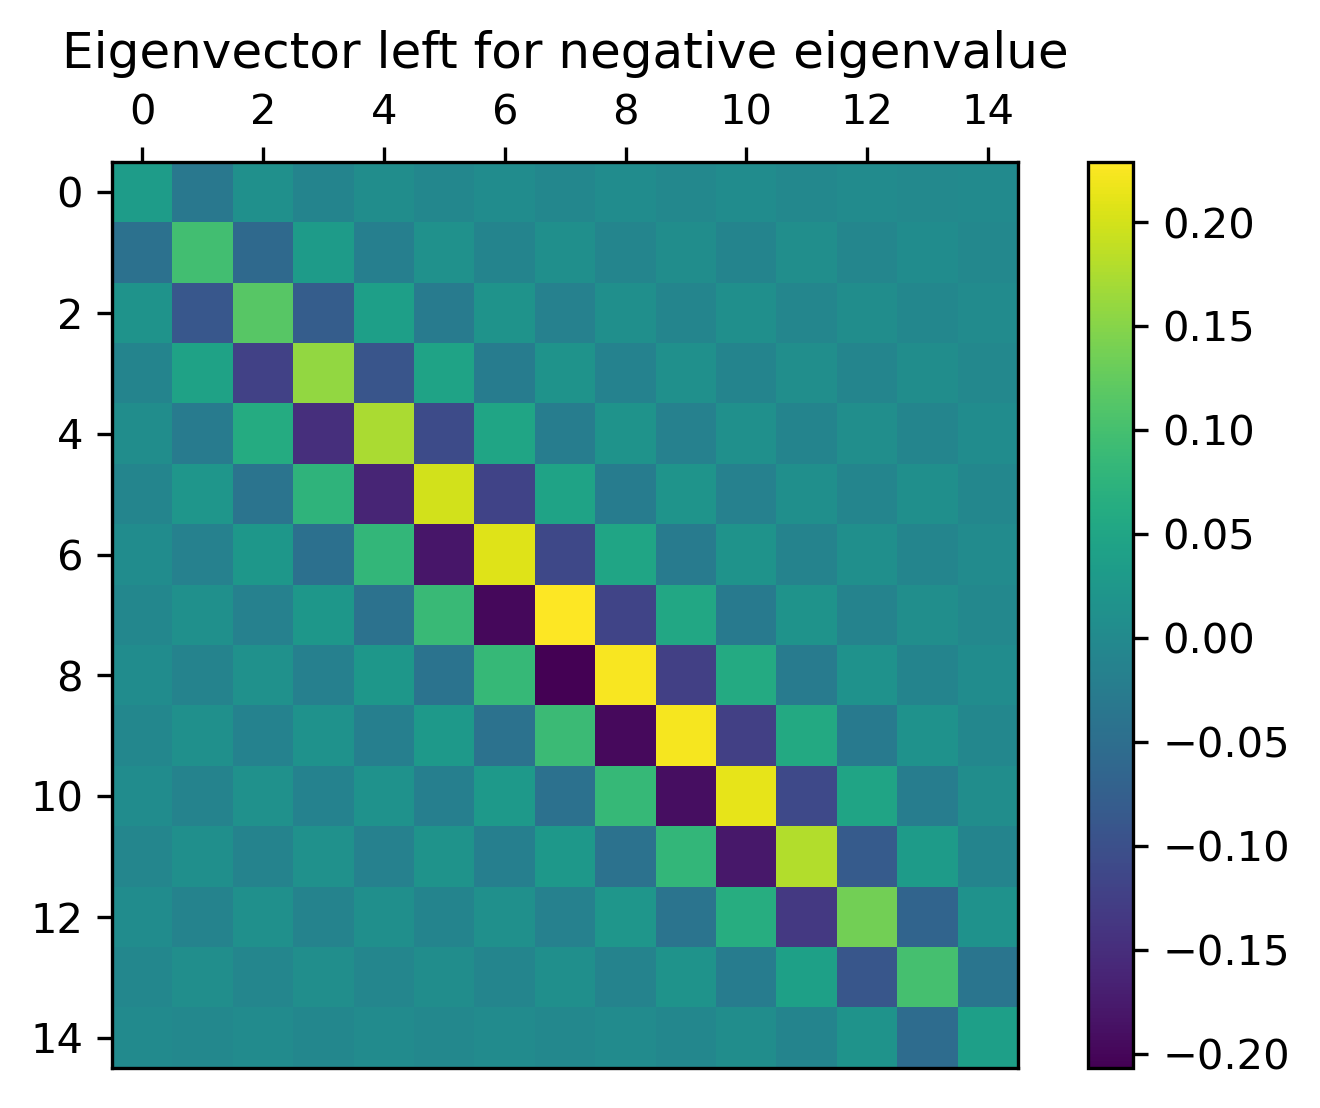

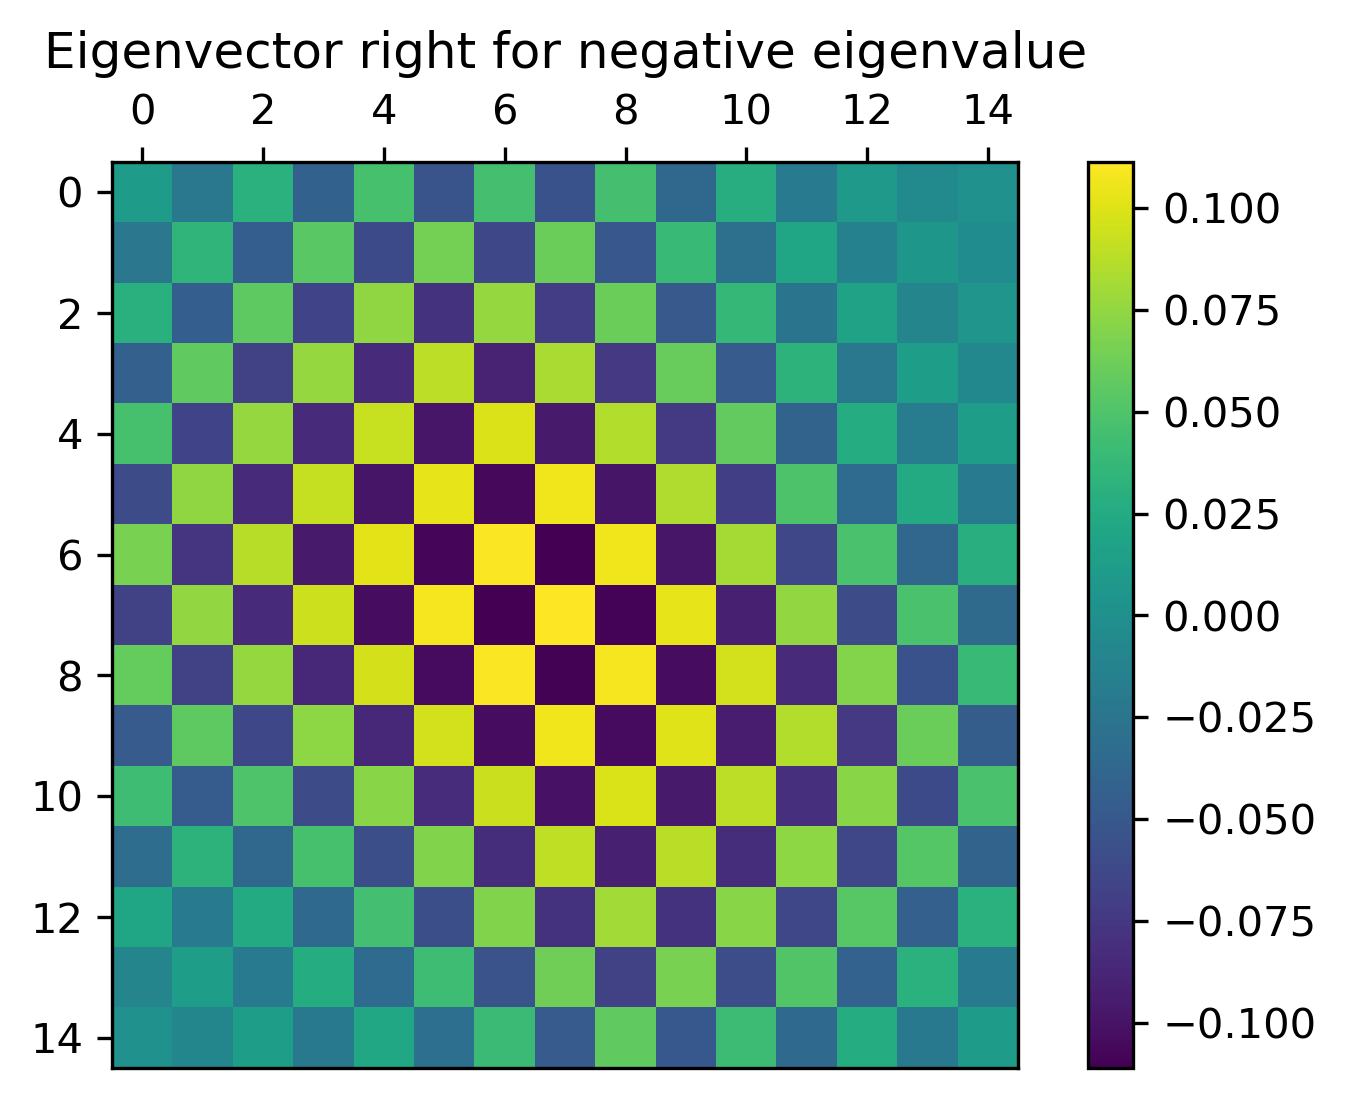

<Figure size 1800x1200 with 0 Axes>

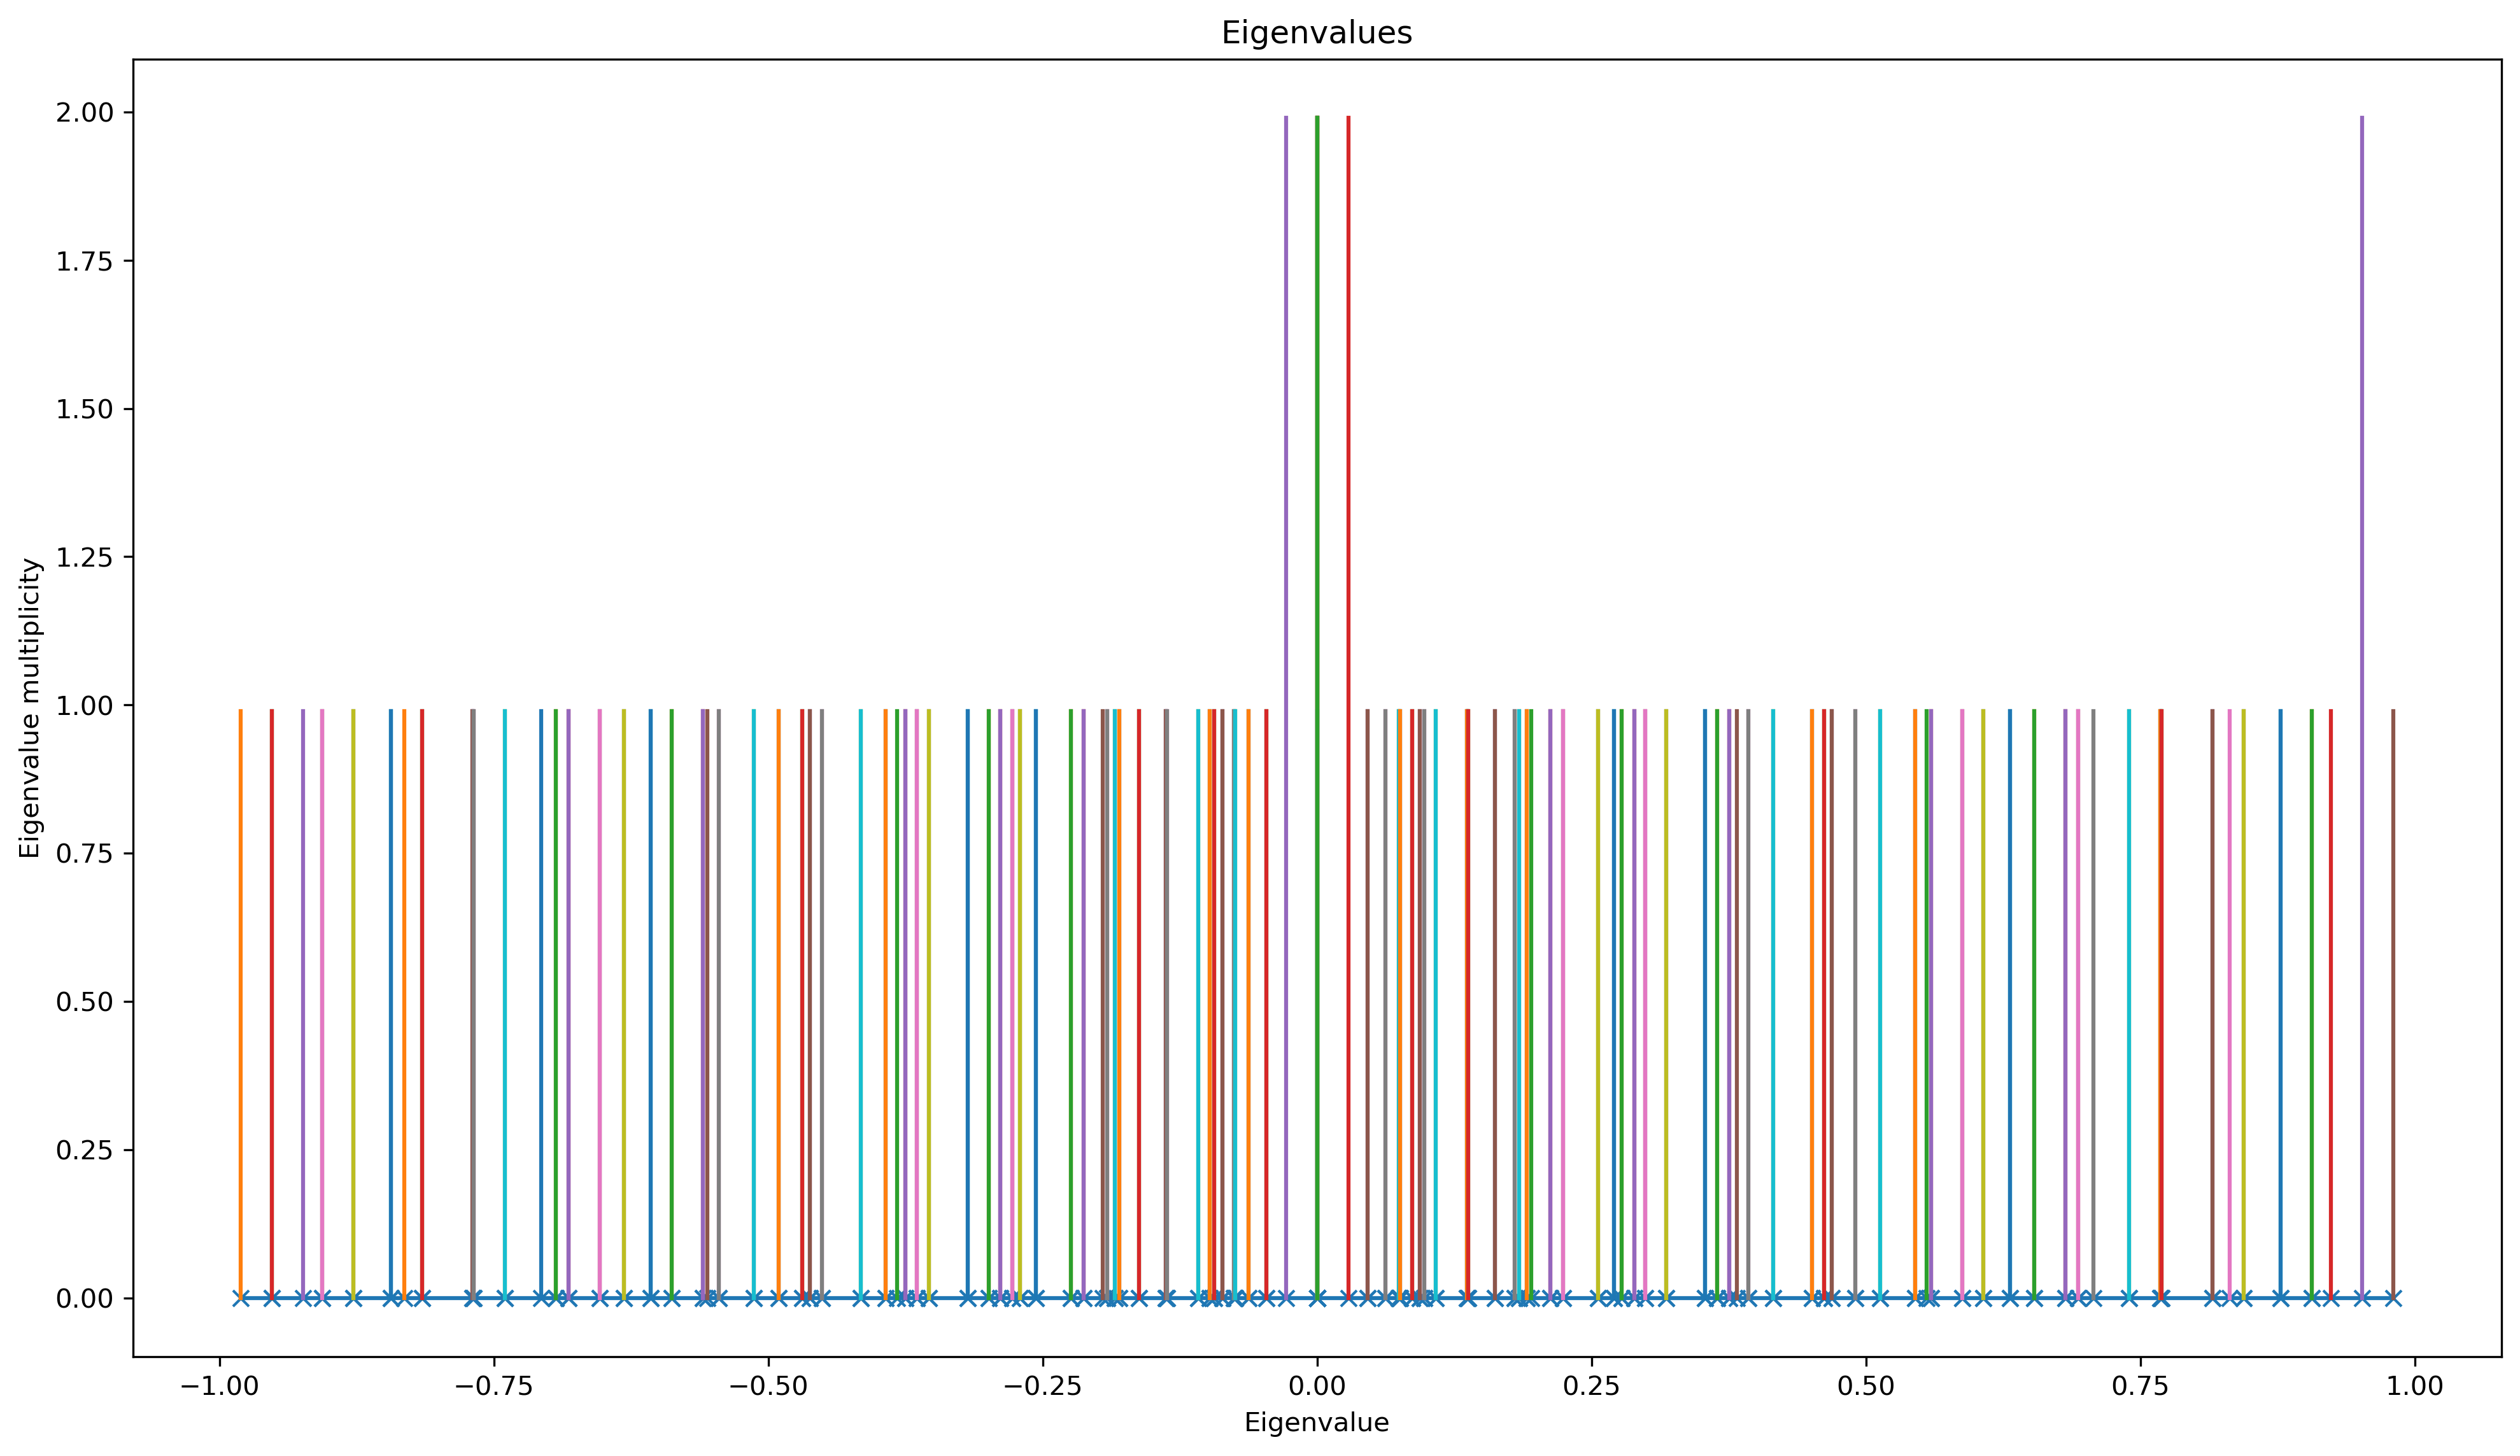

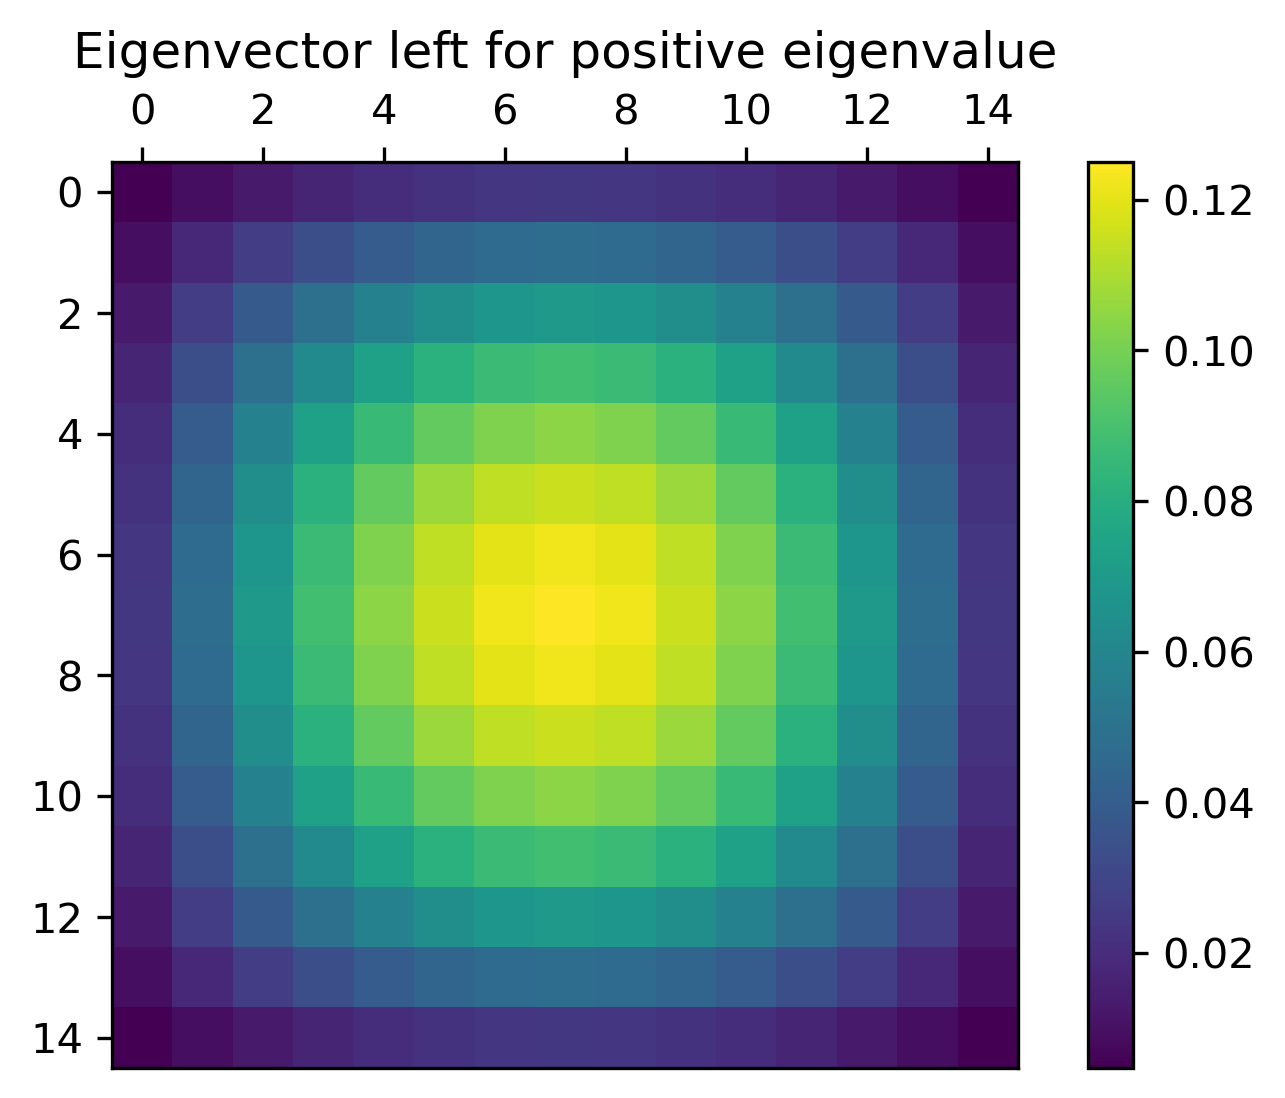

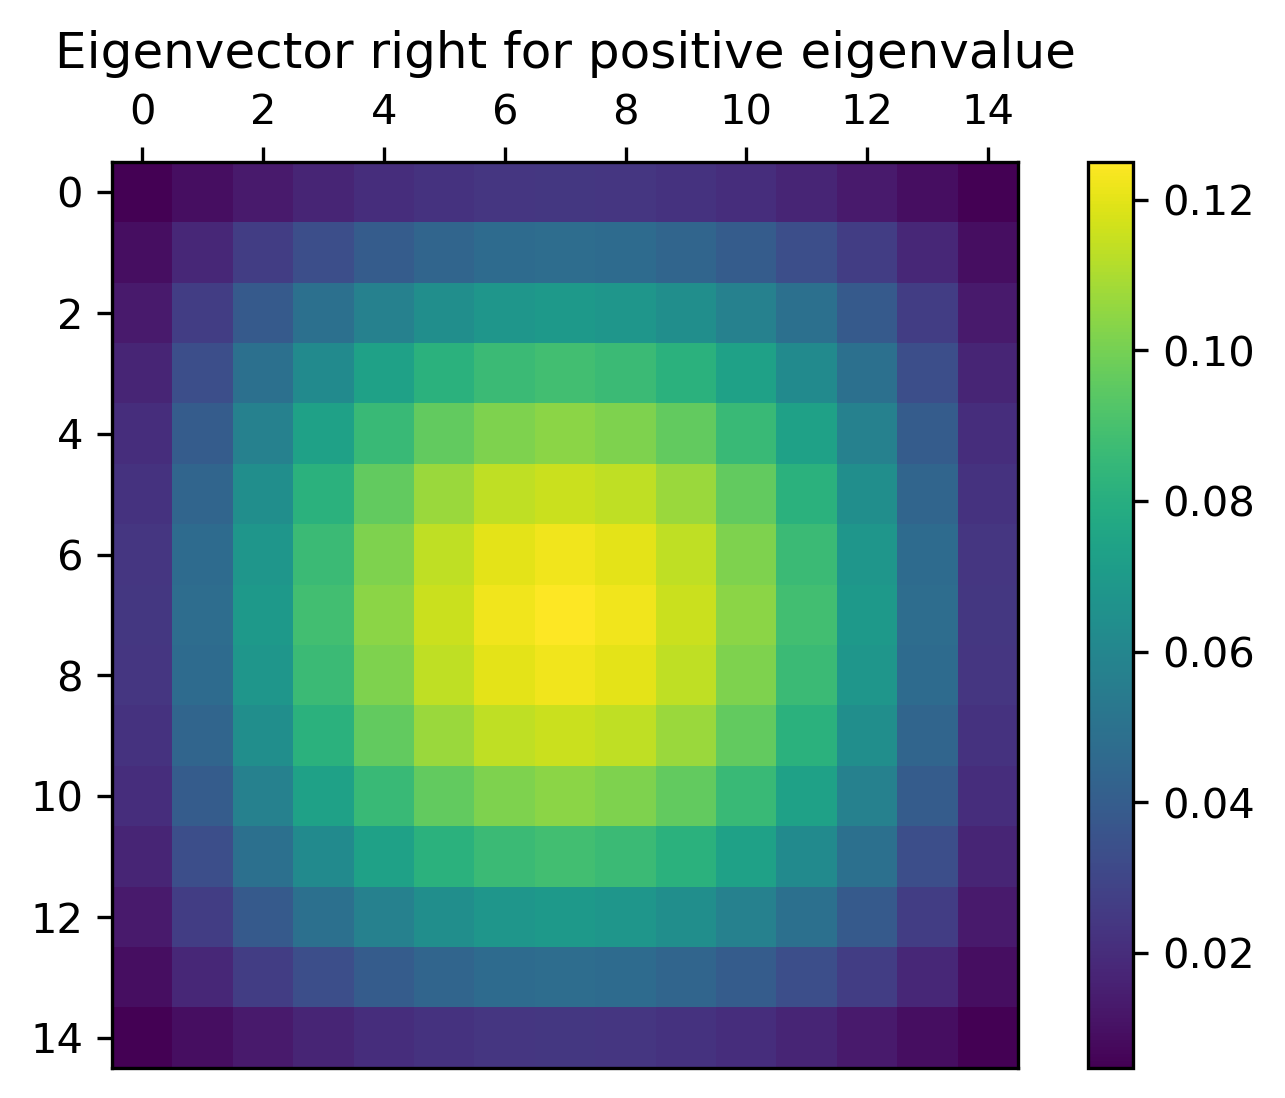

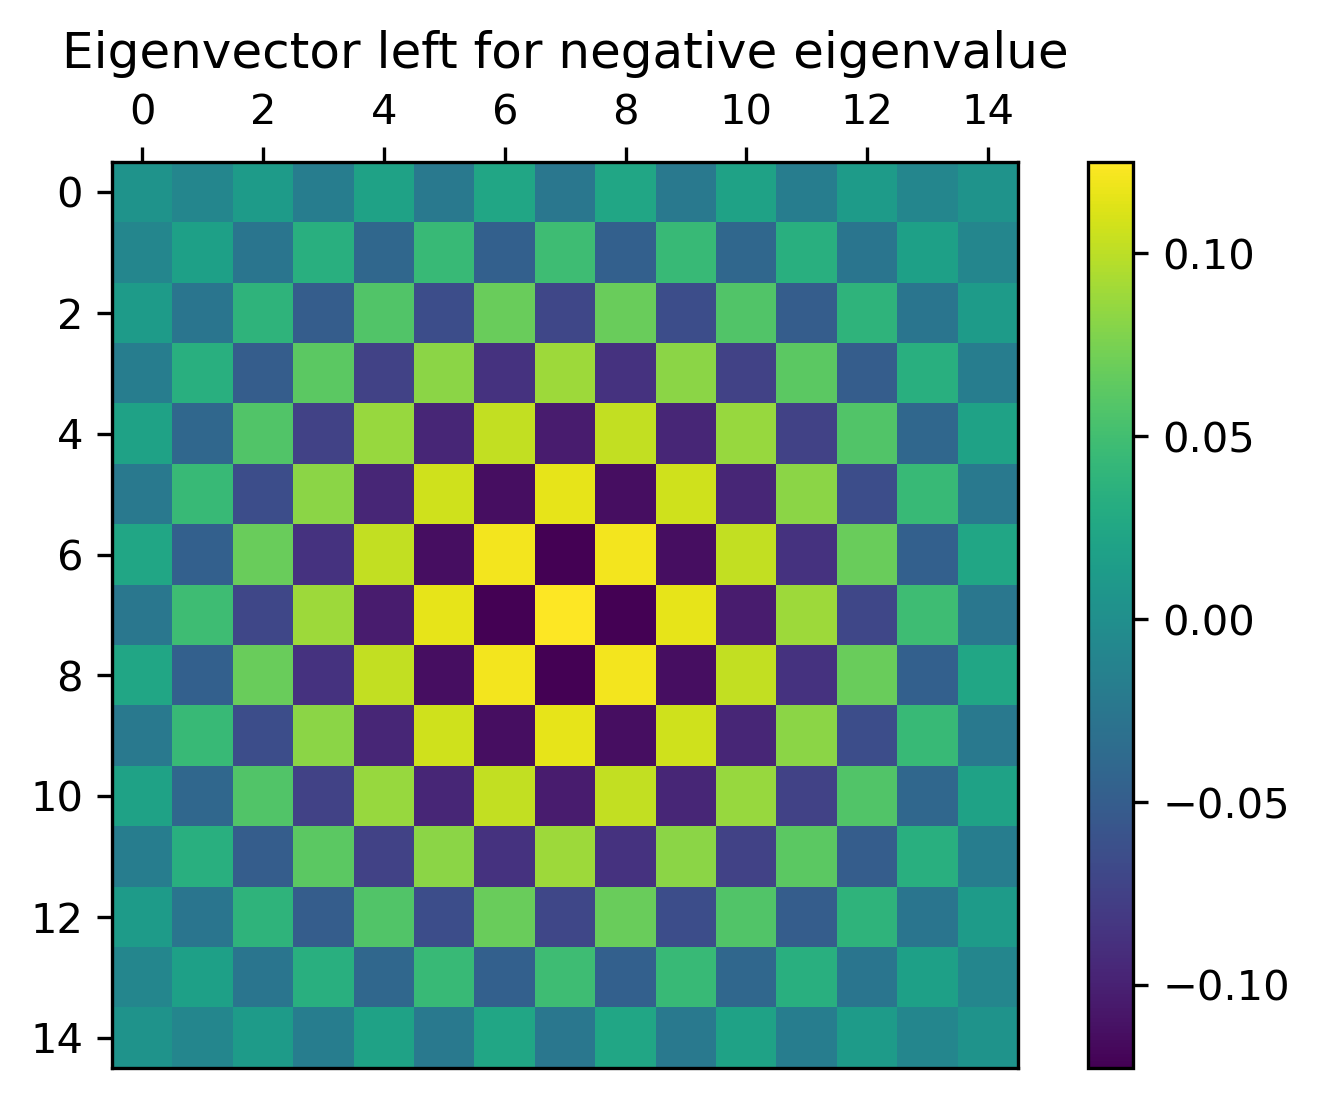

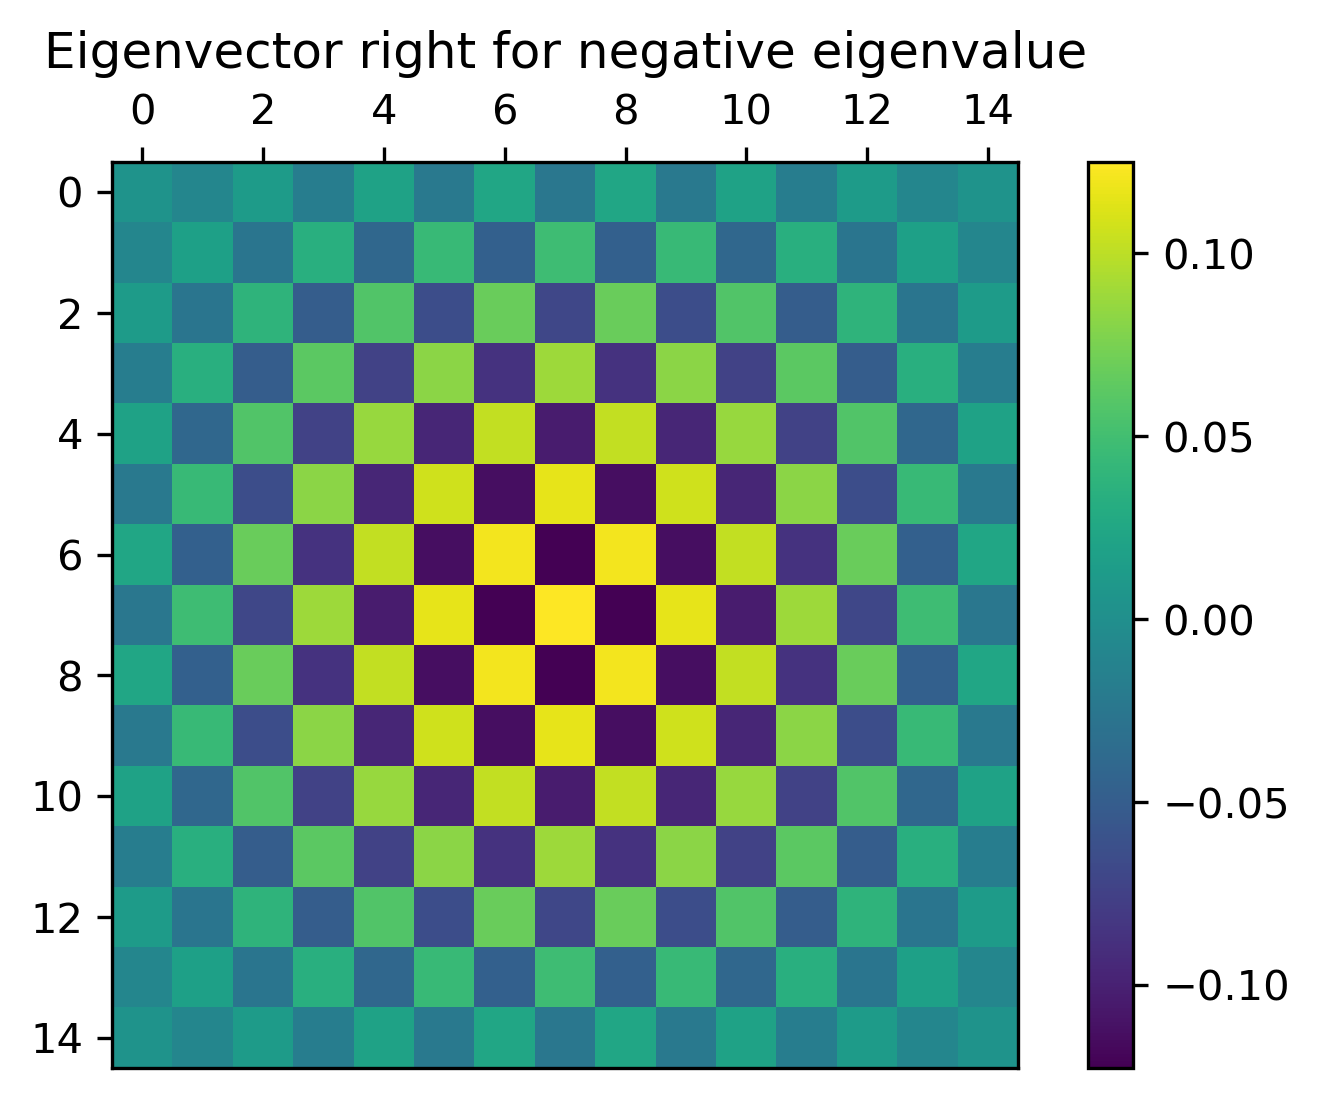

<Figure size 1800x1200 with 0 Axes>

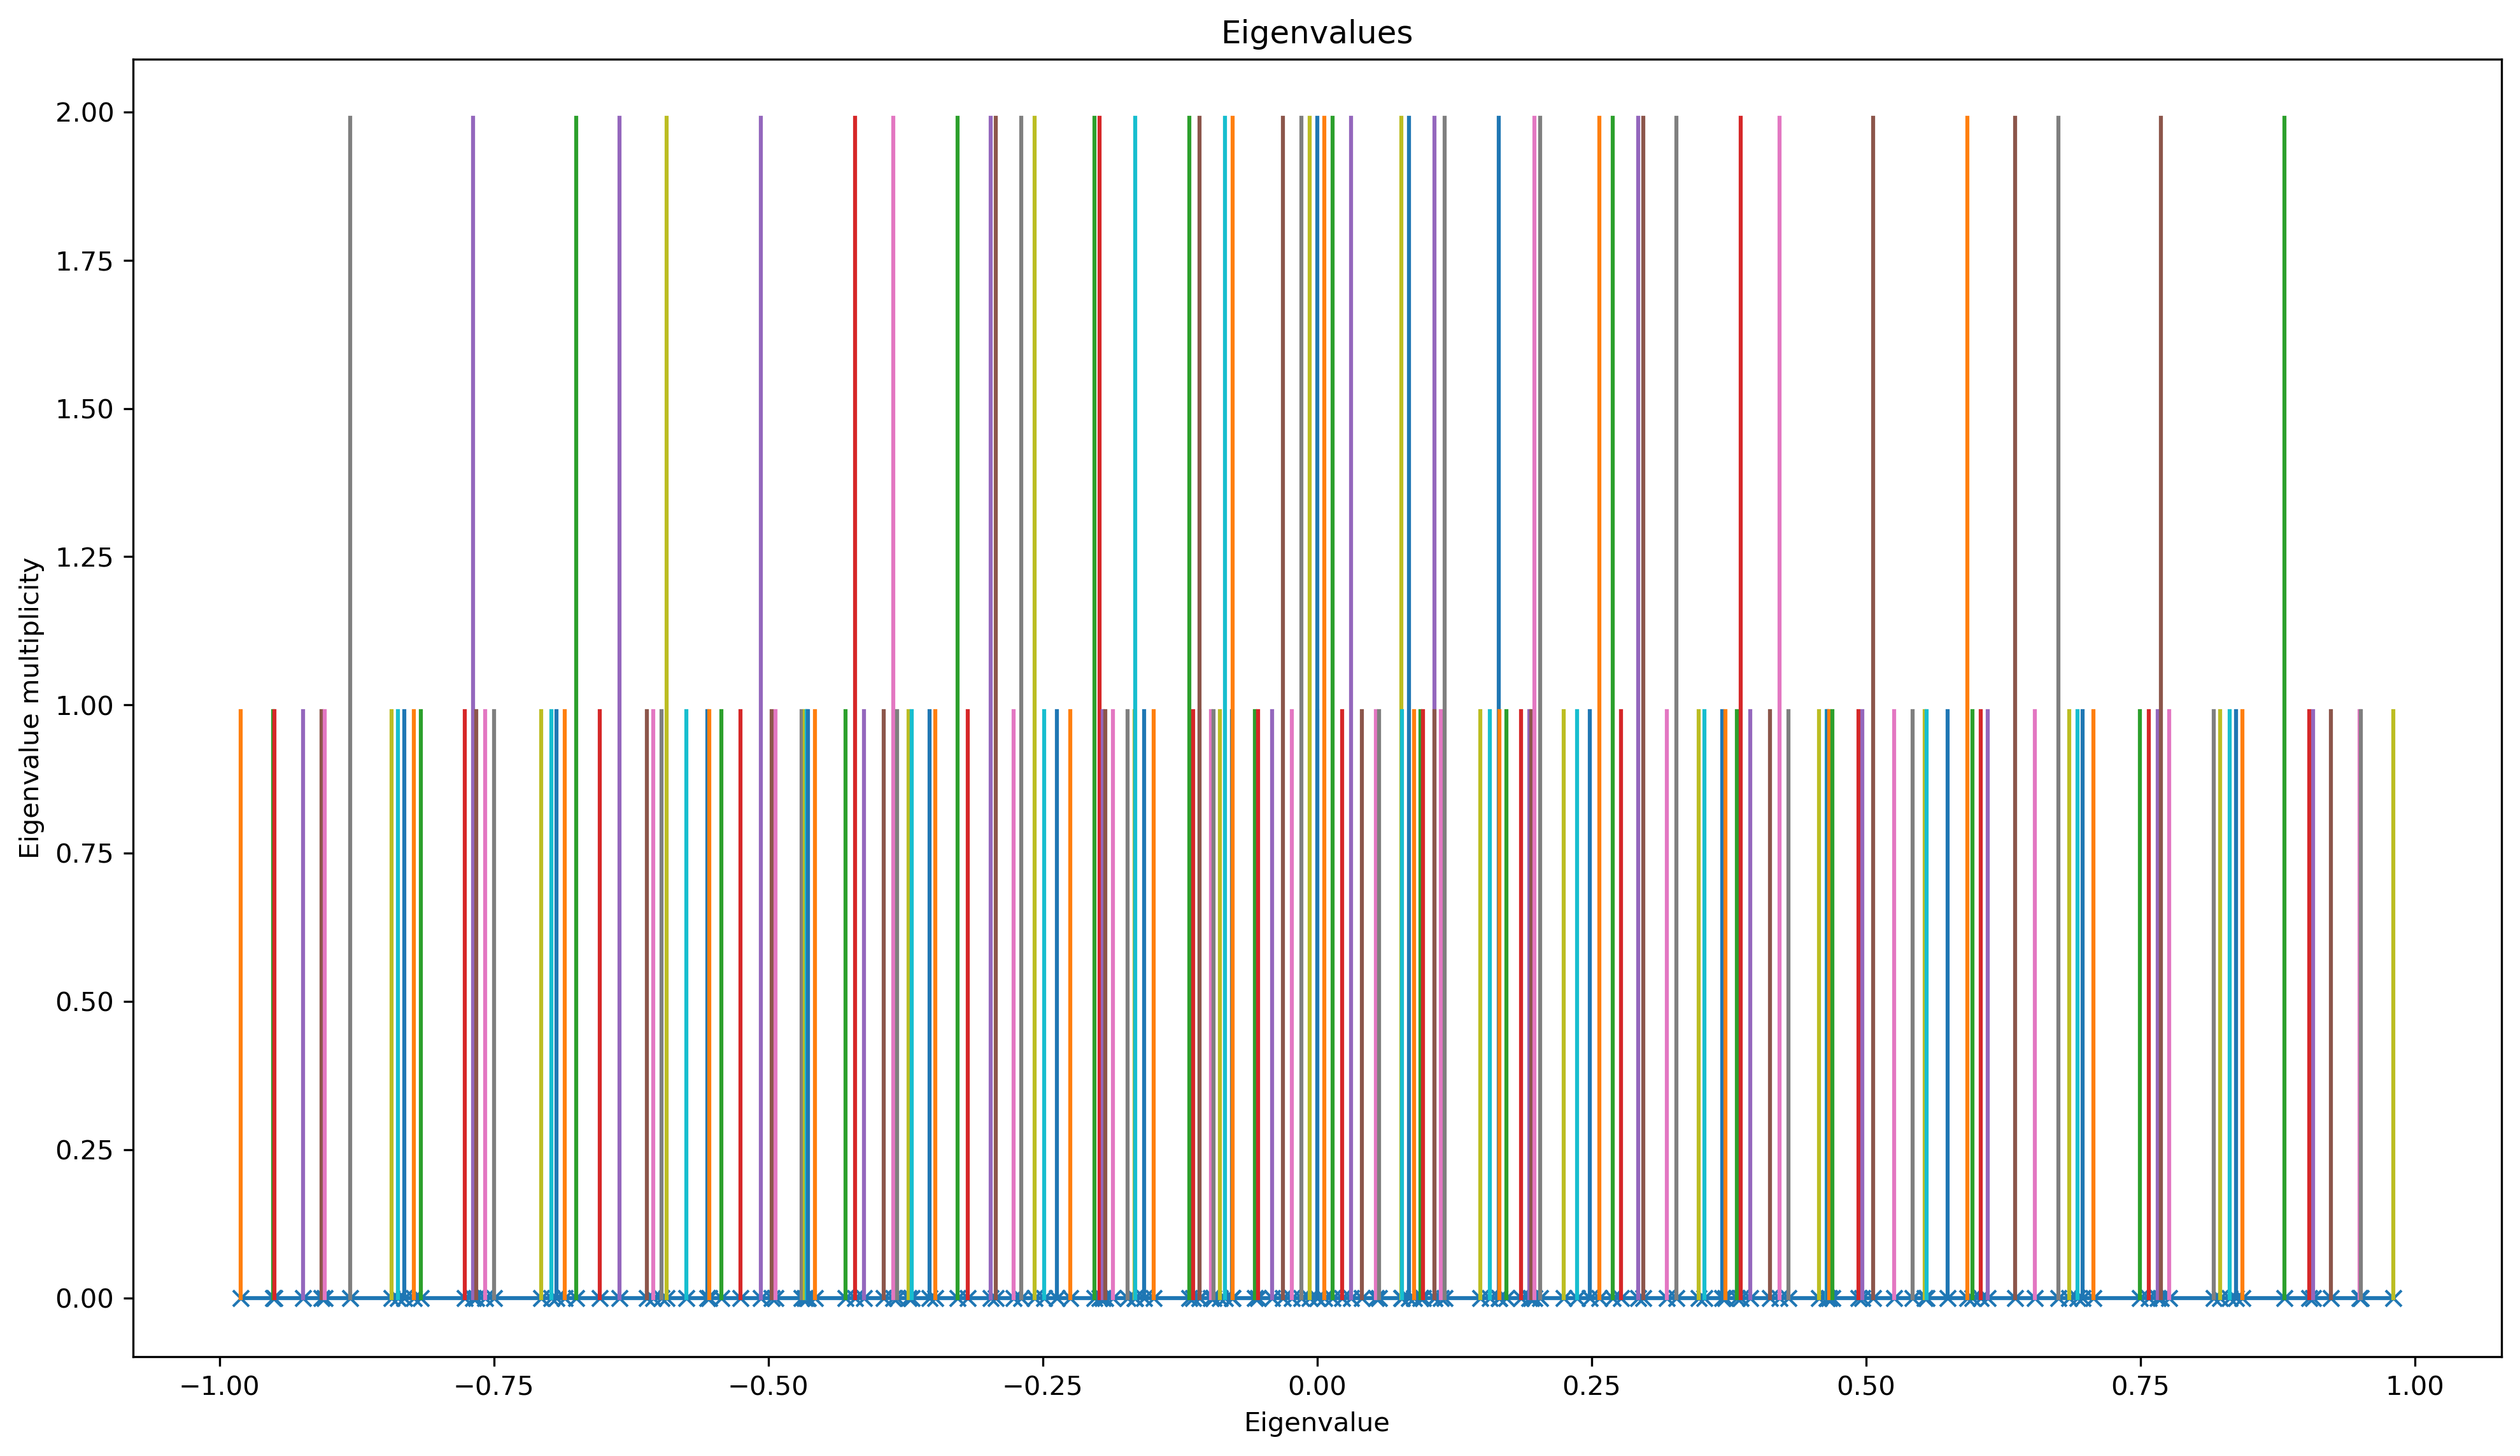

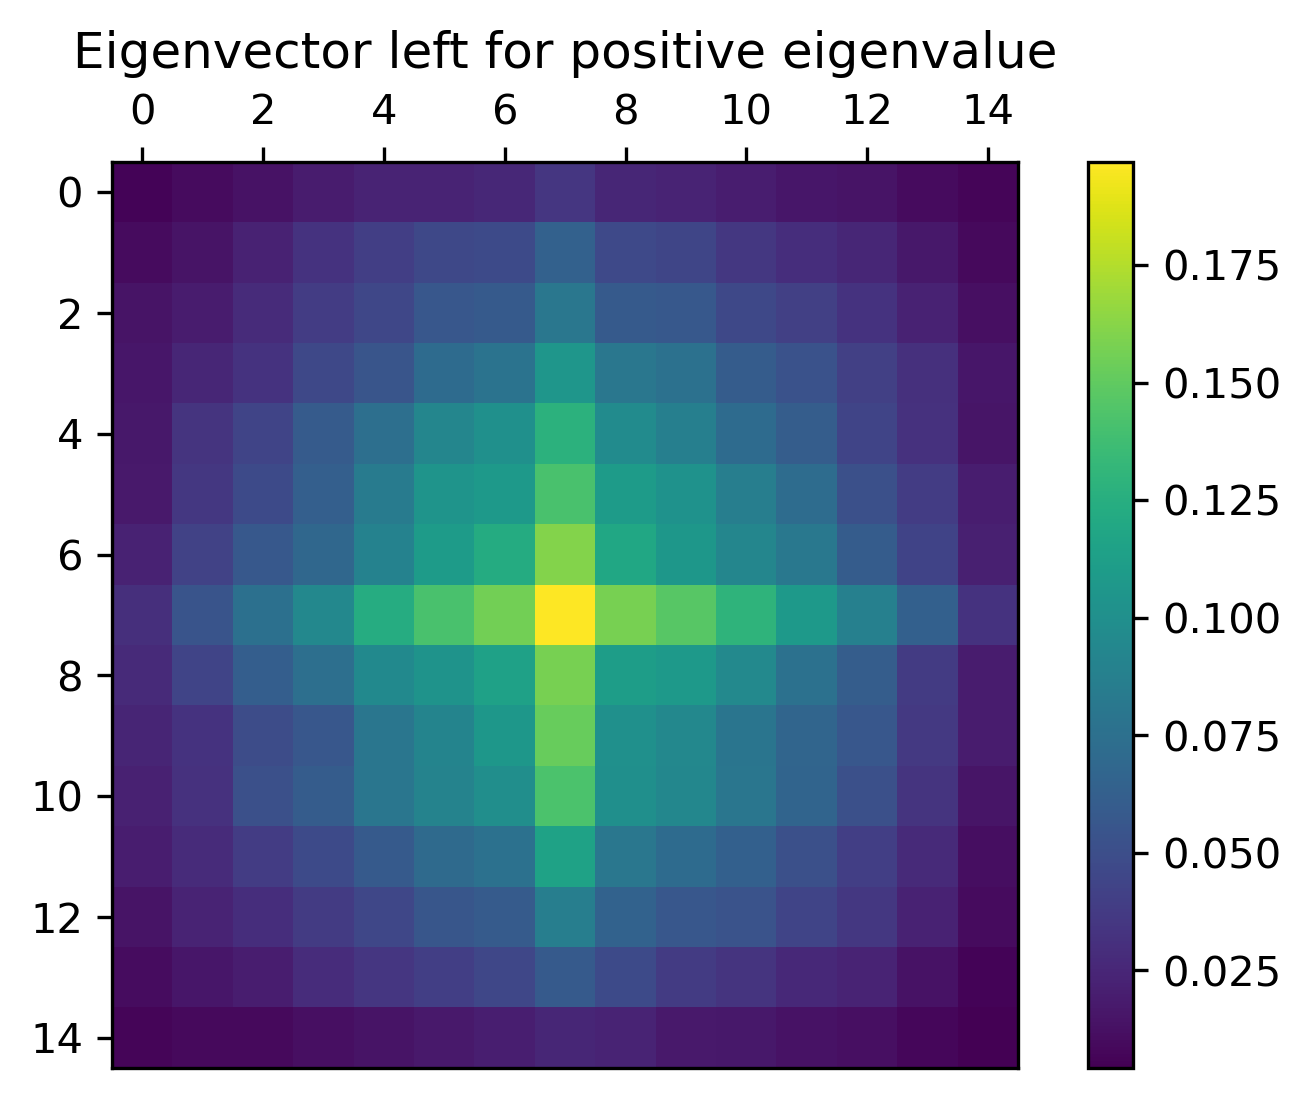

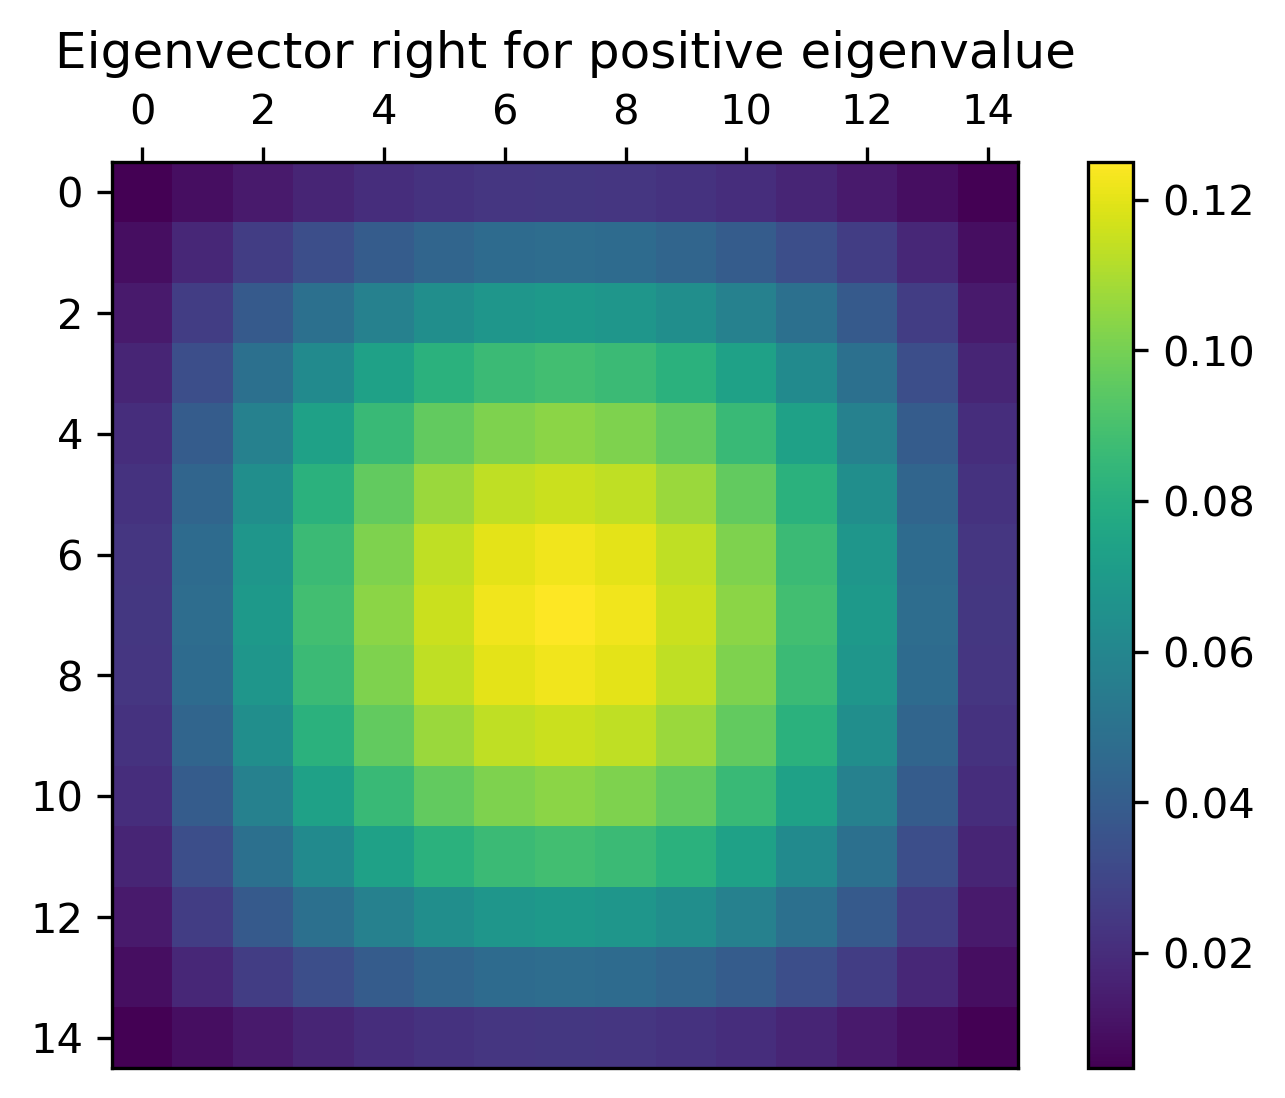

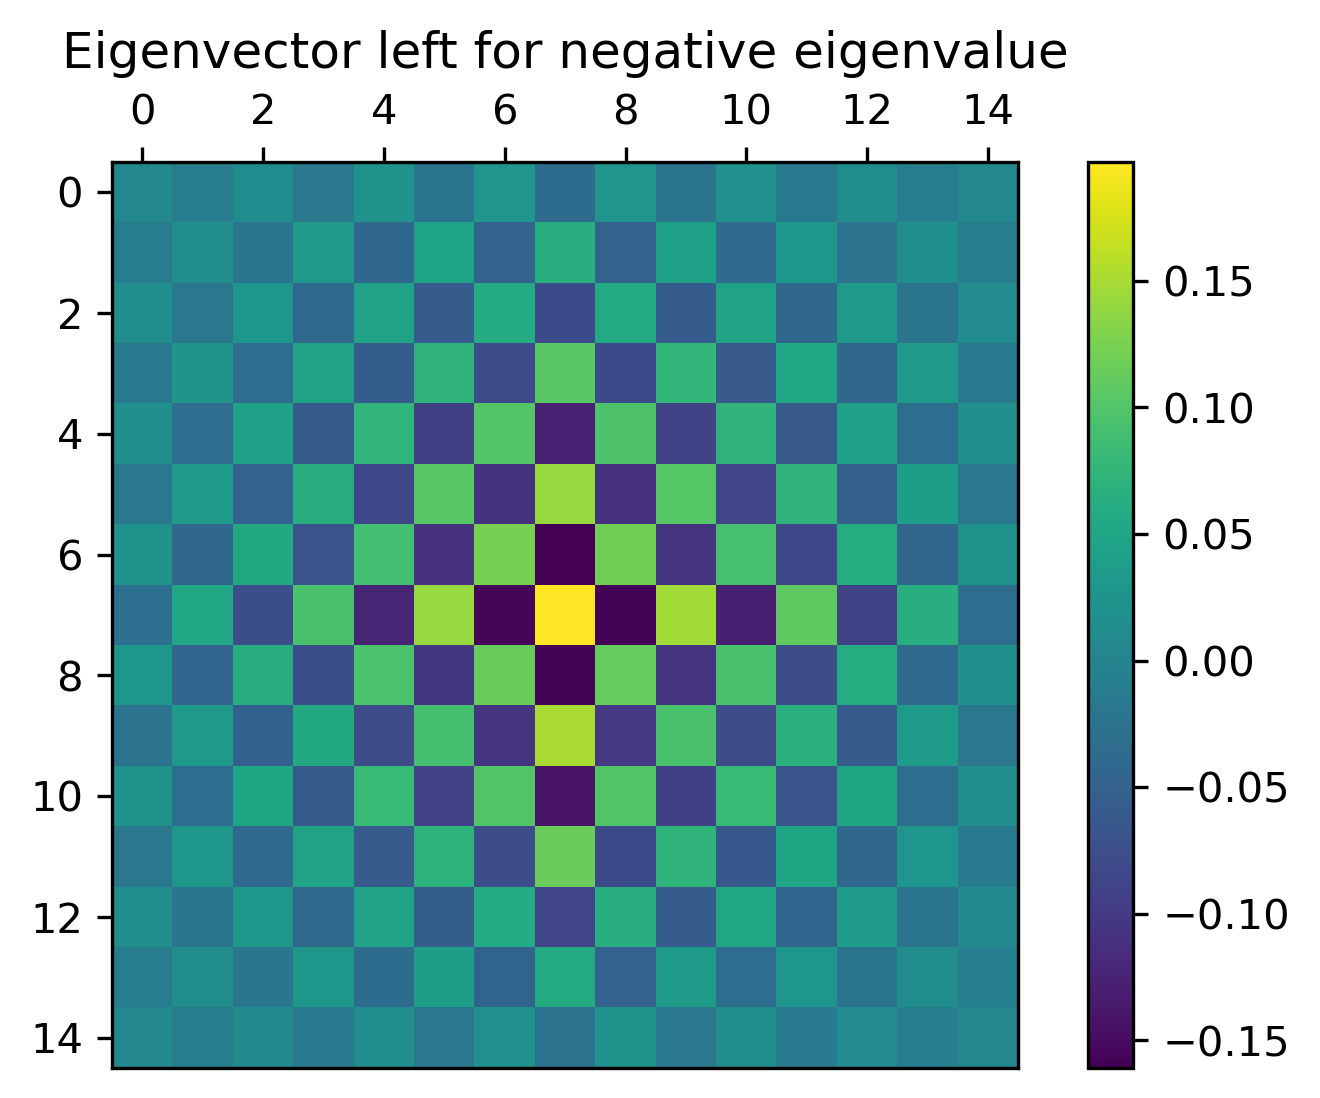

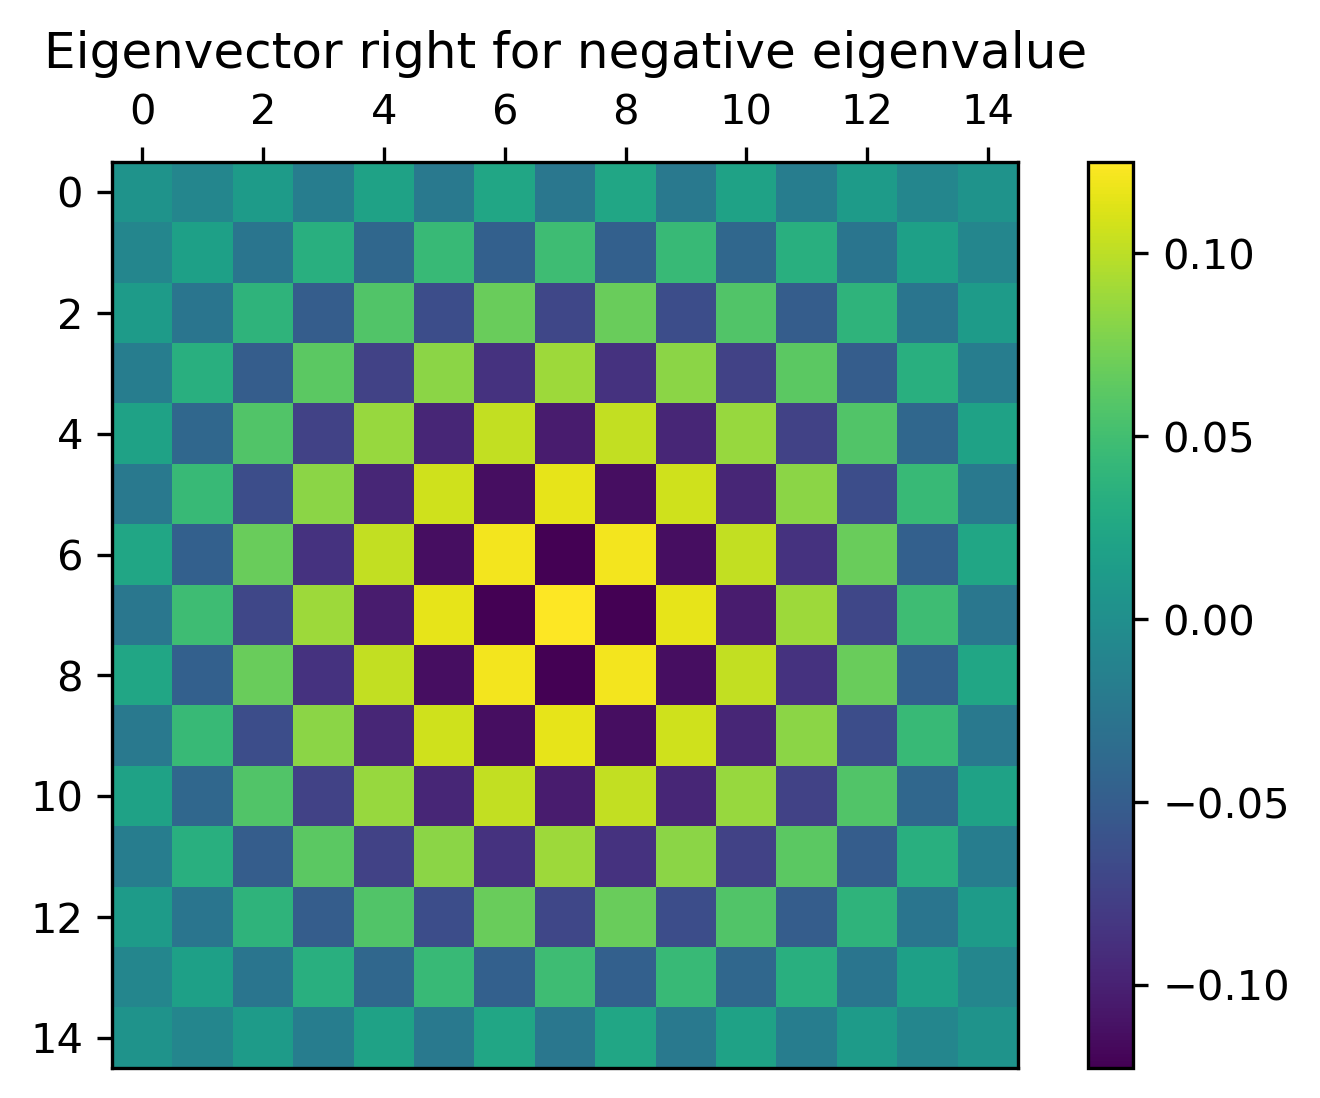

<Figure size 1800x1200 with 0 Axes>

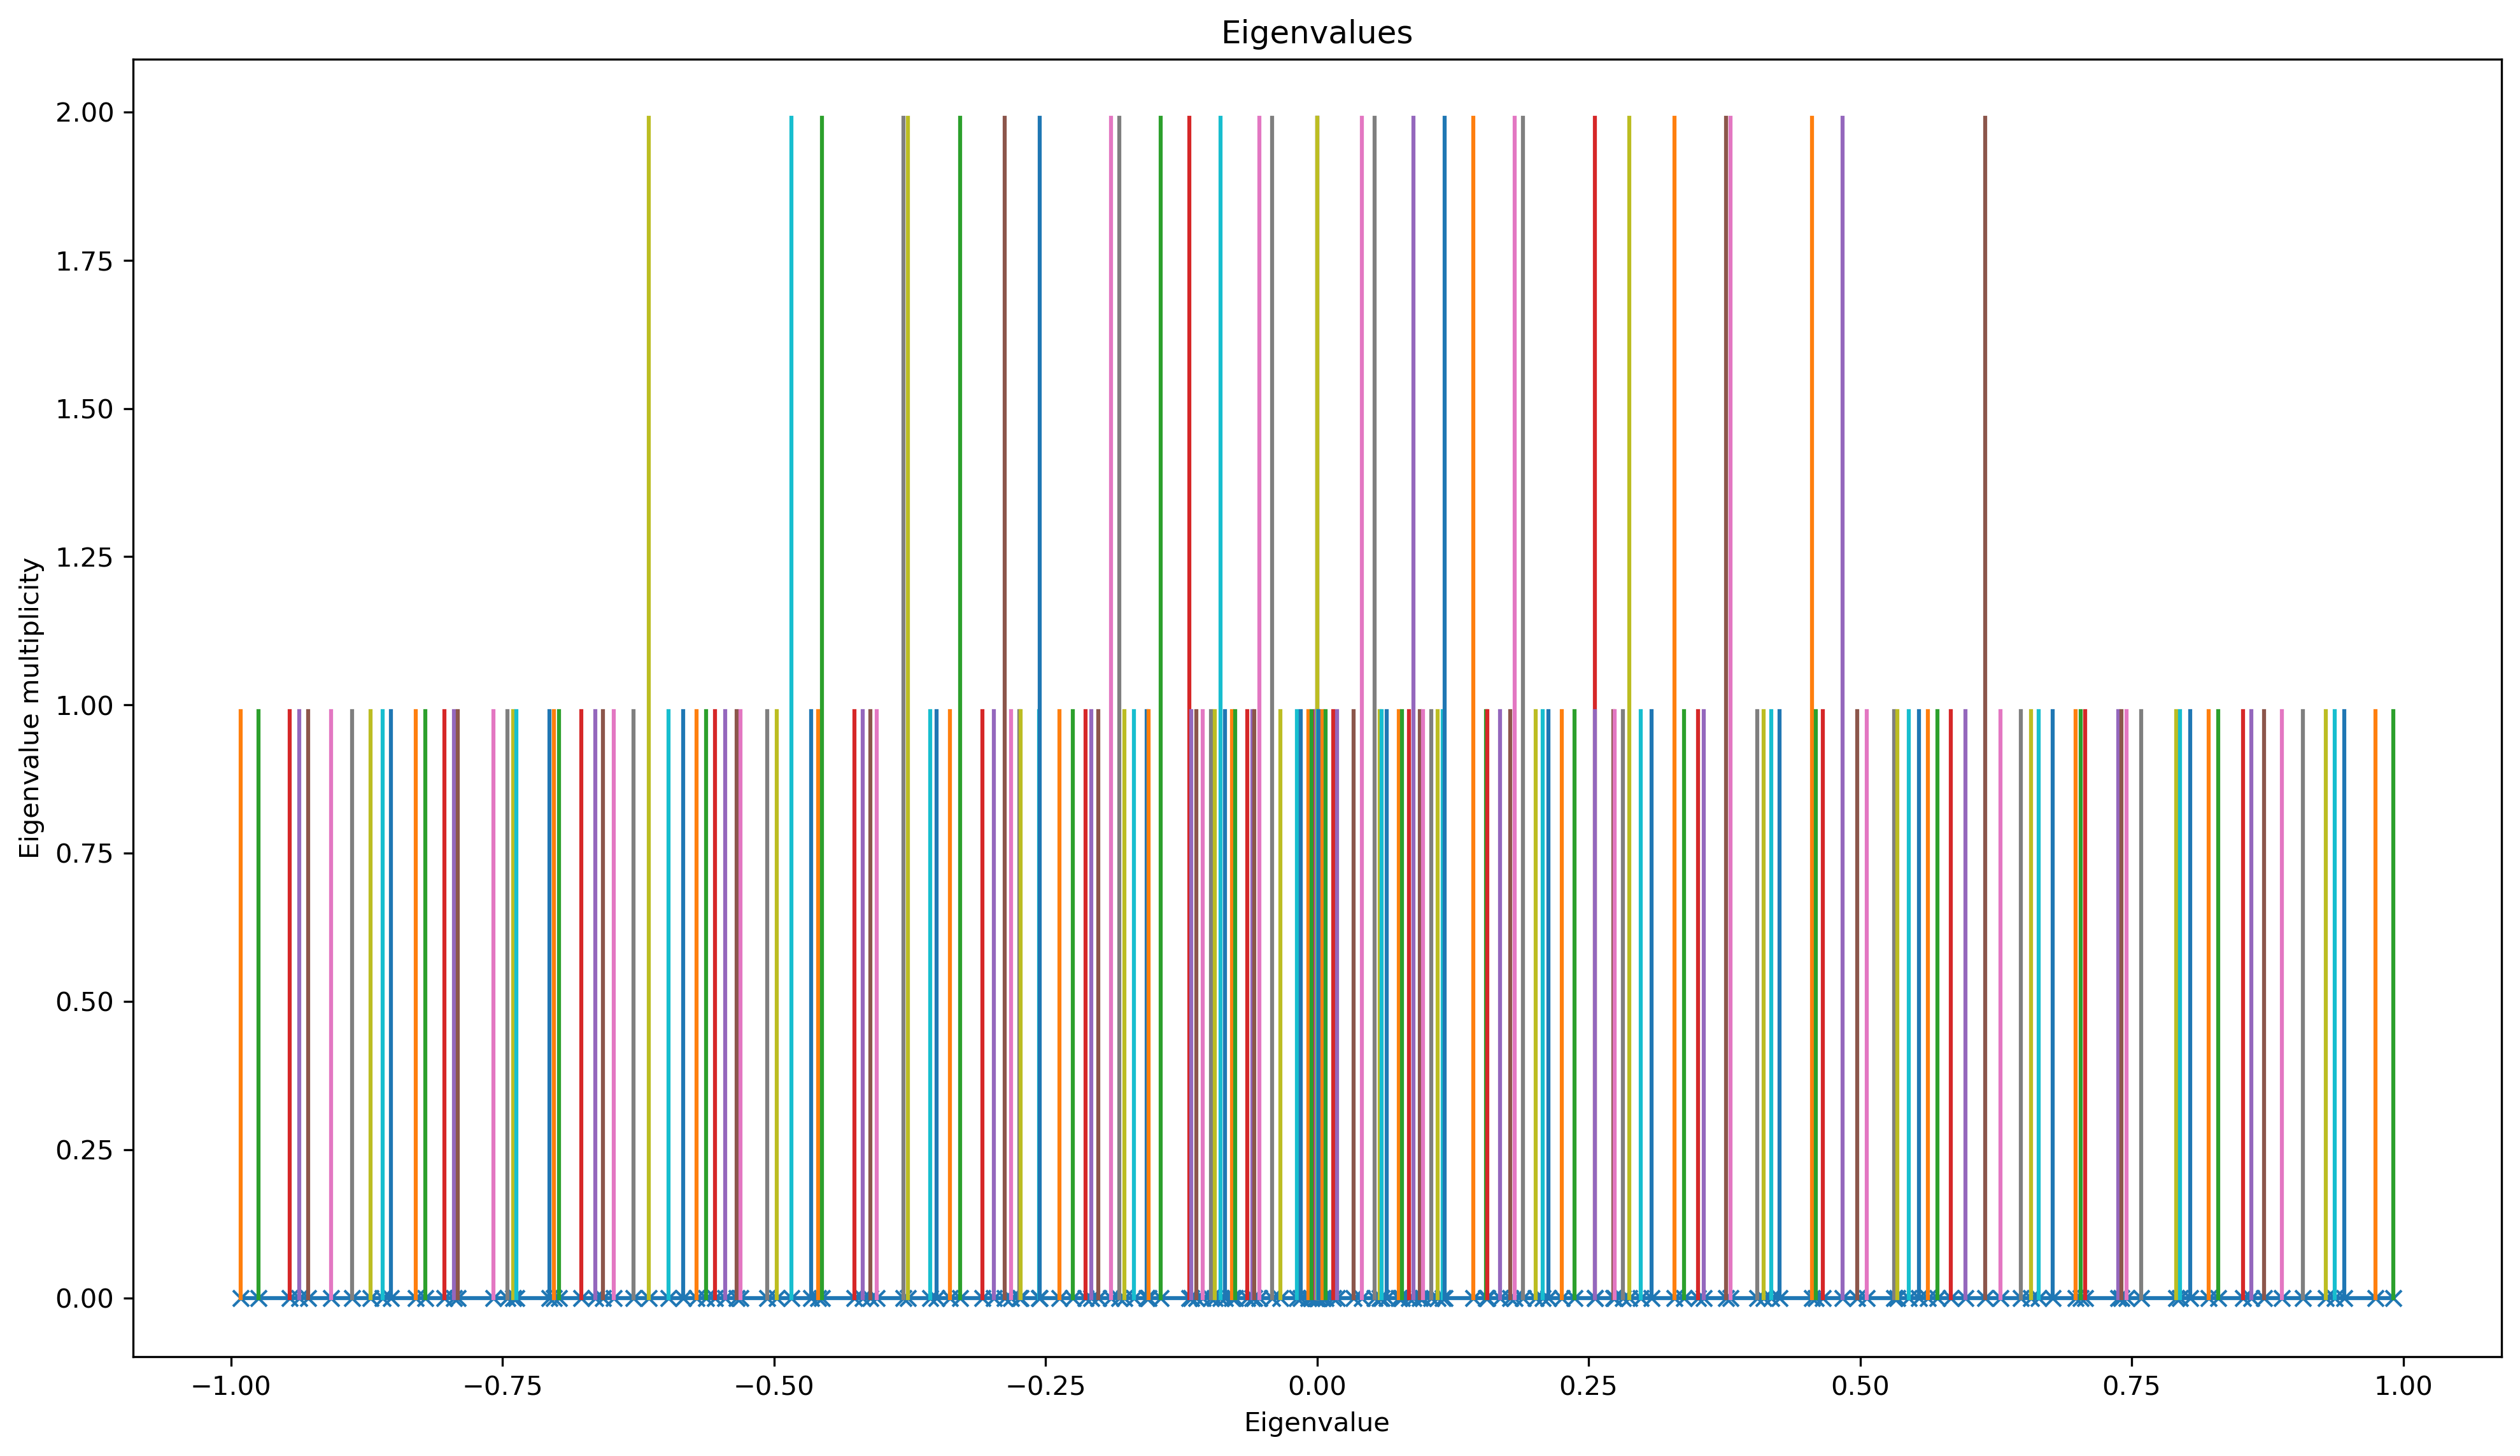

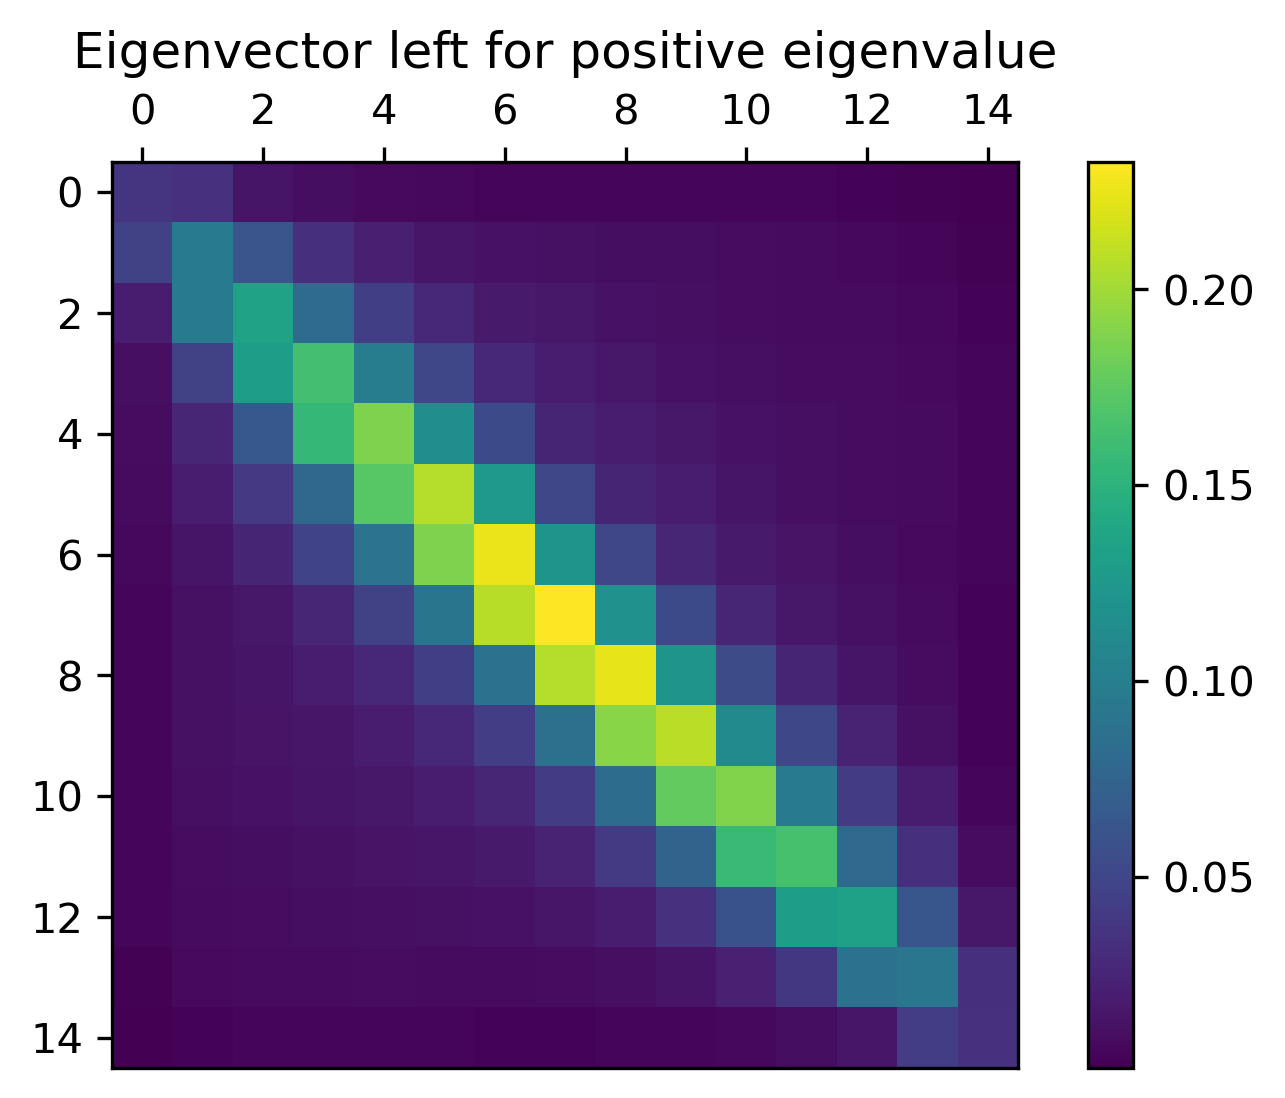

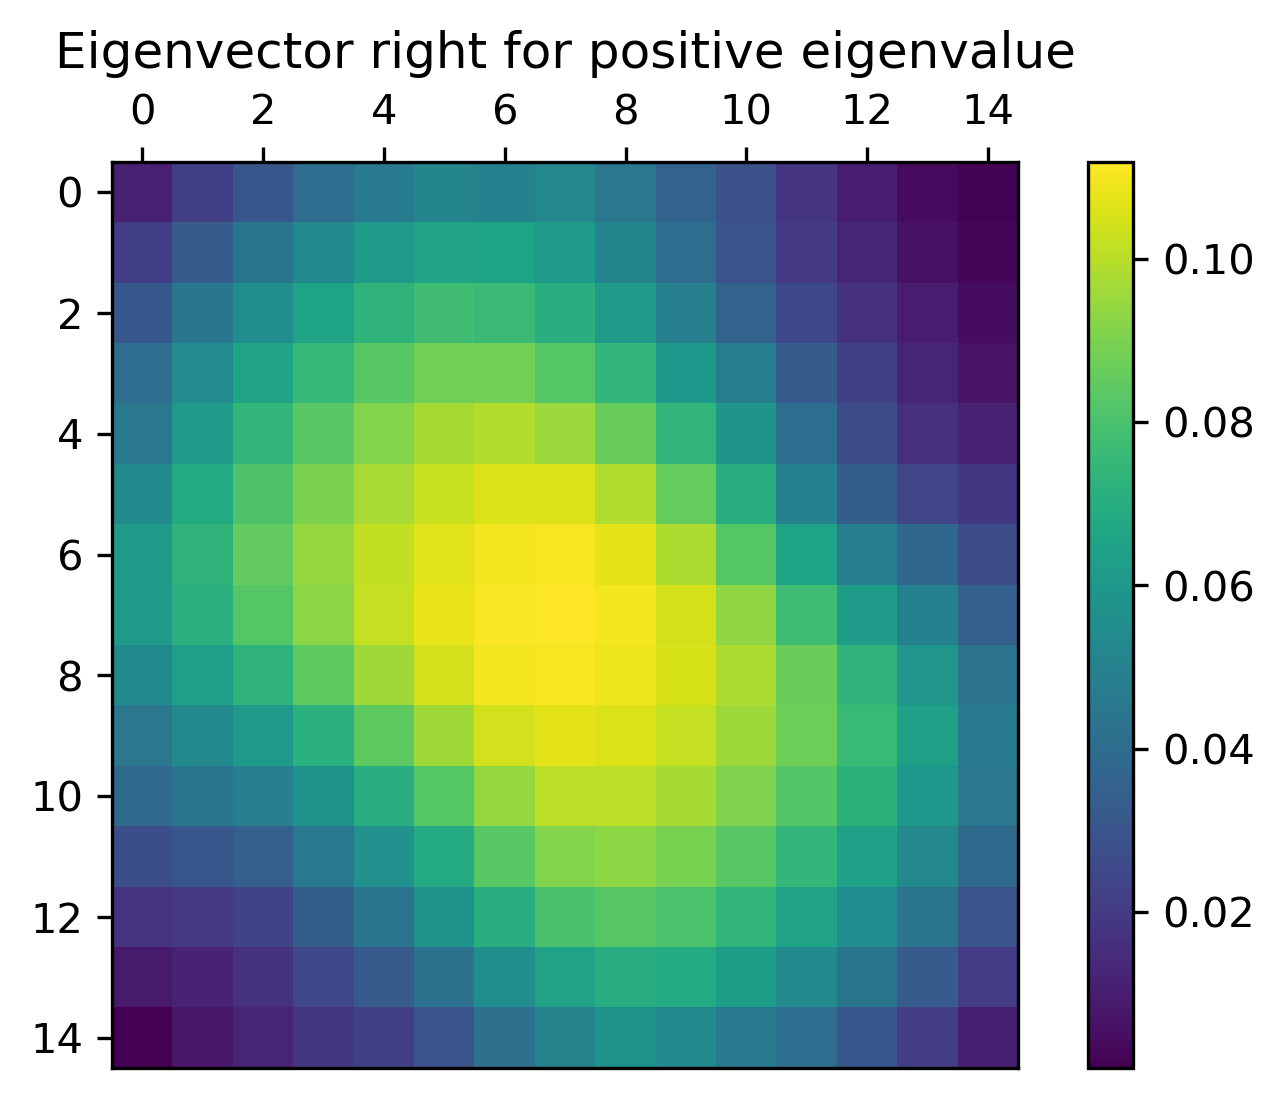

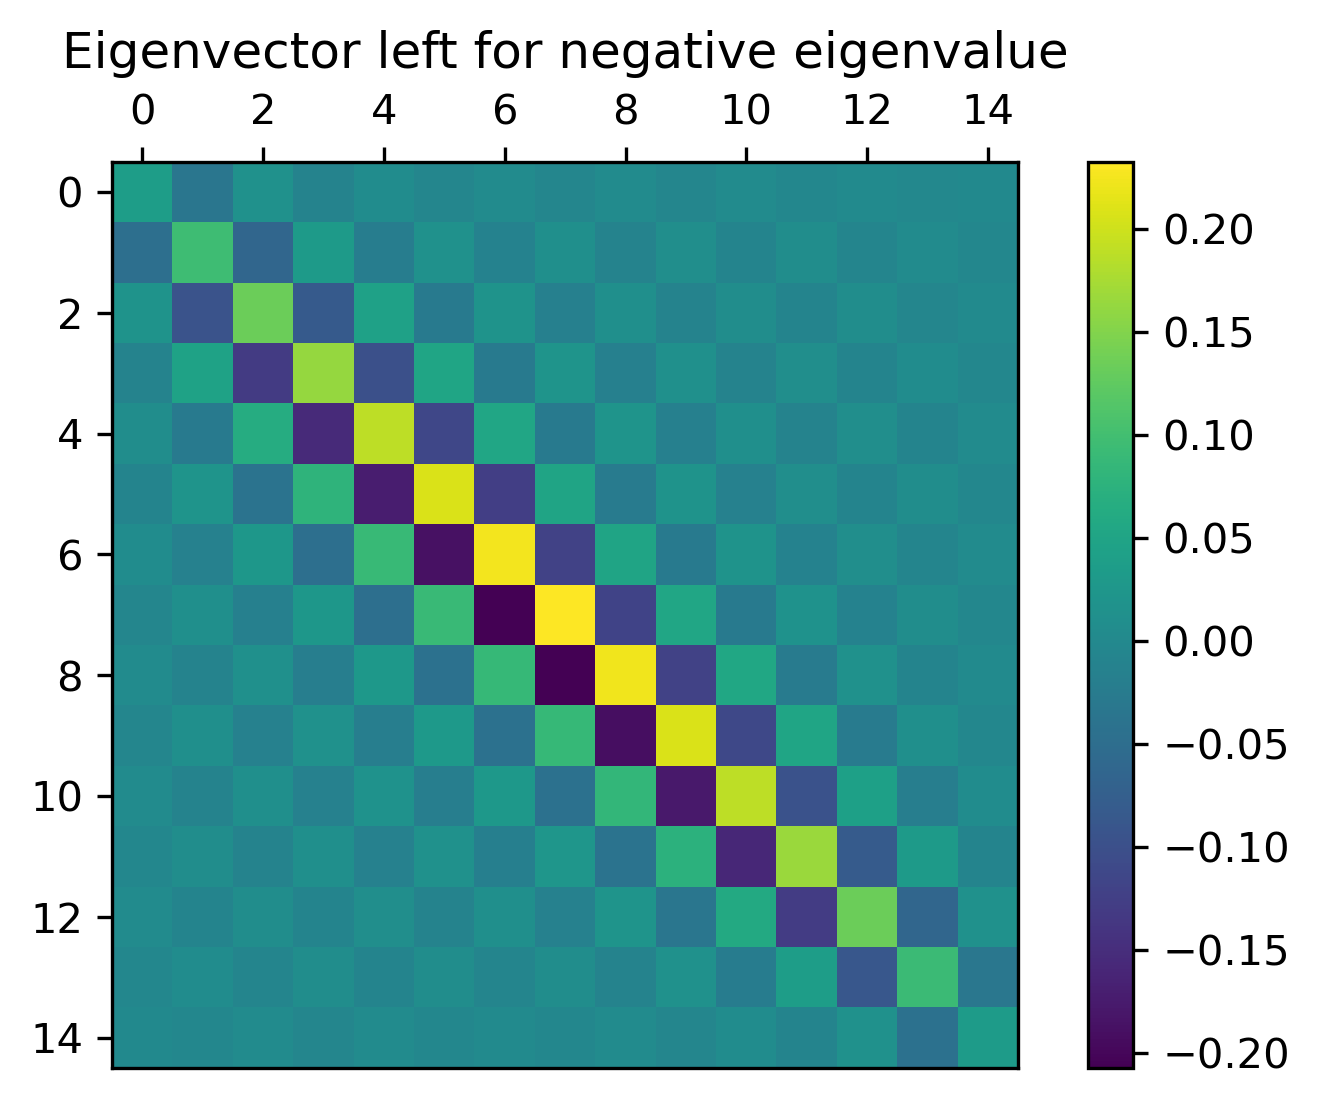

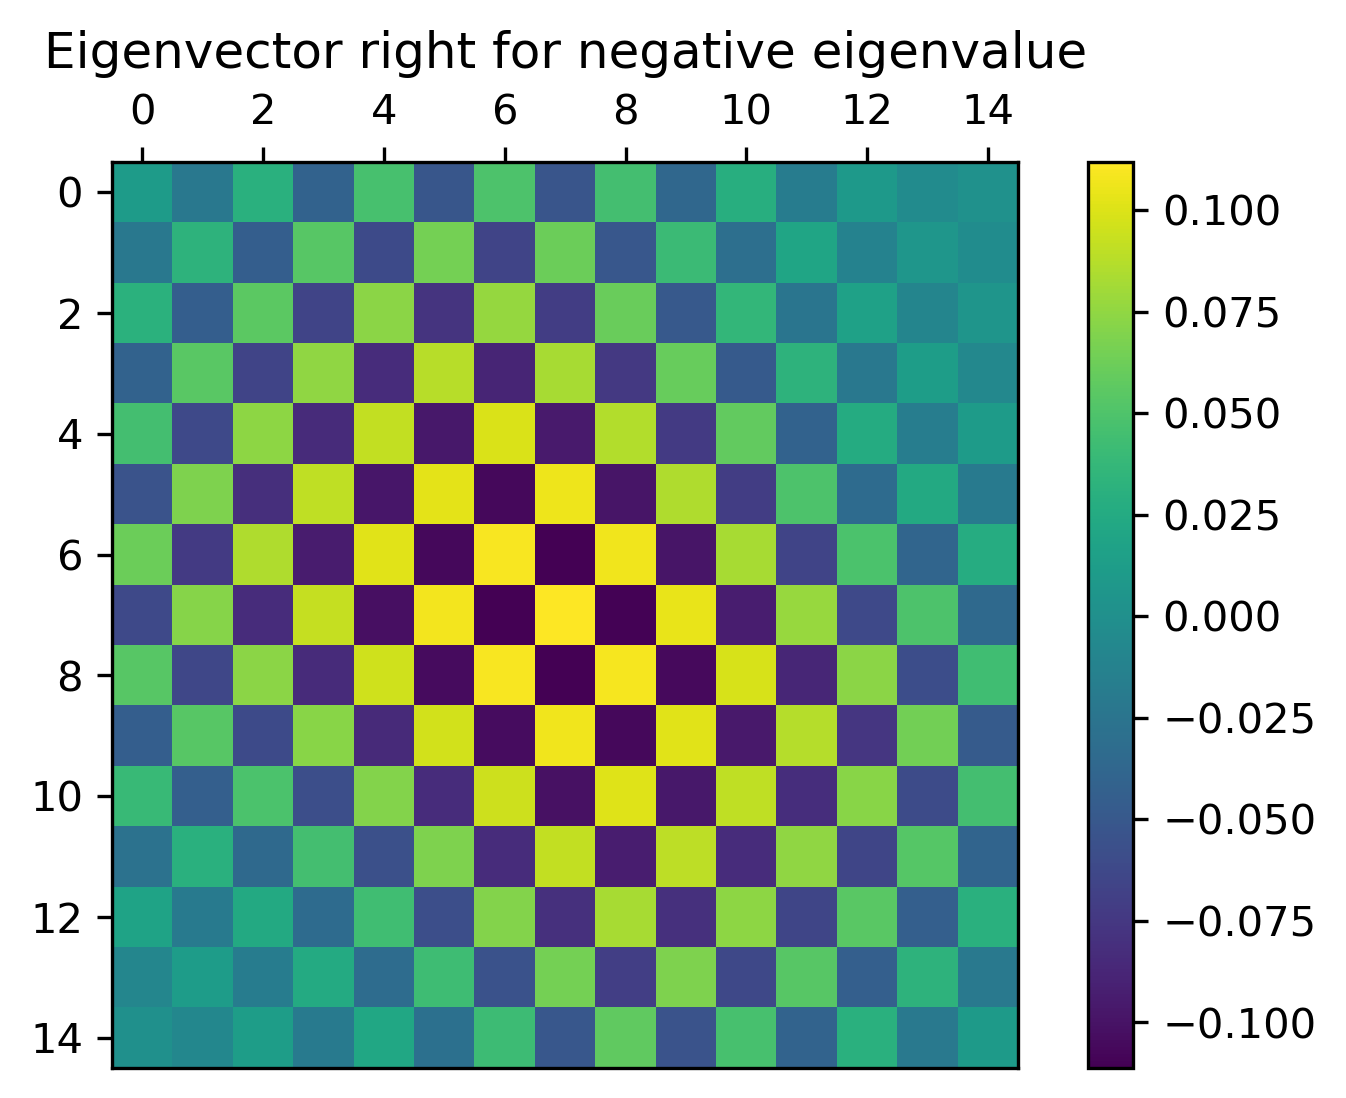

<Figure size 1800x1200 with 0 Axes>

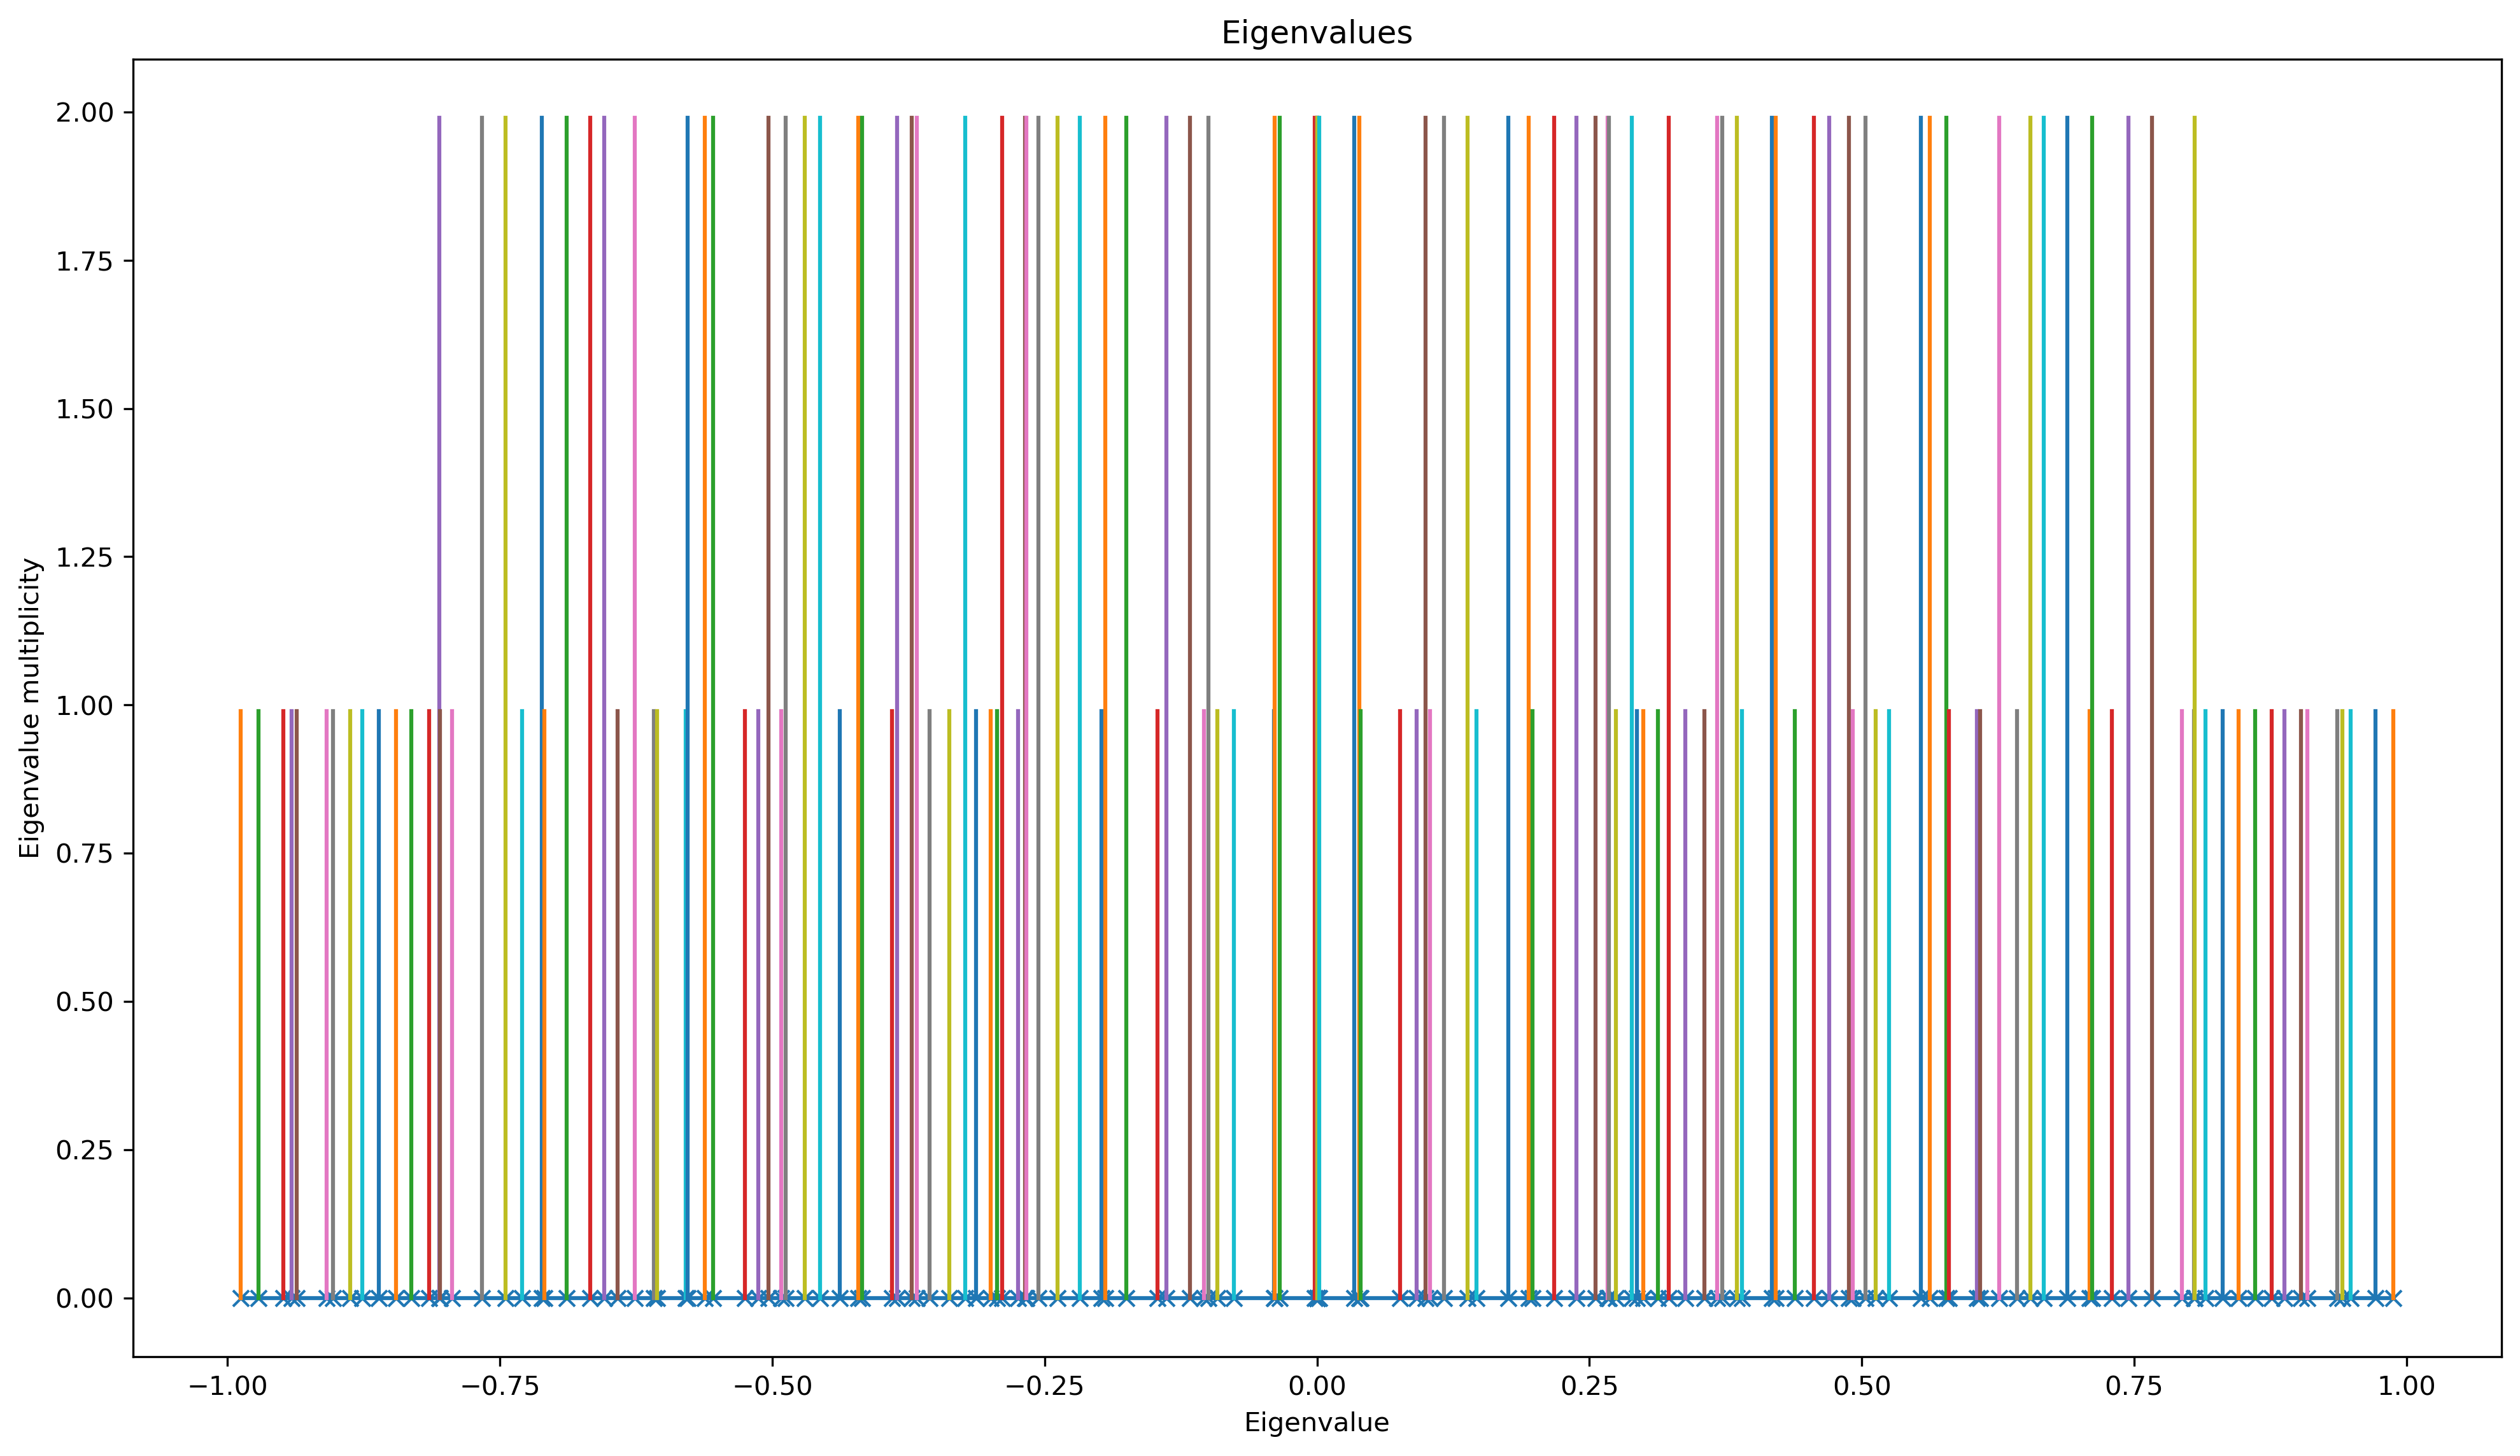

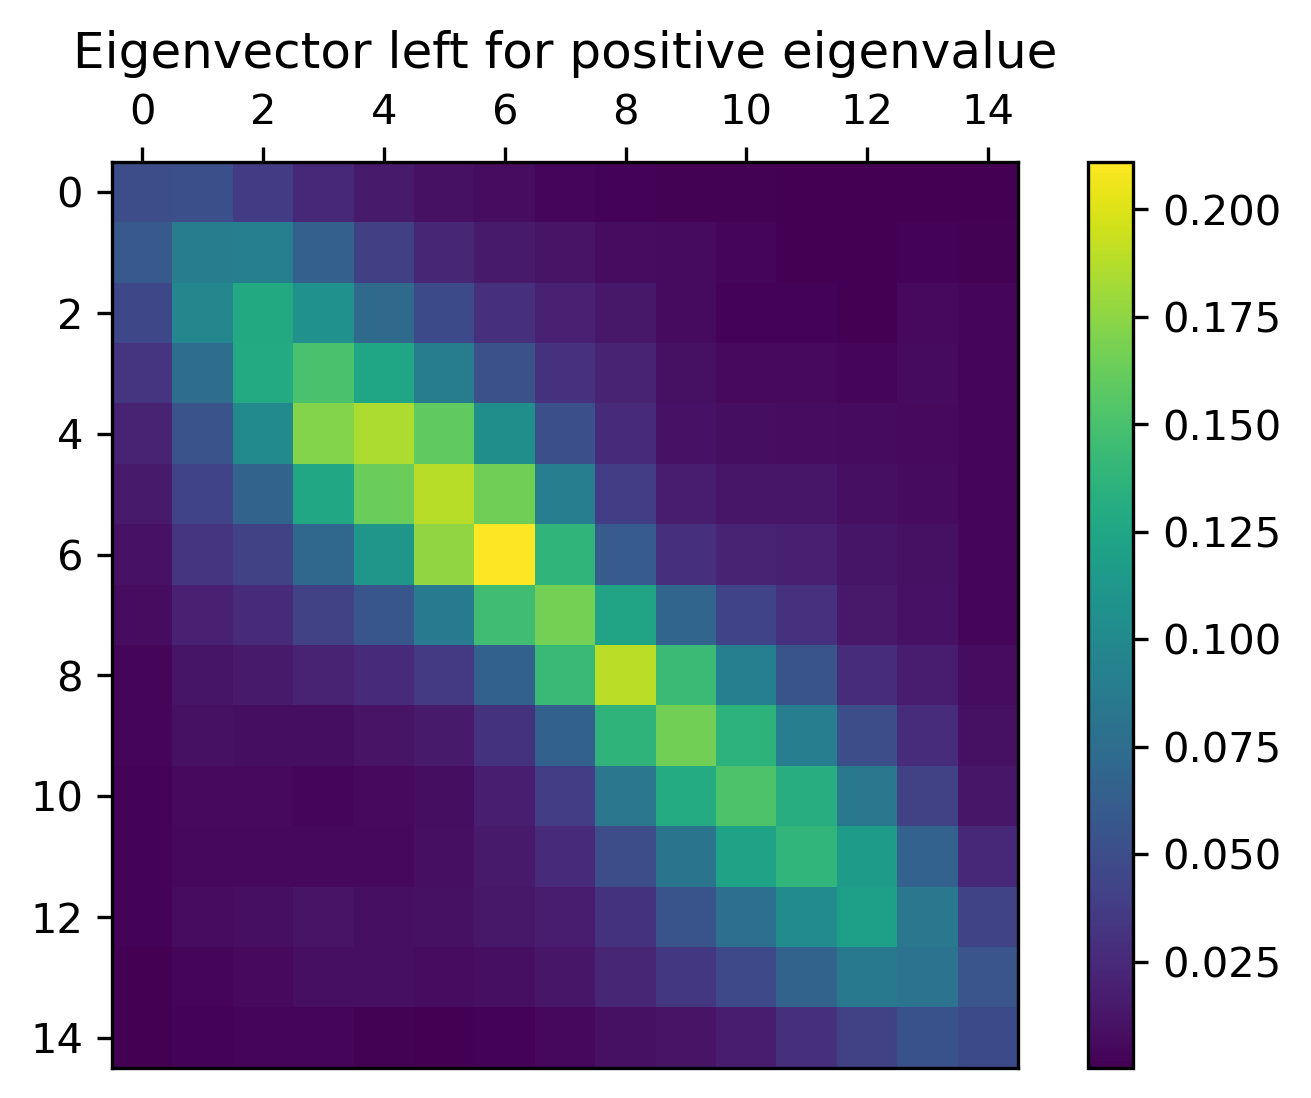

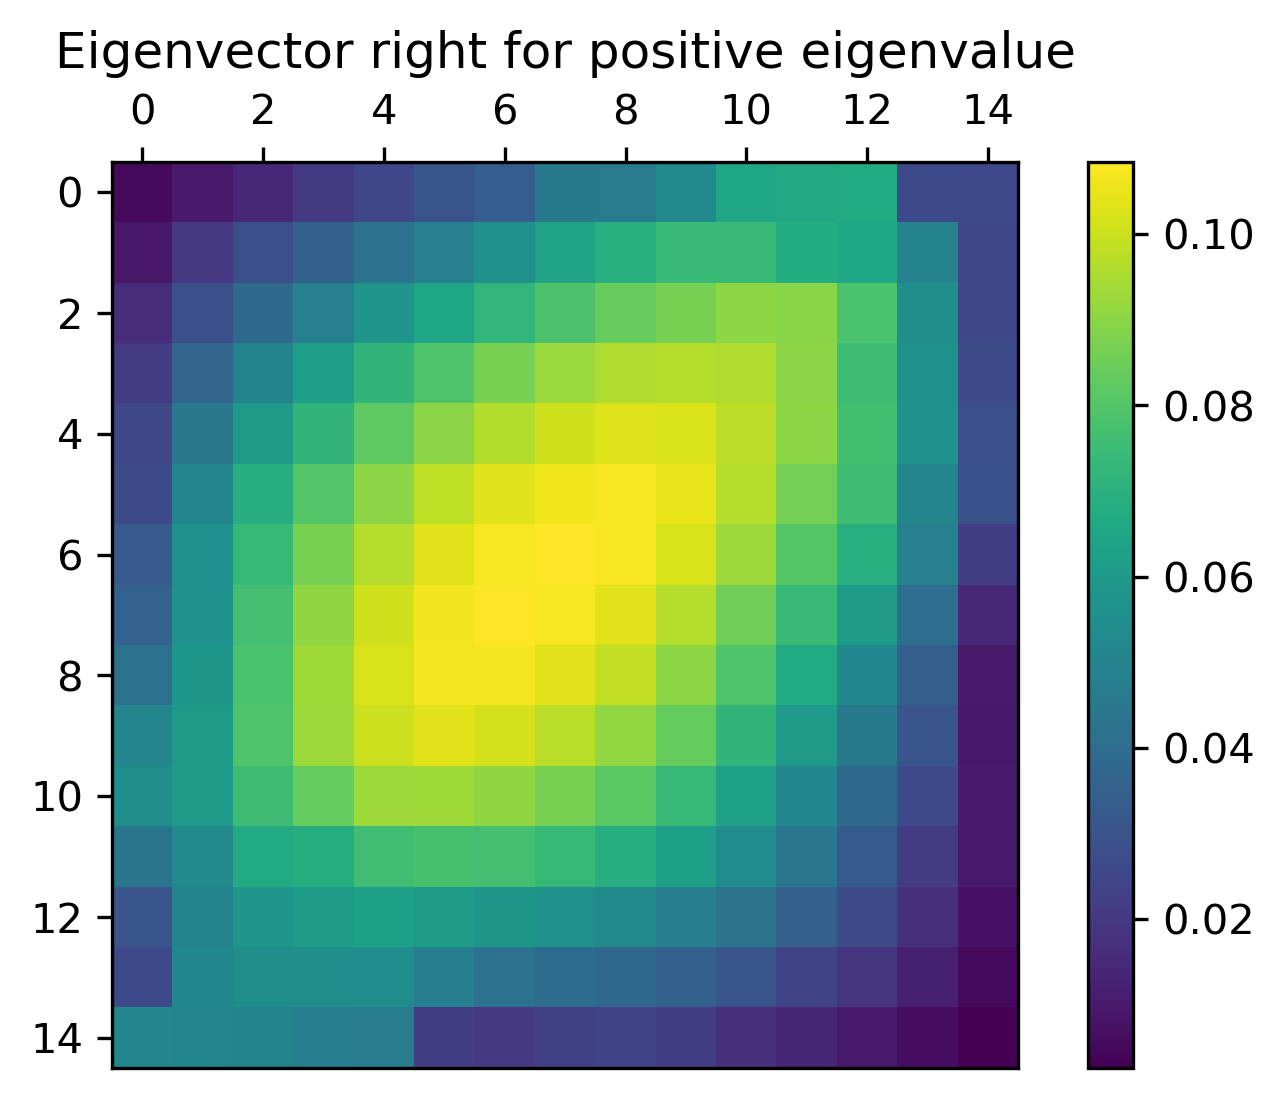

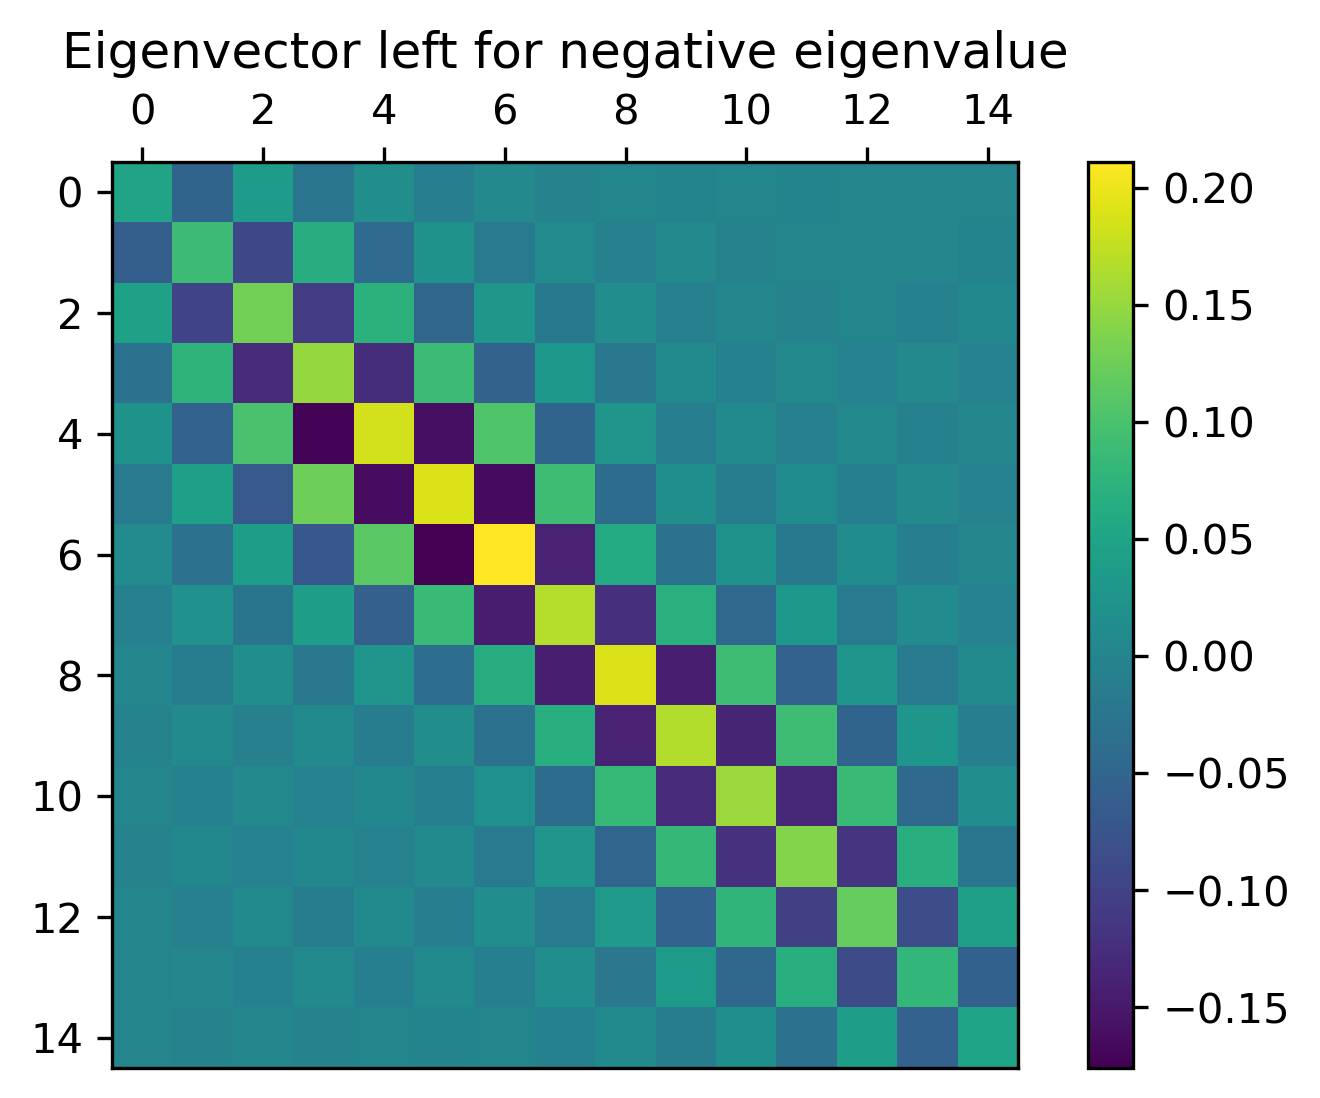

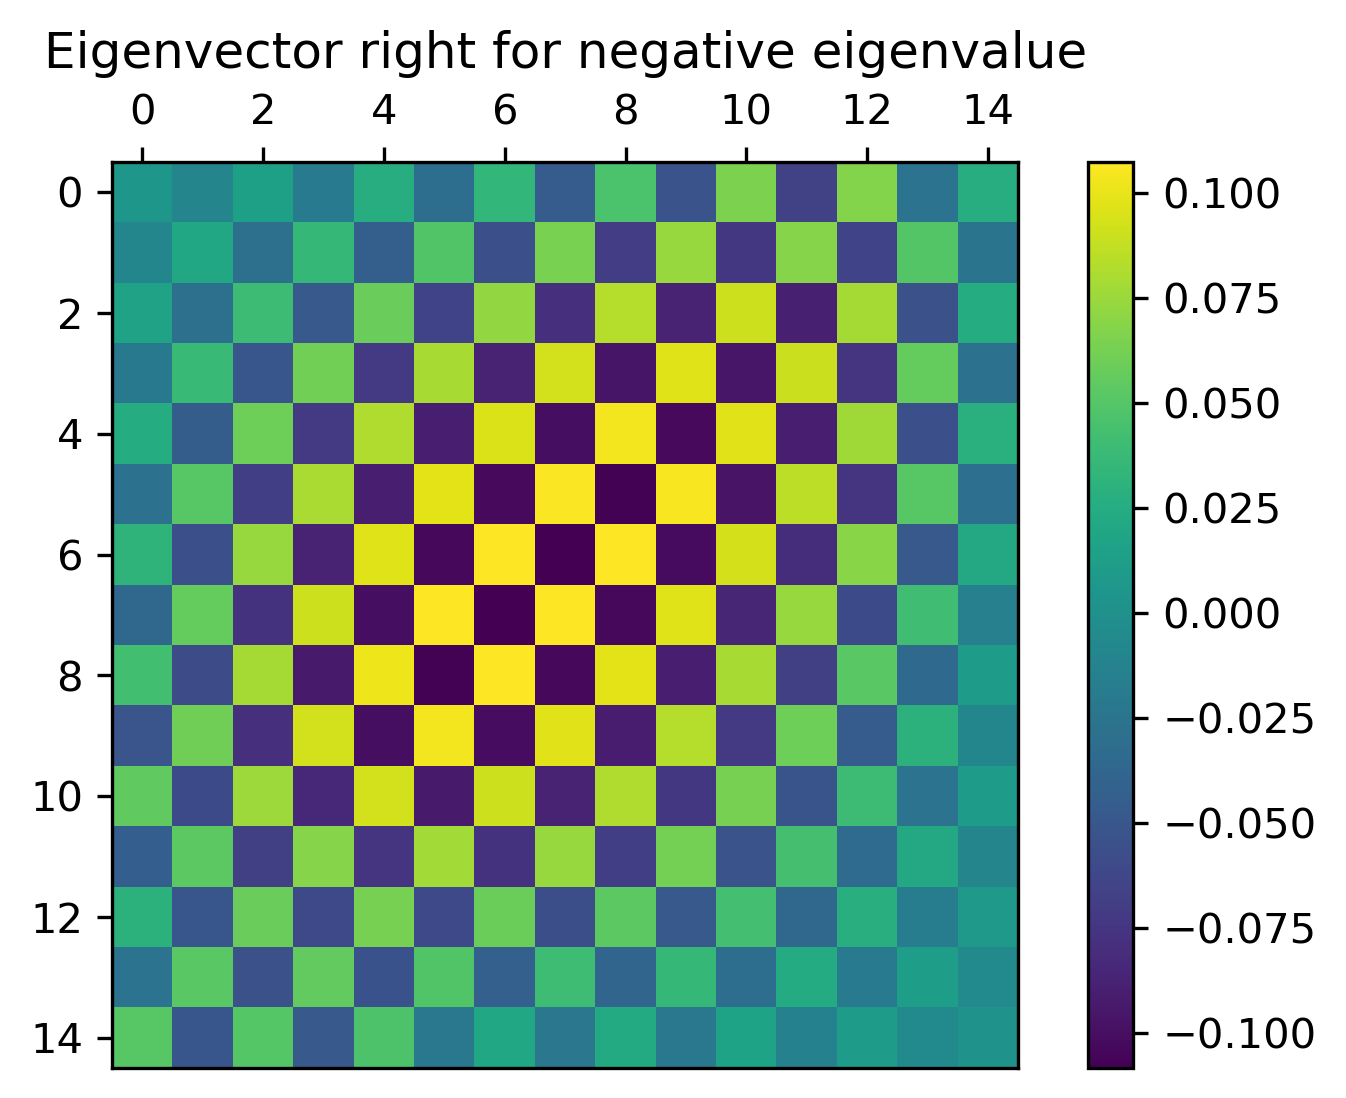

<Figure size 1800x1200 with 0 Axes>

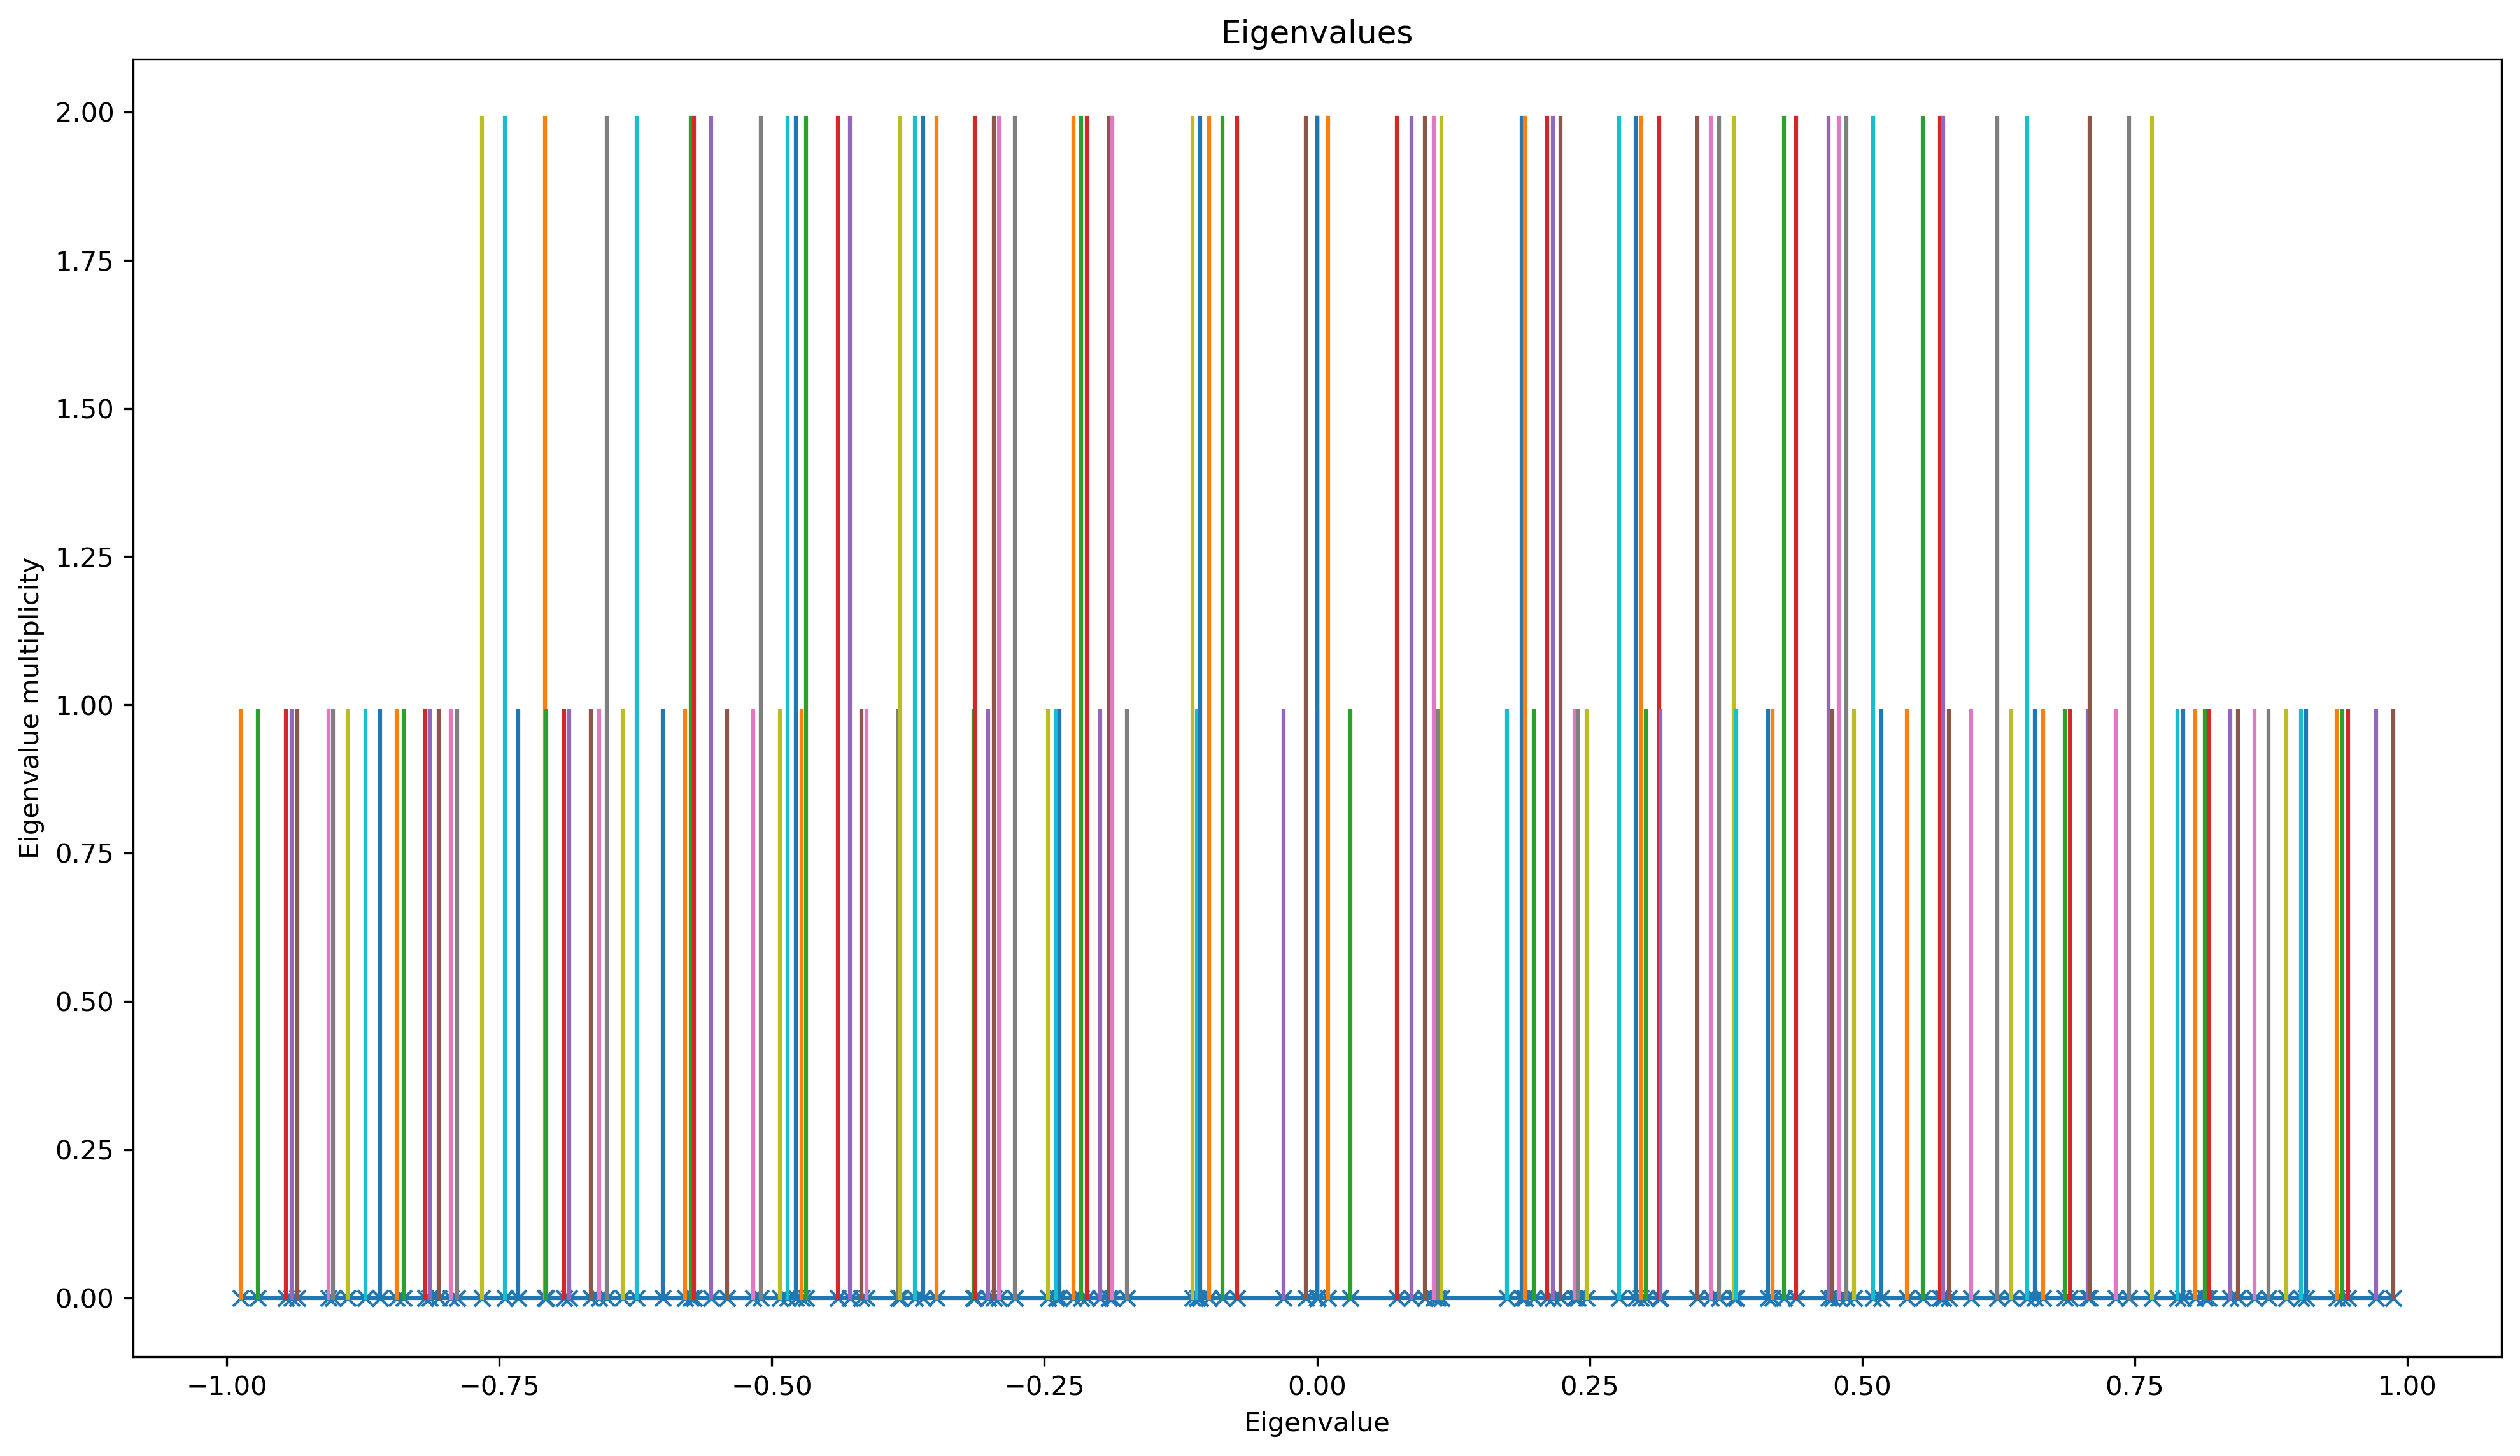

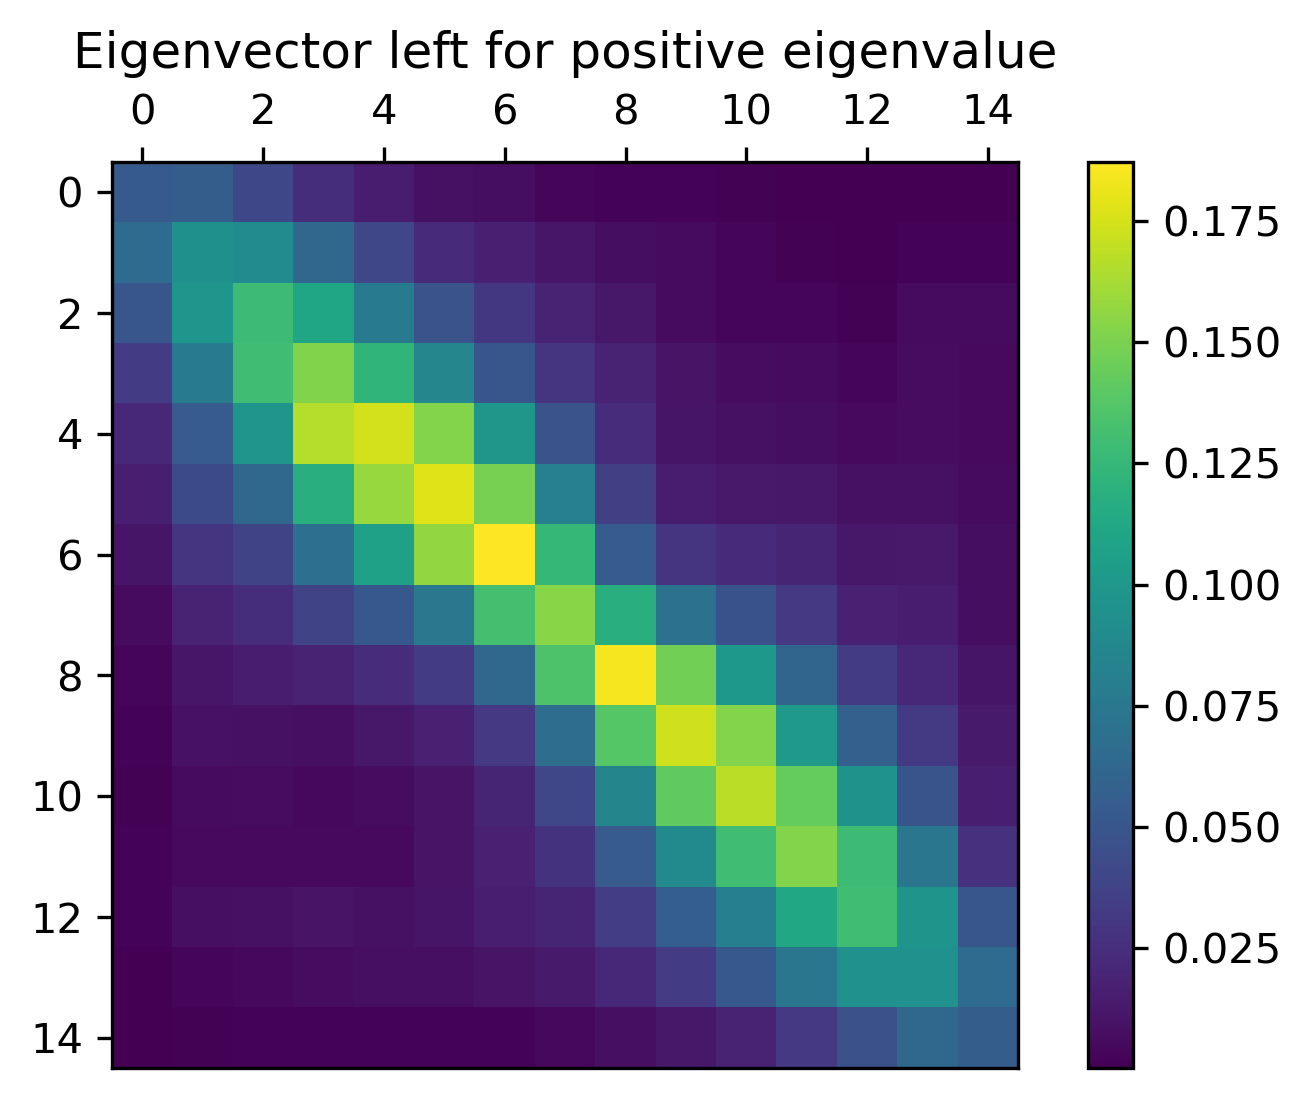

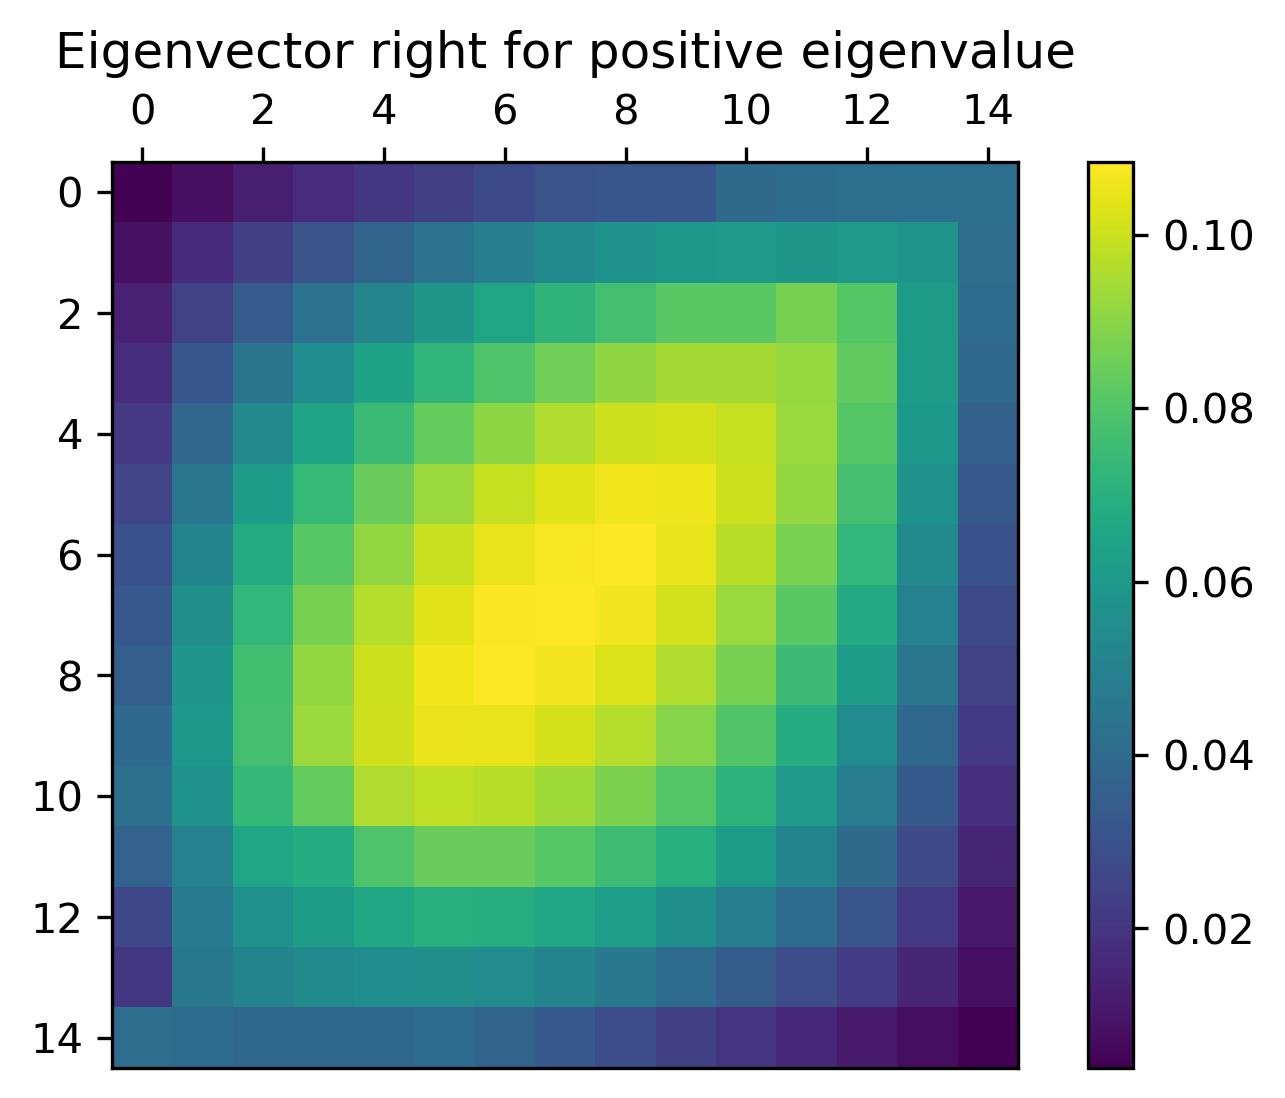

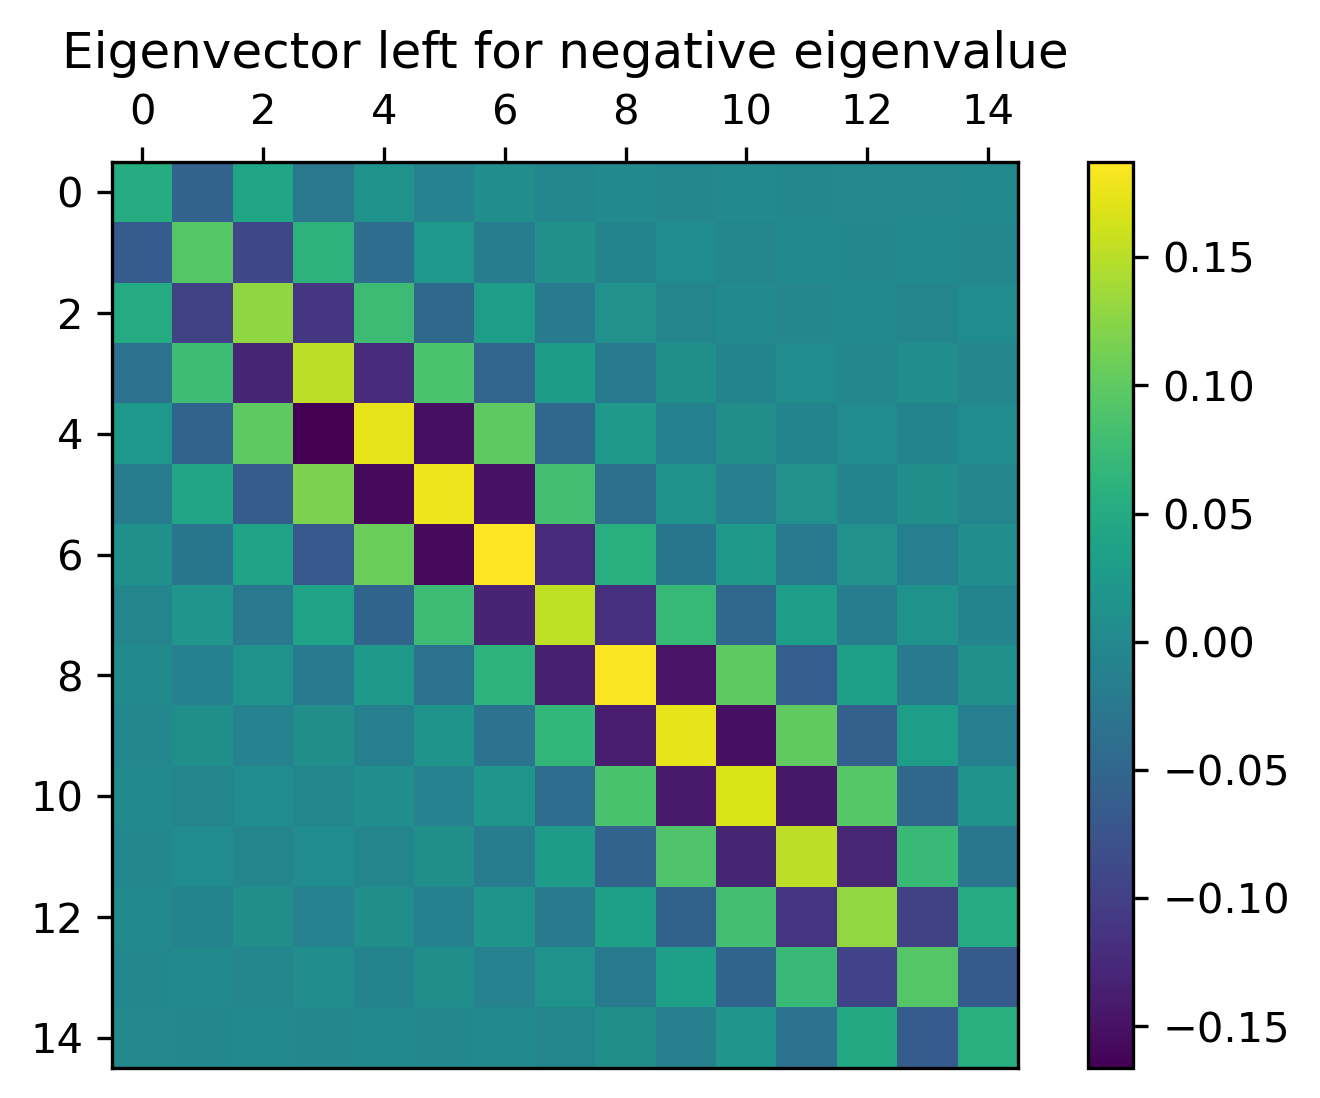

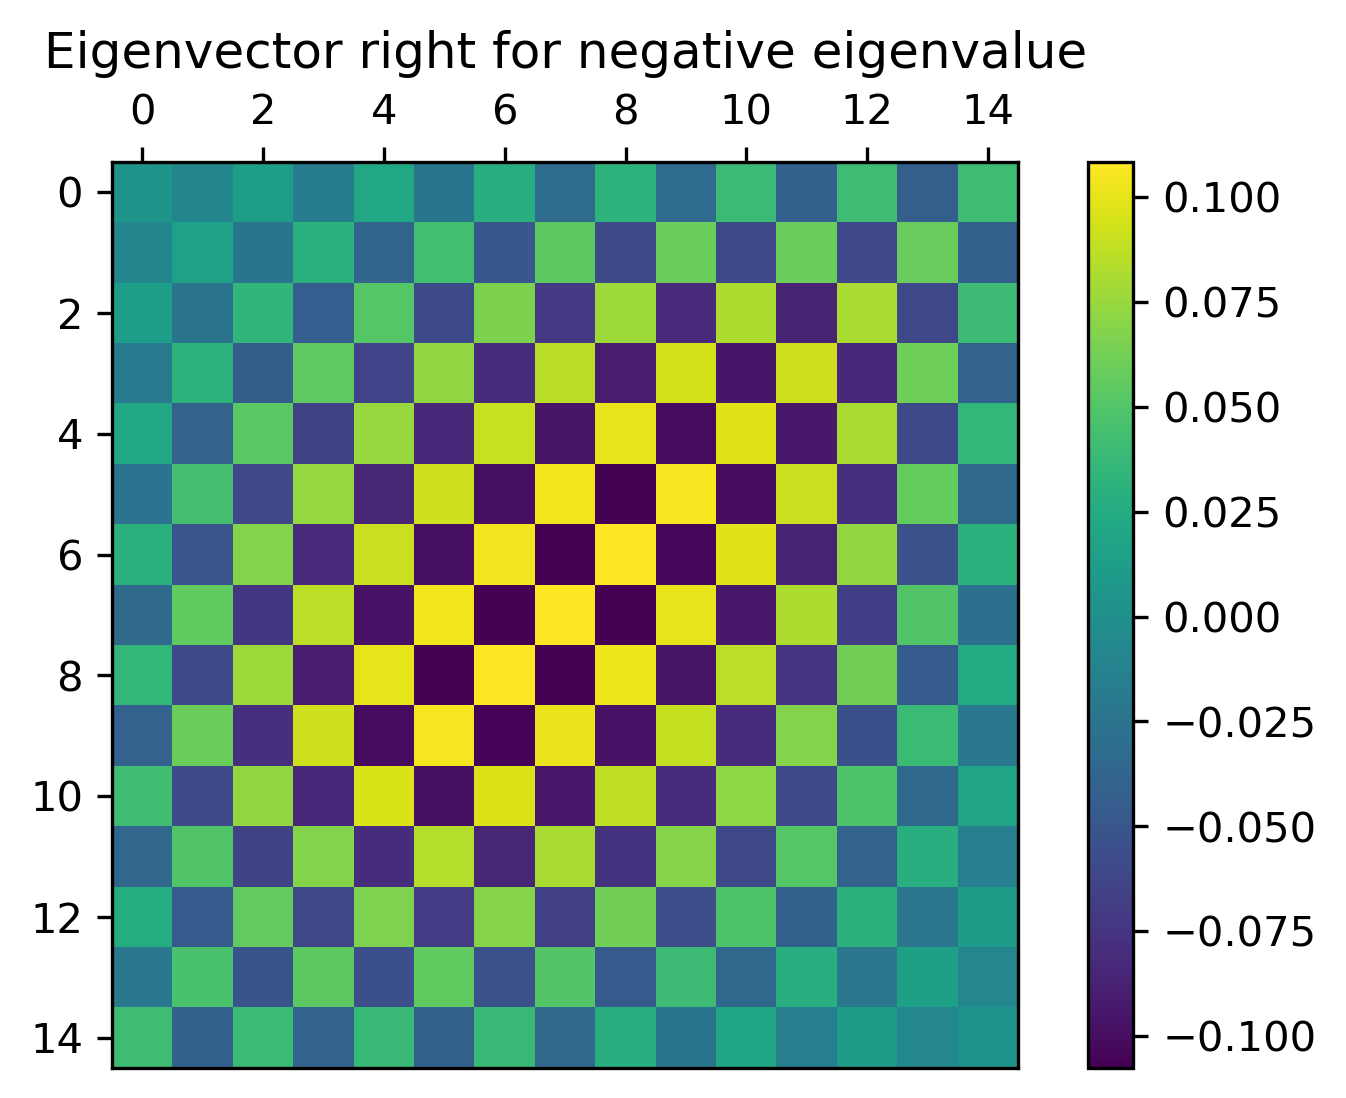

<Figure size 1800x1200 with 0 Axes>

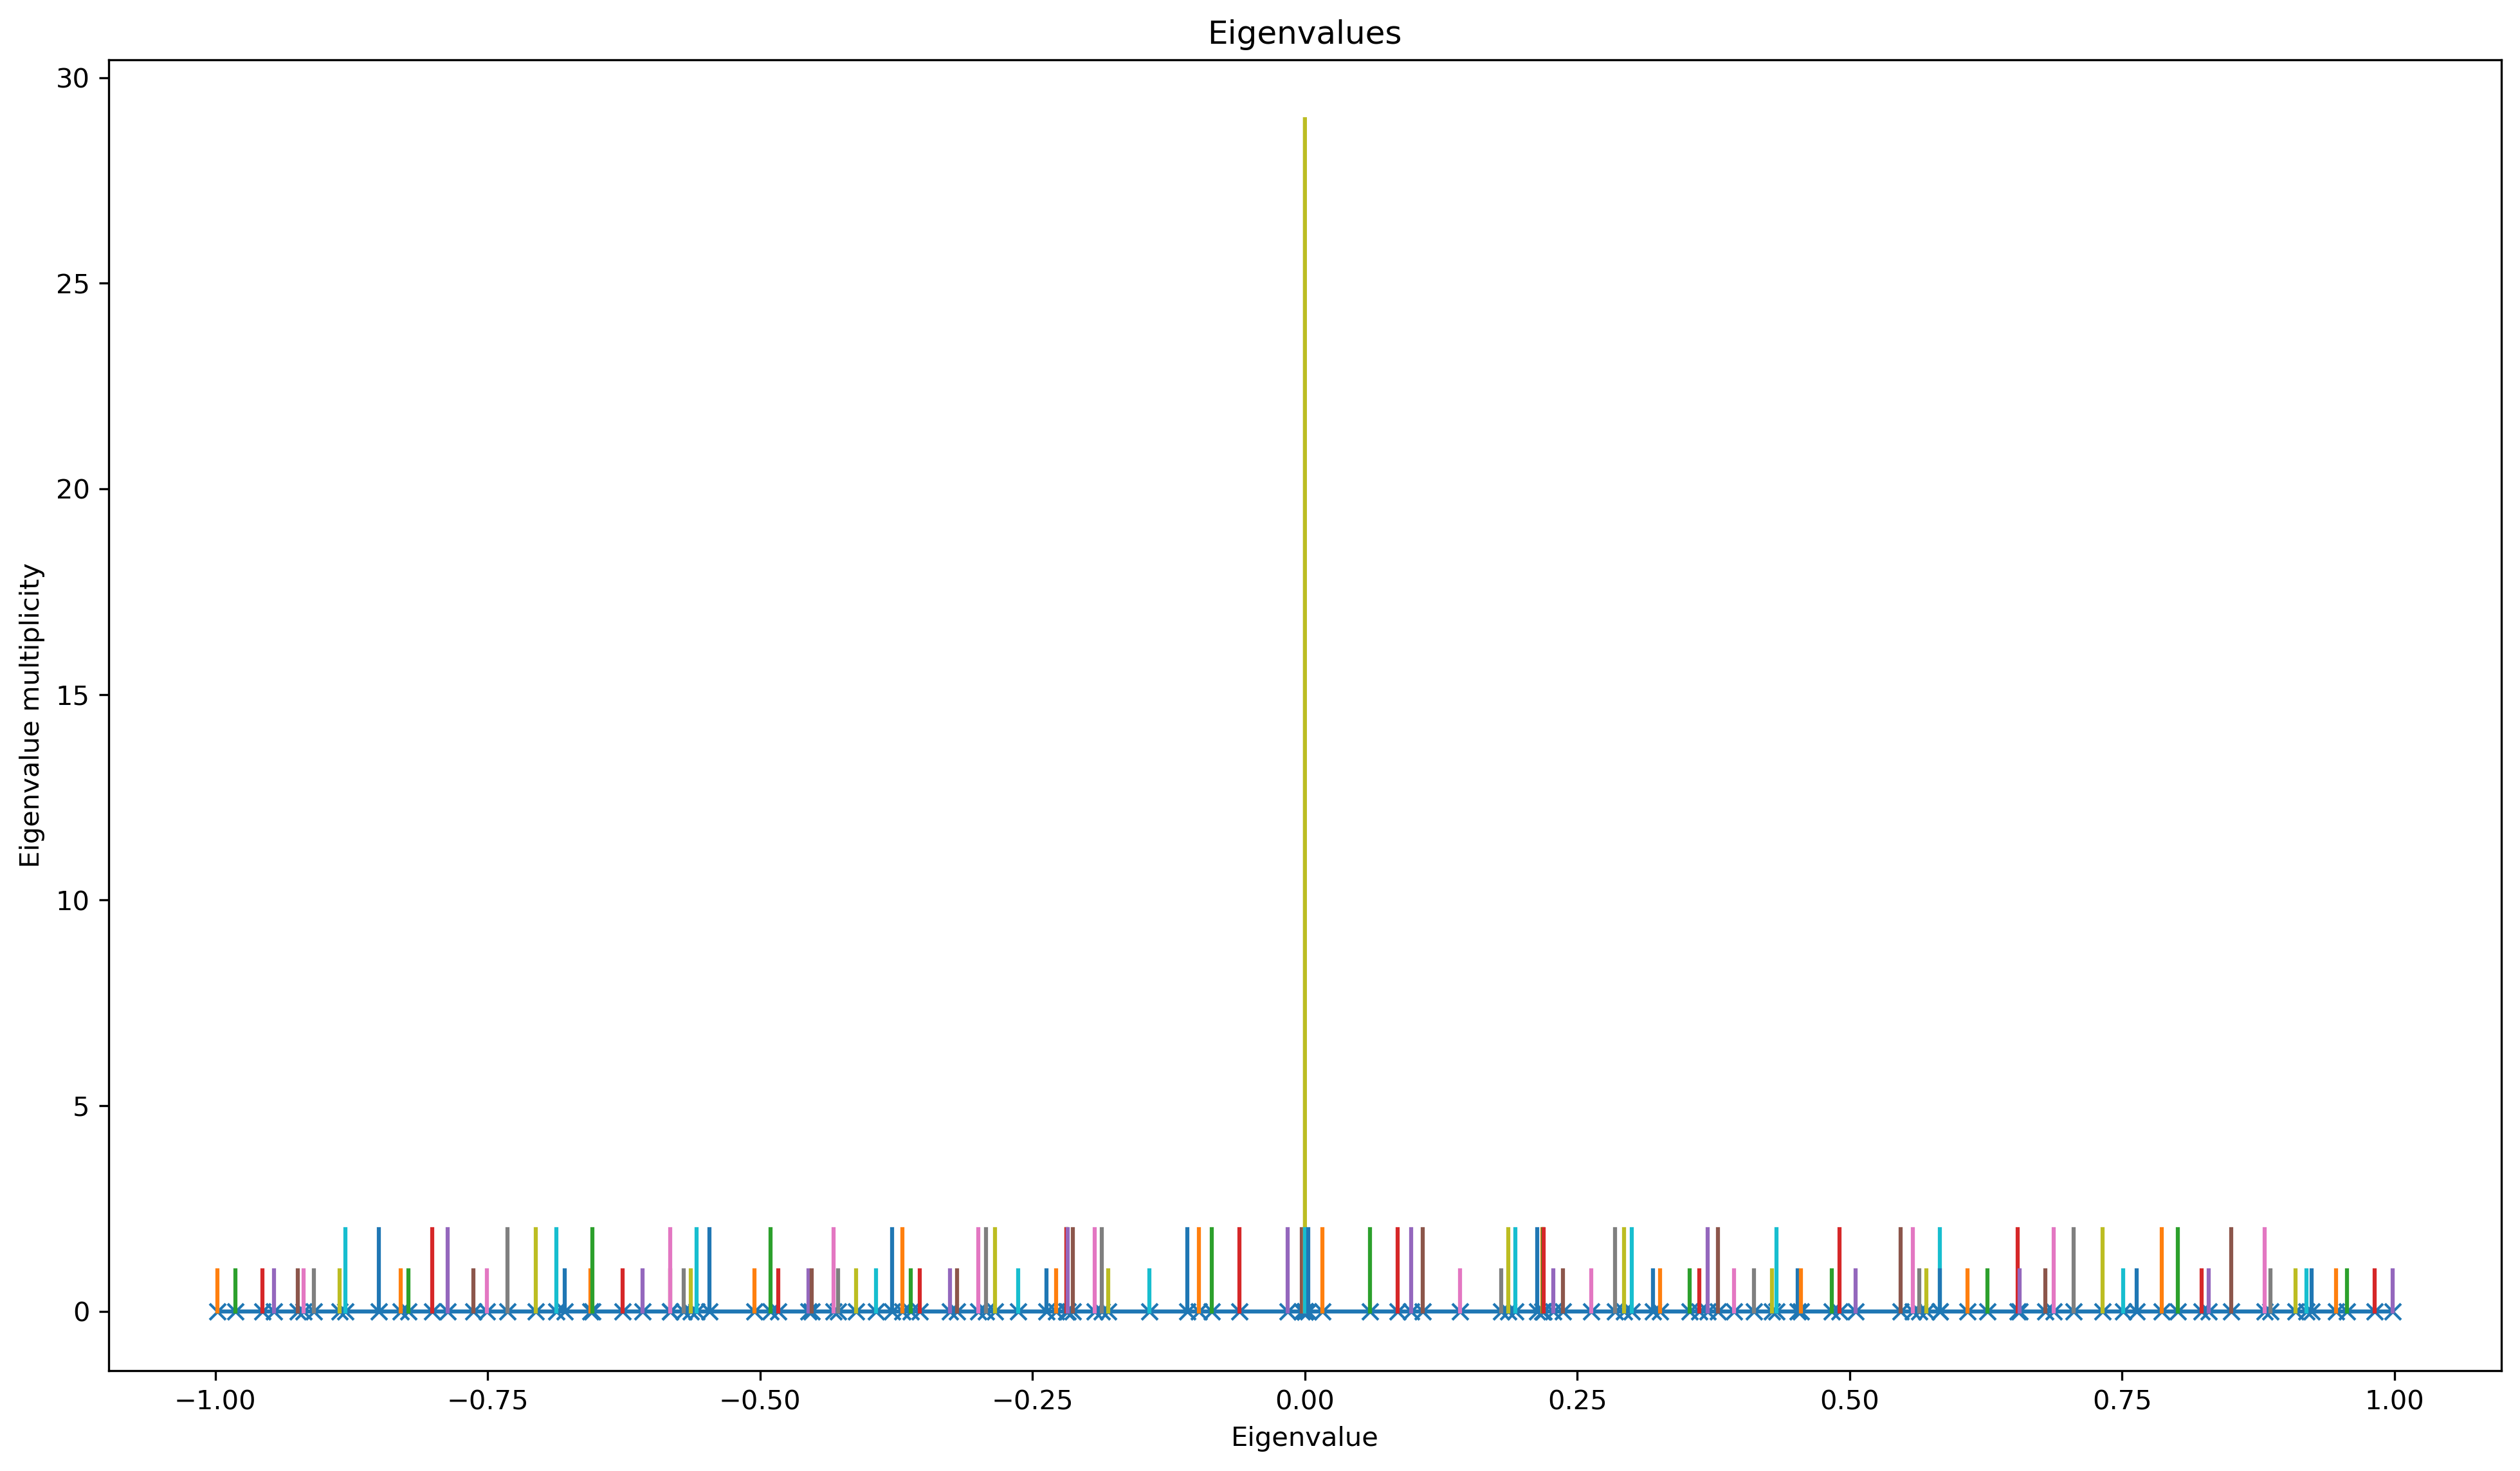

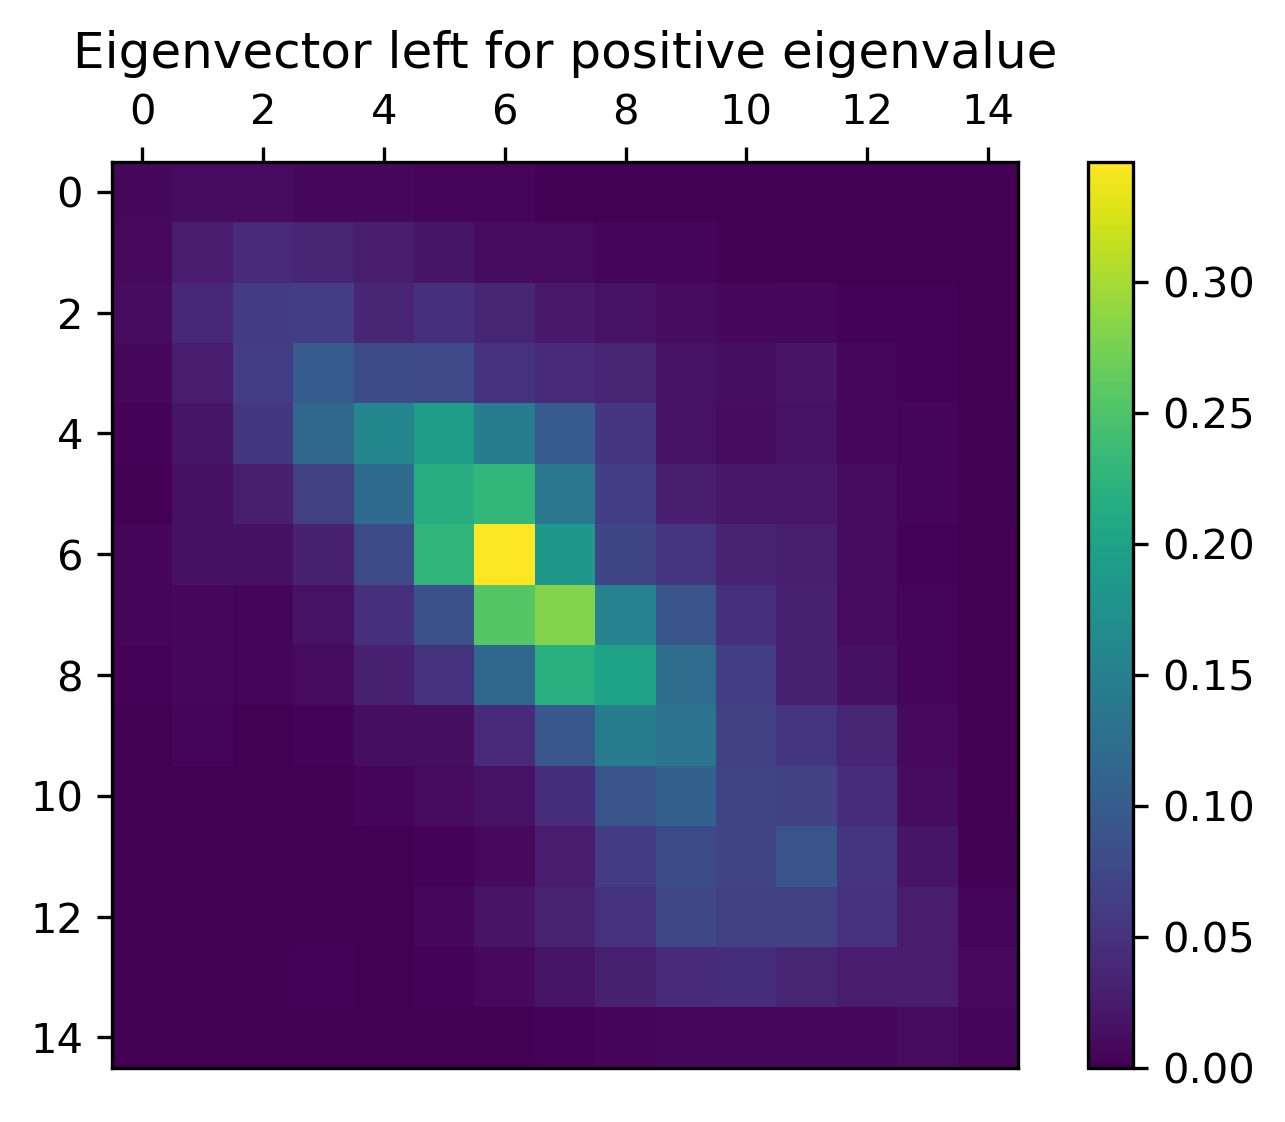

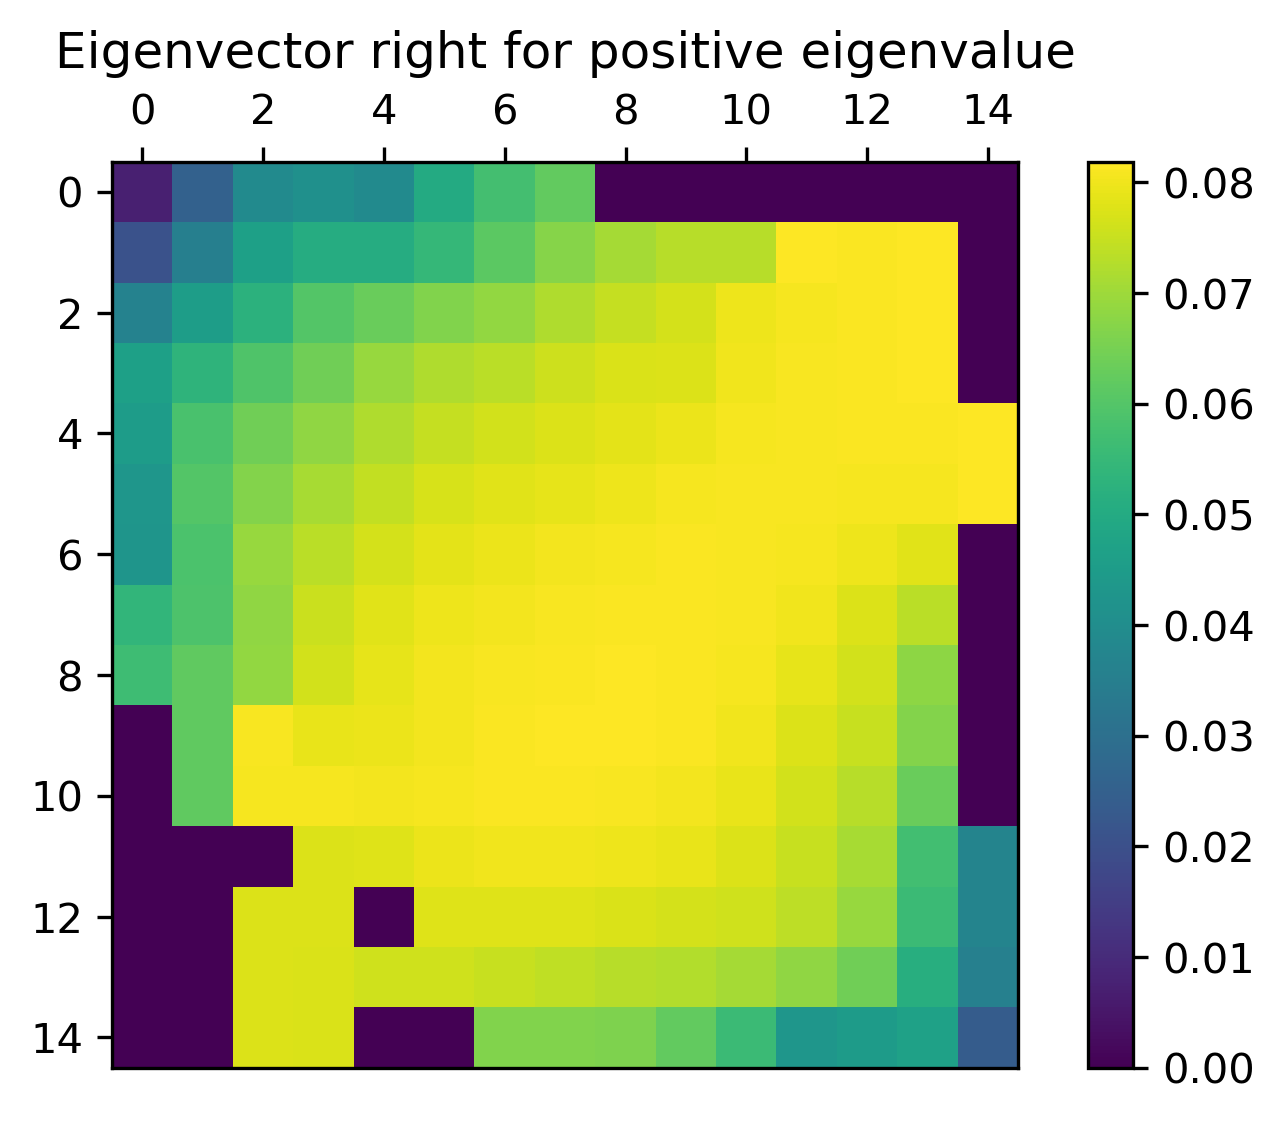

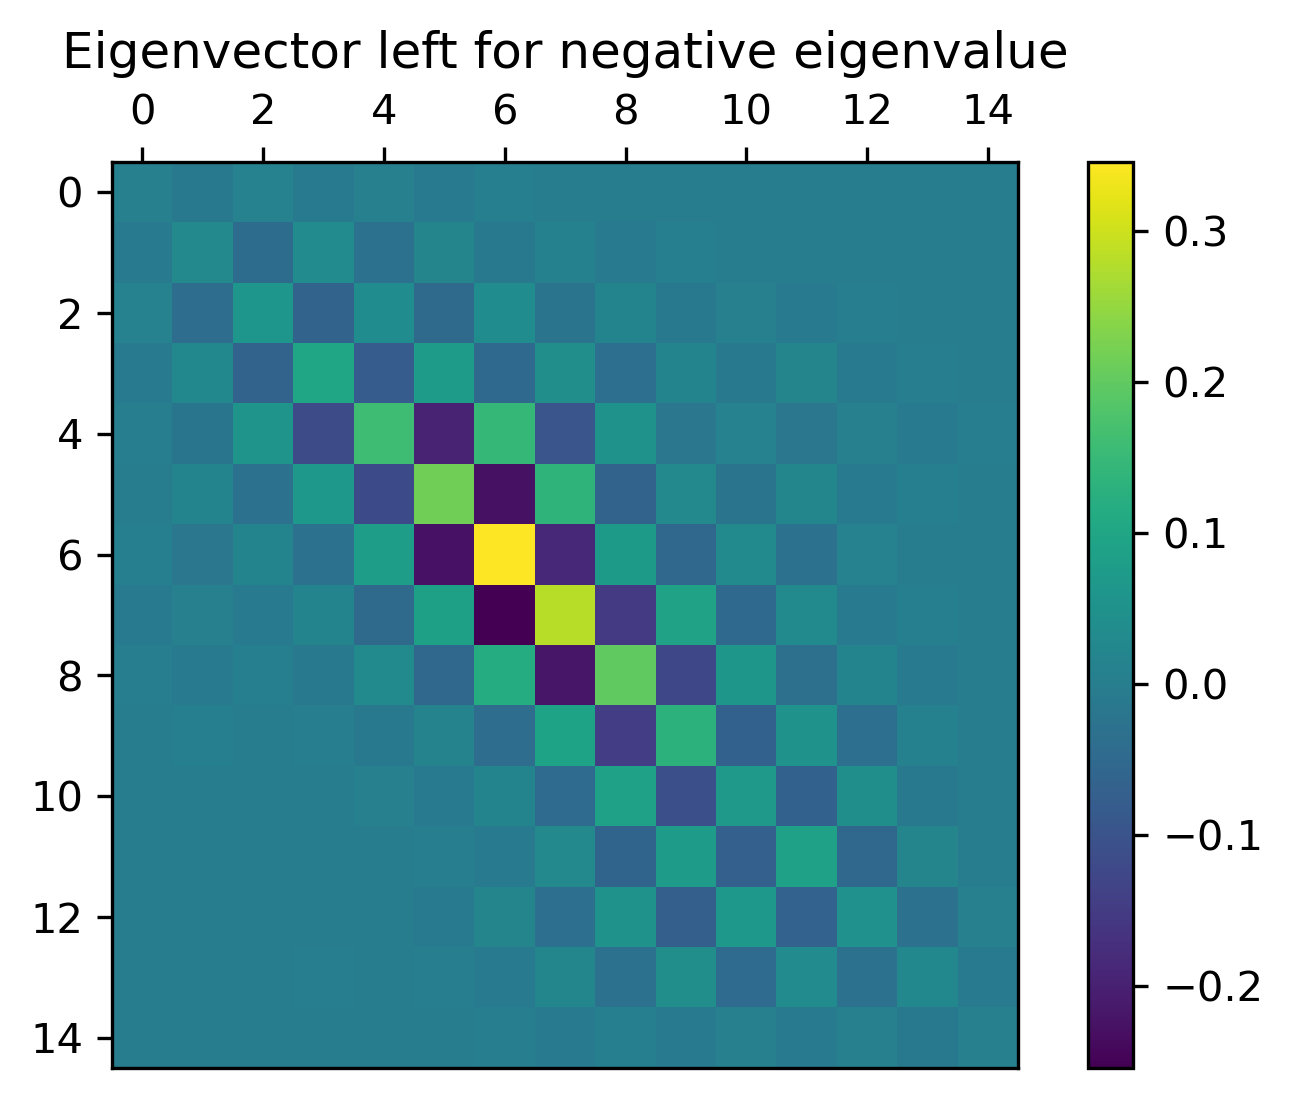

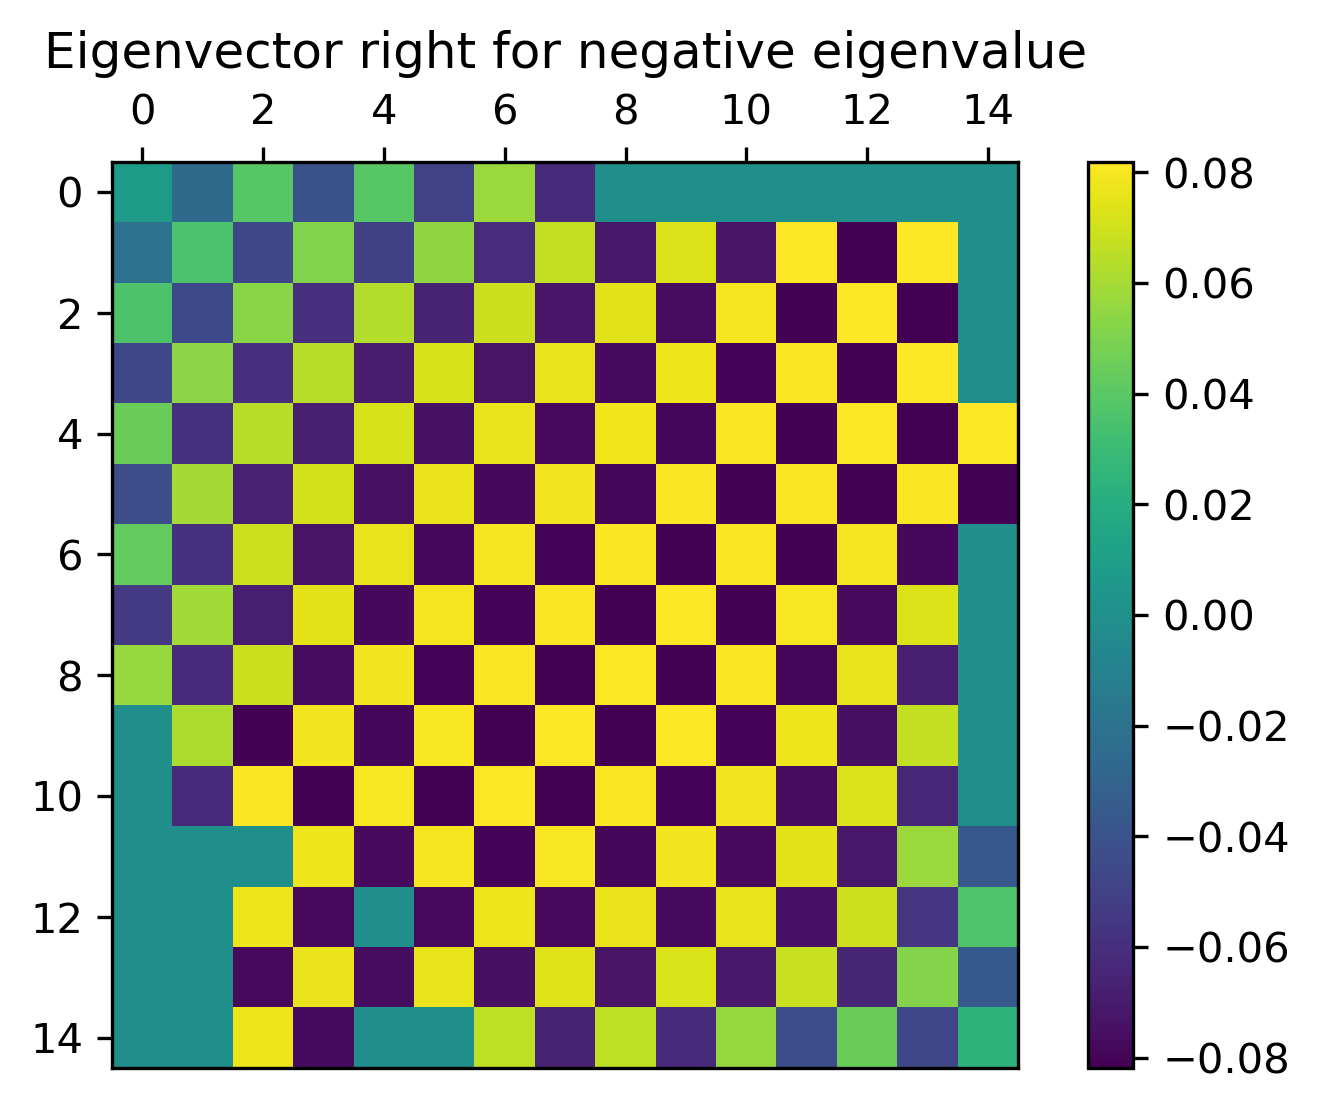

<Figure size 1800x1200 with 0 Axes>

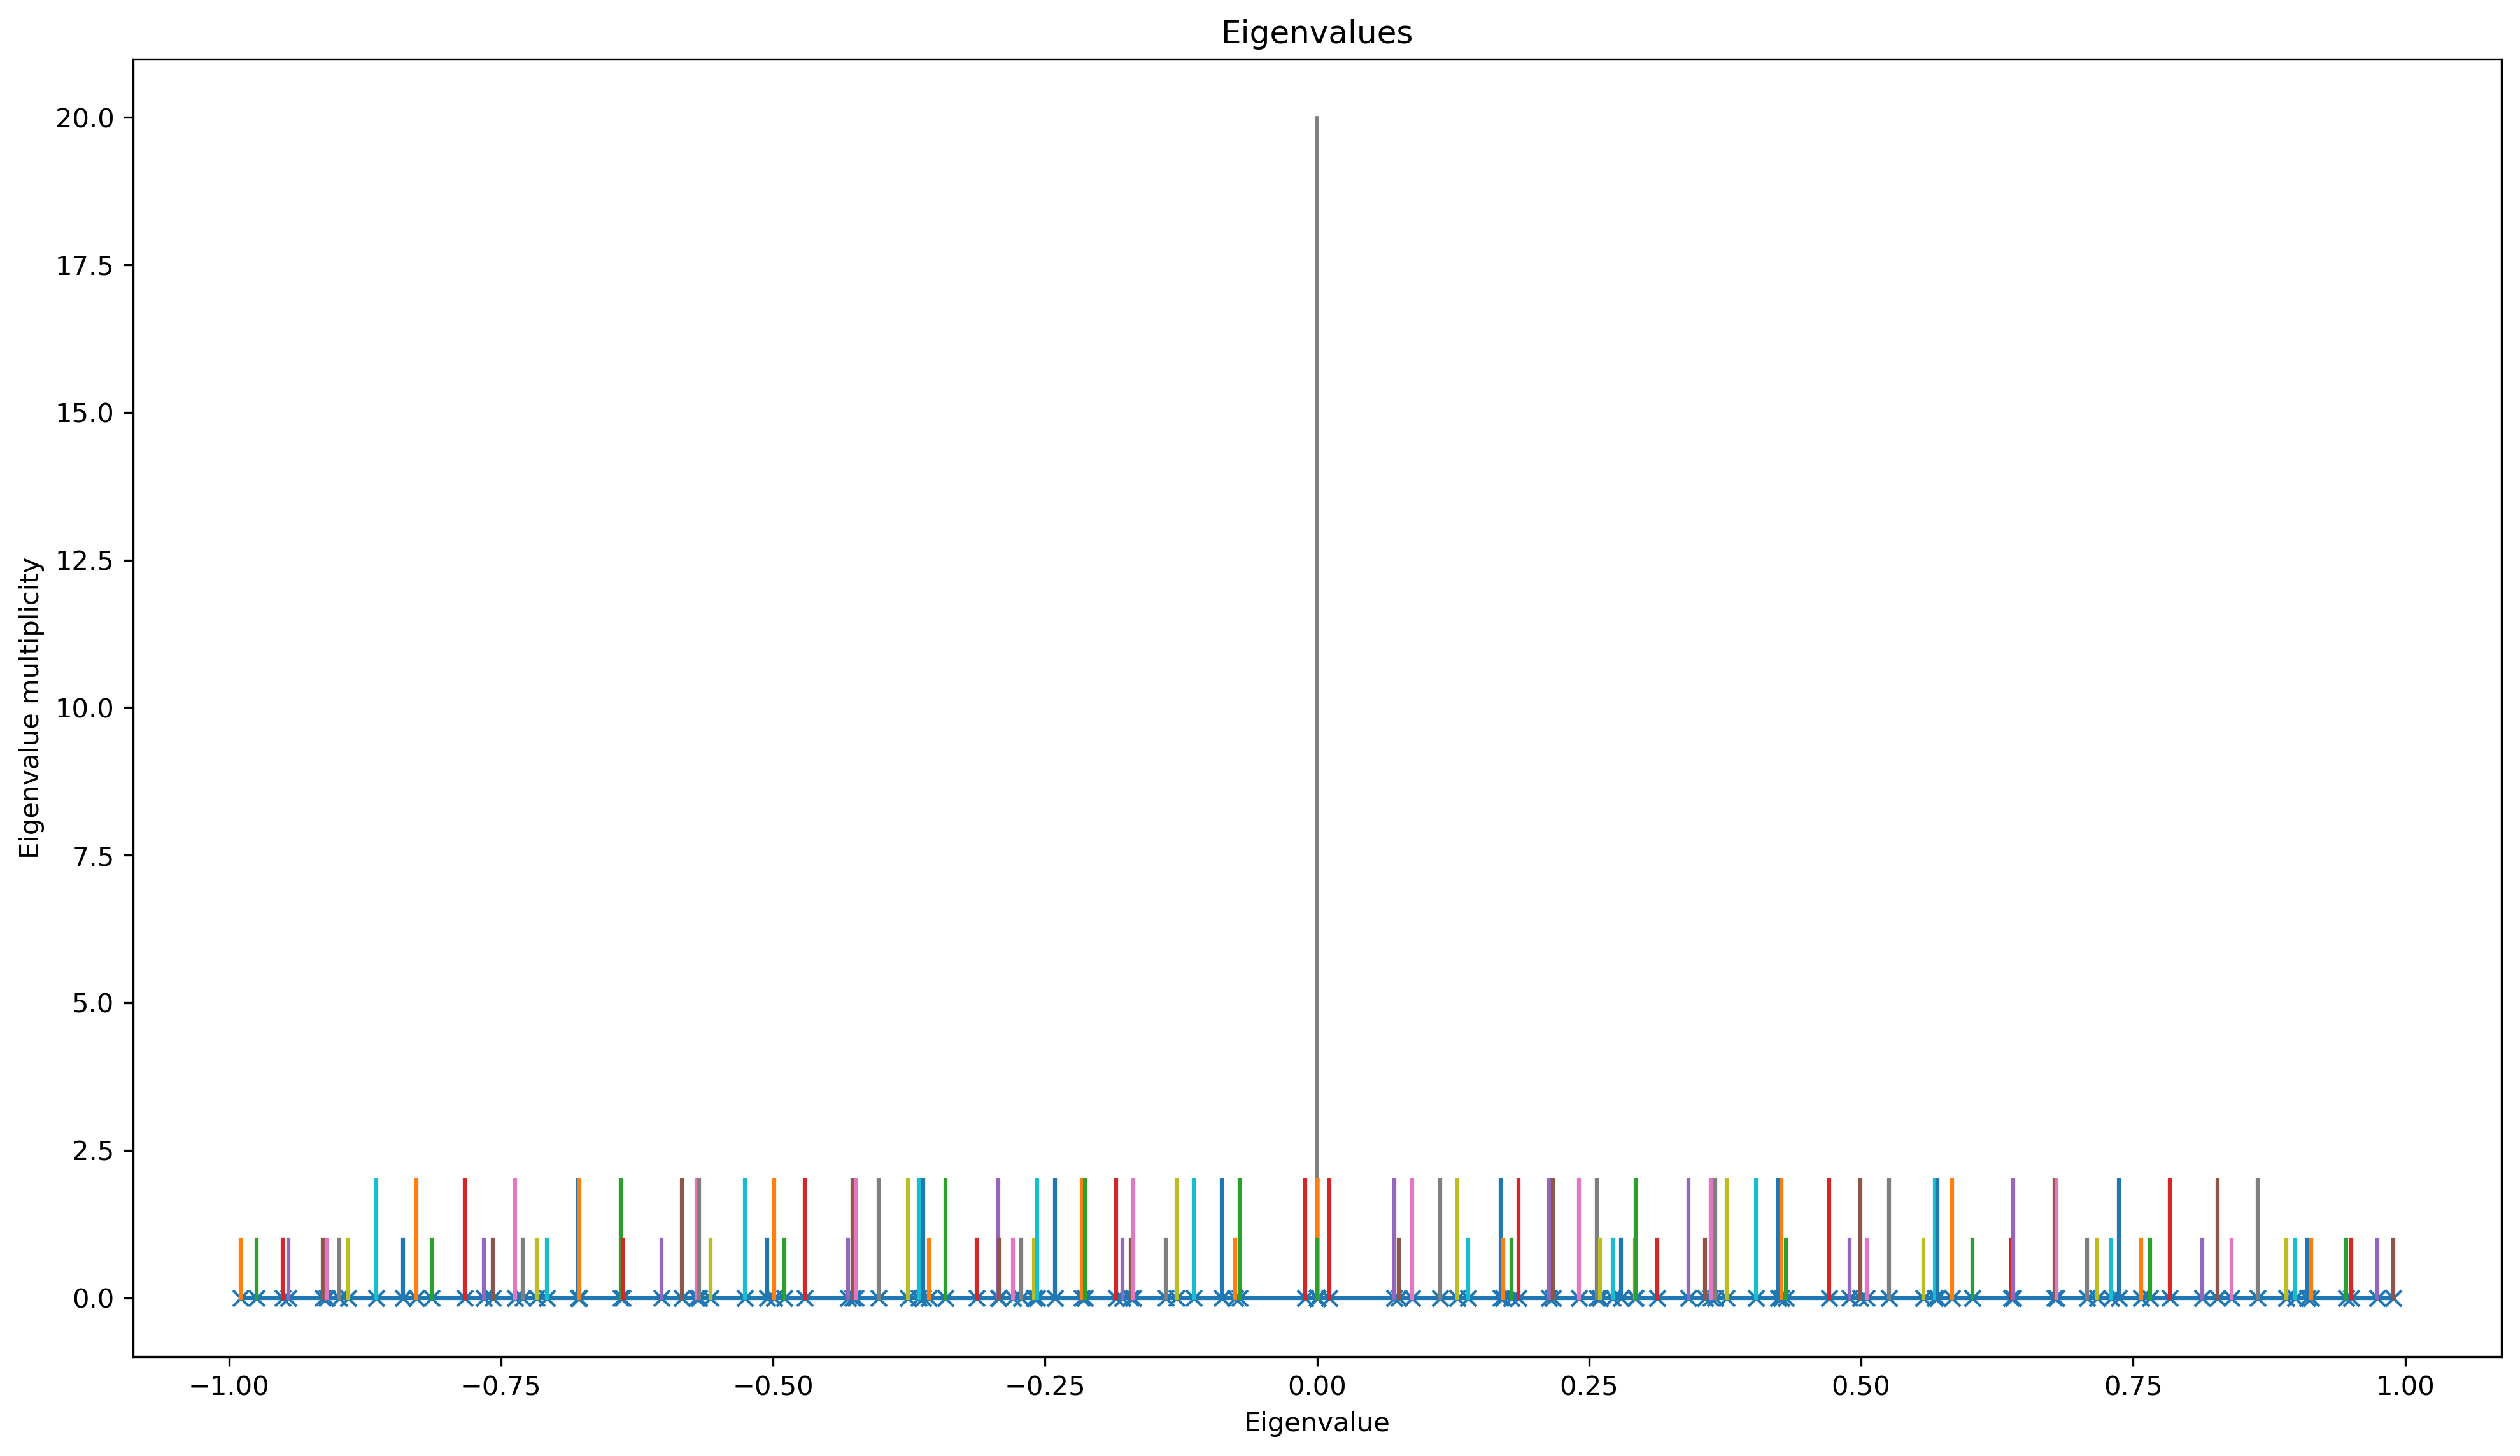

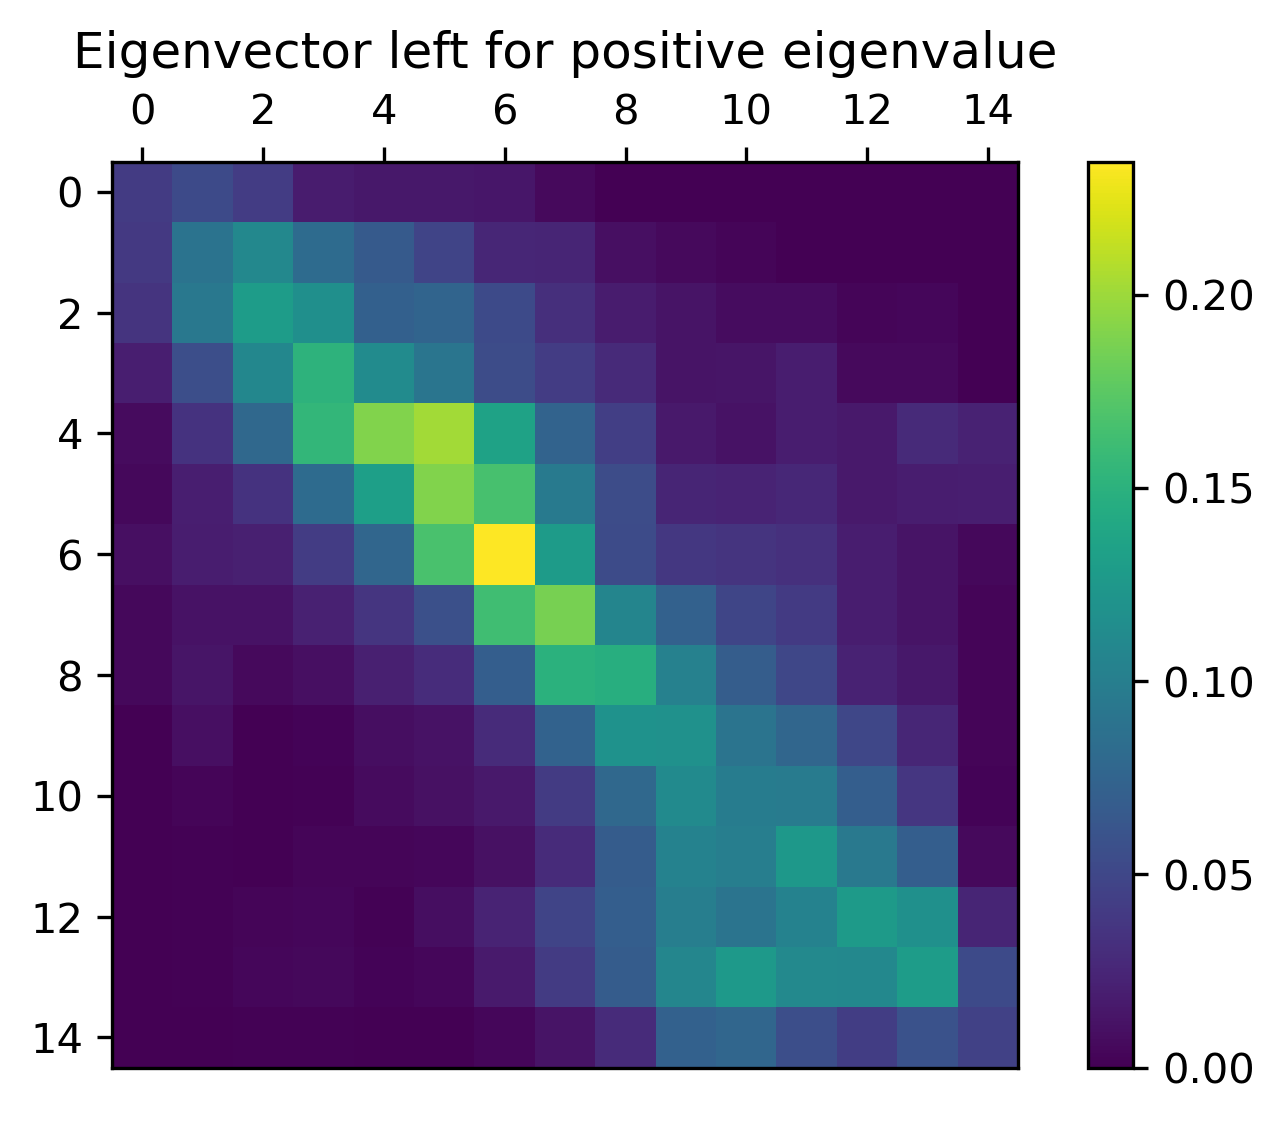

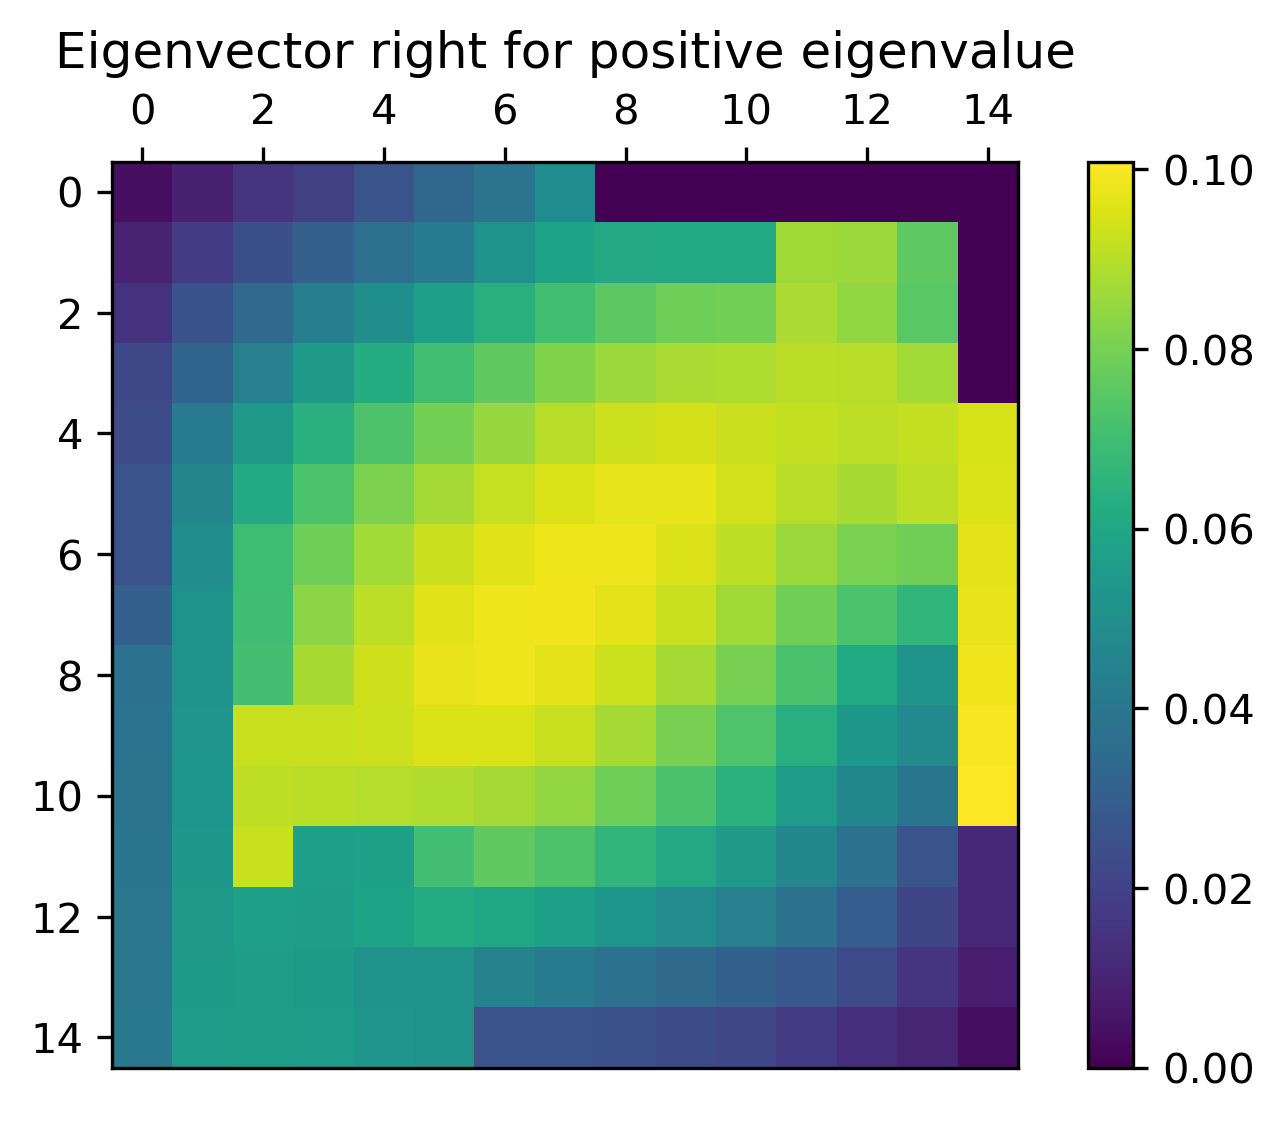

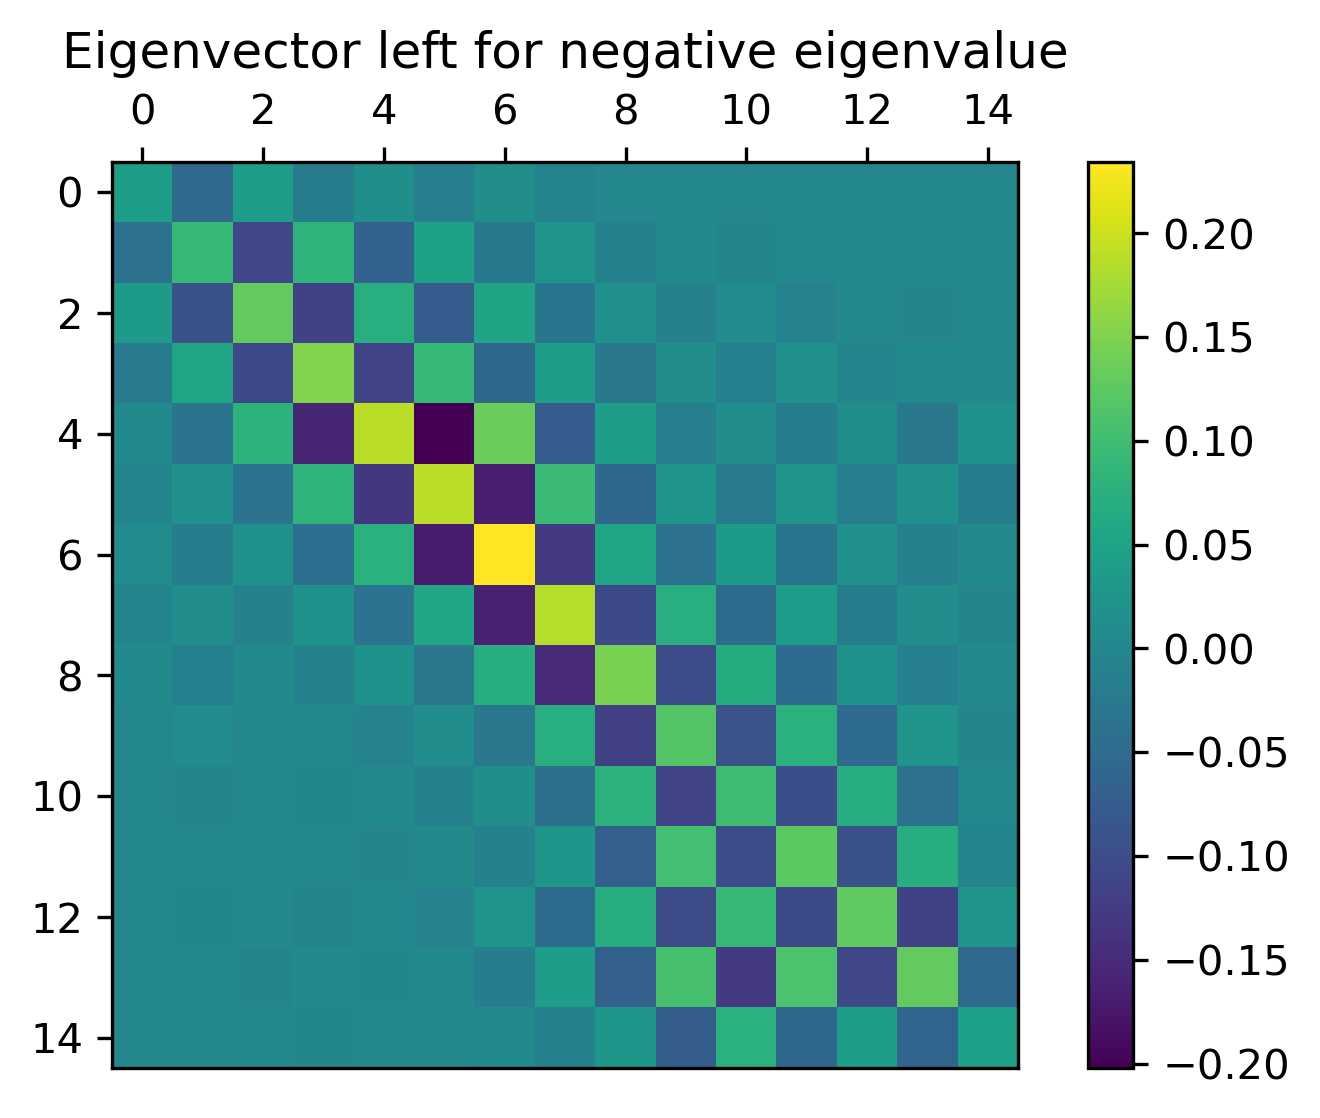

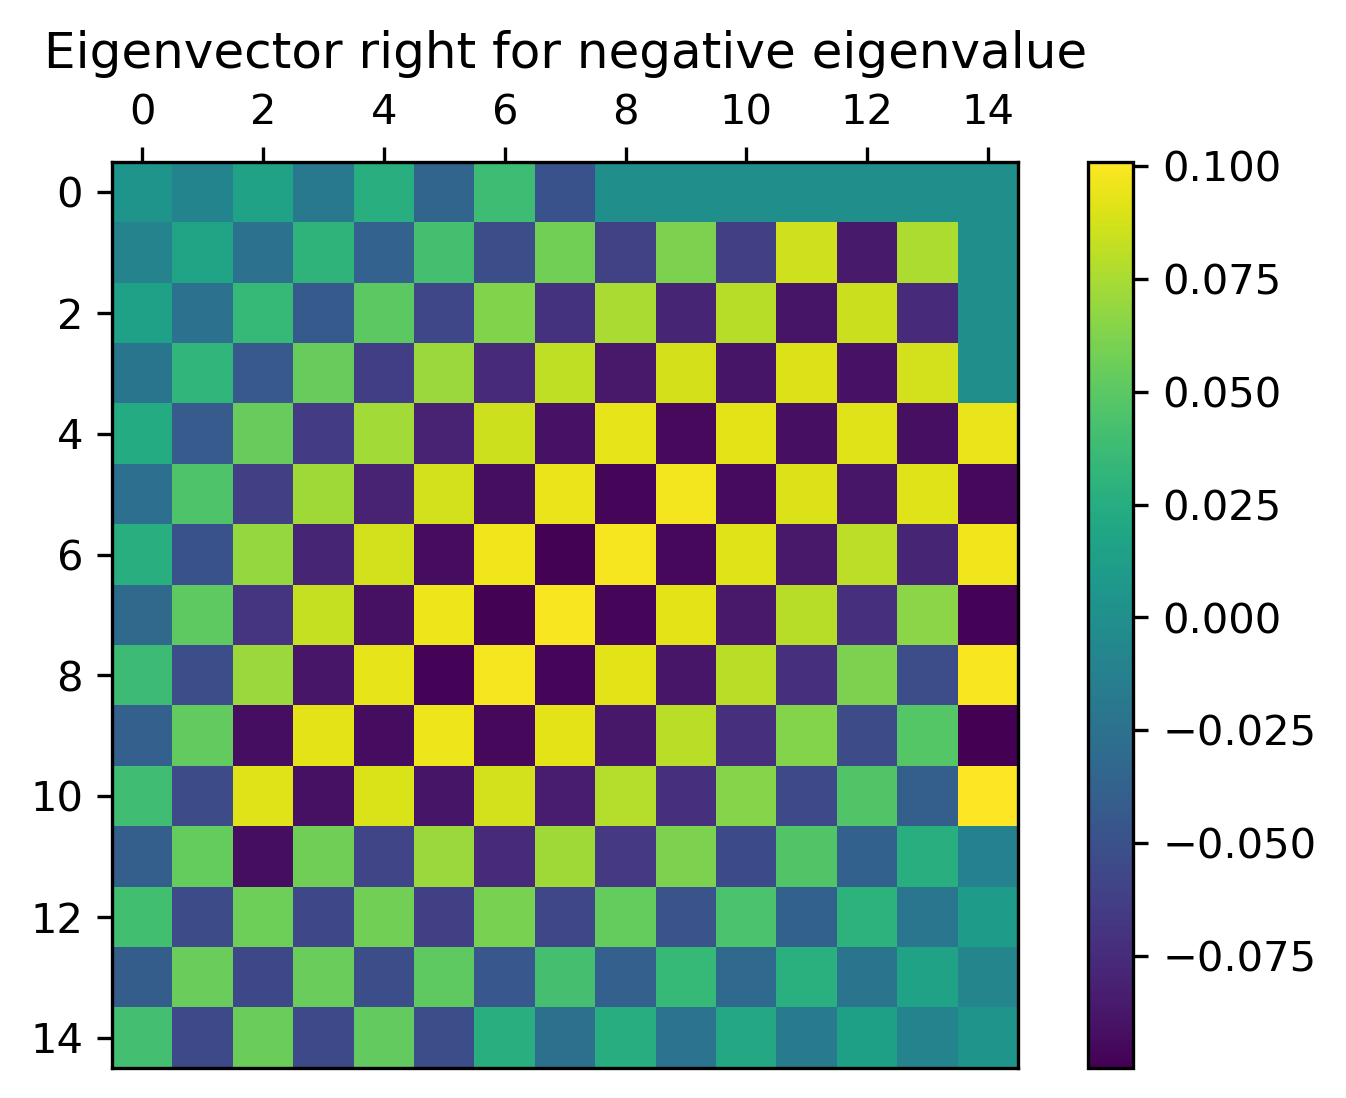

<Figure size 1800x1200 with 0 Axes>

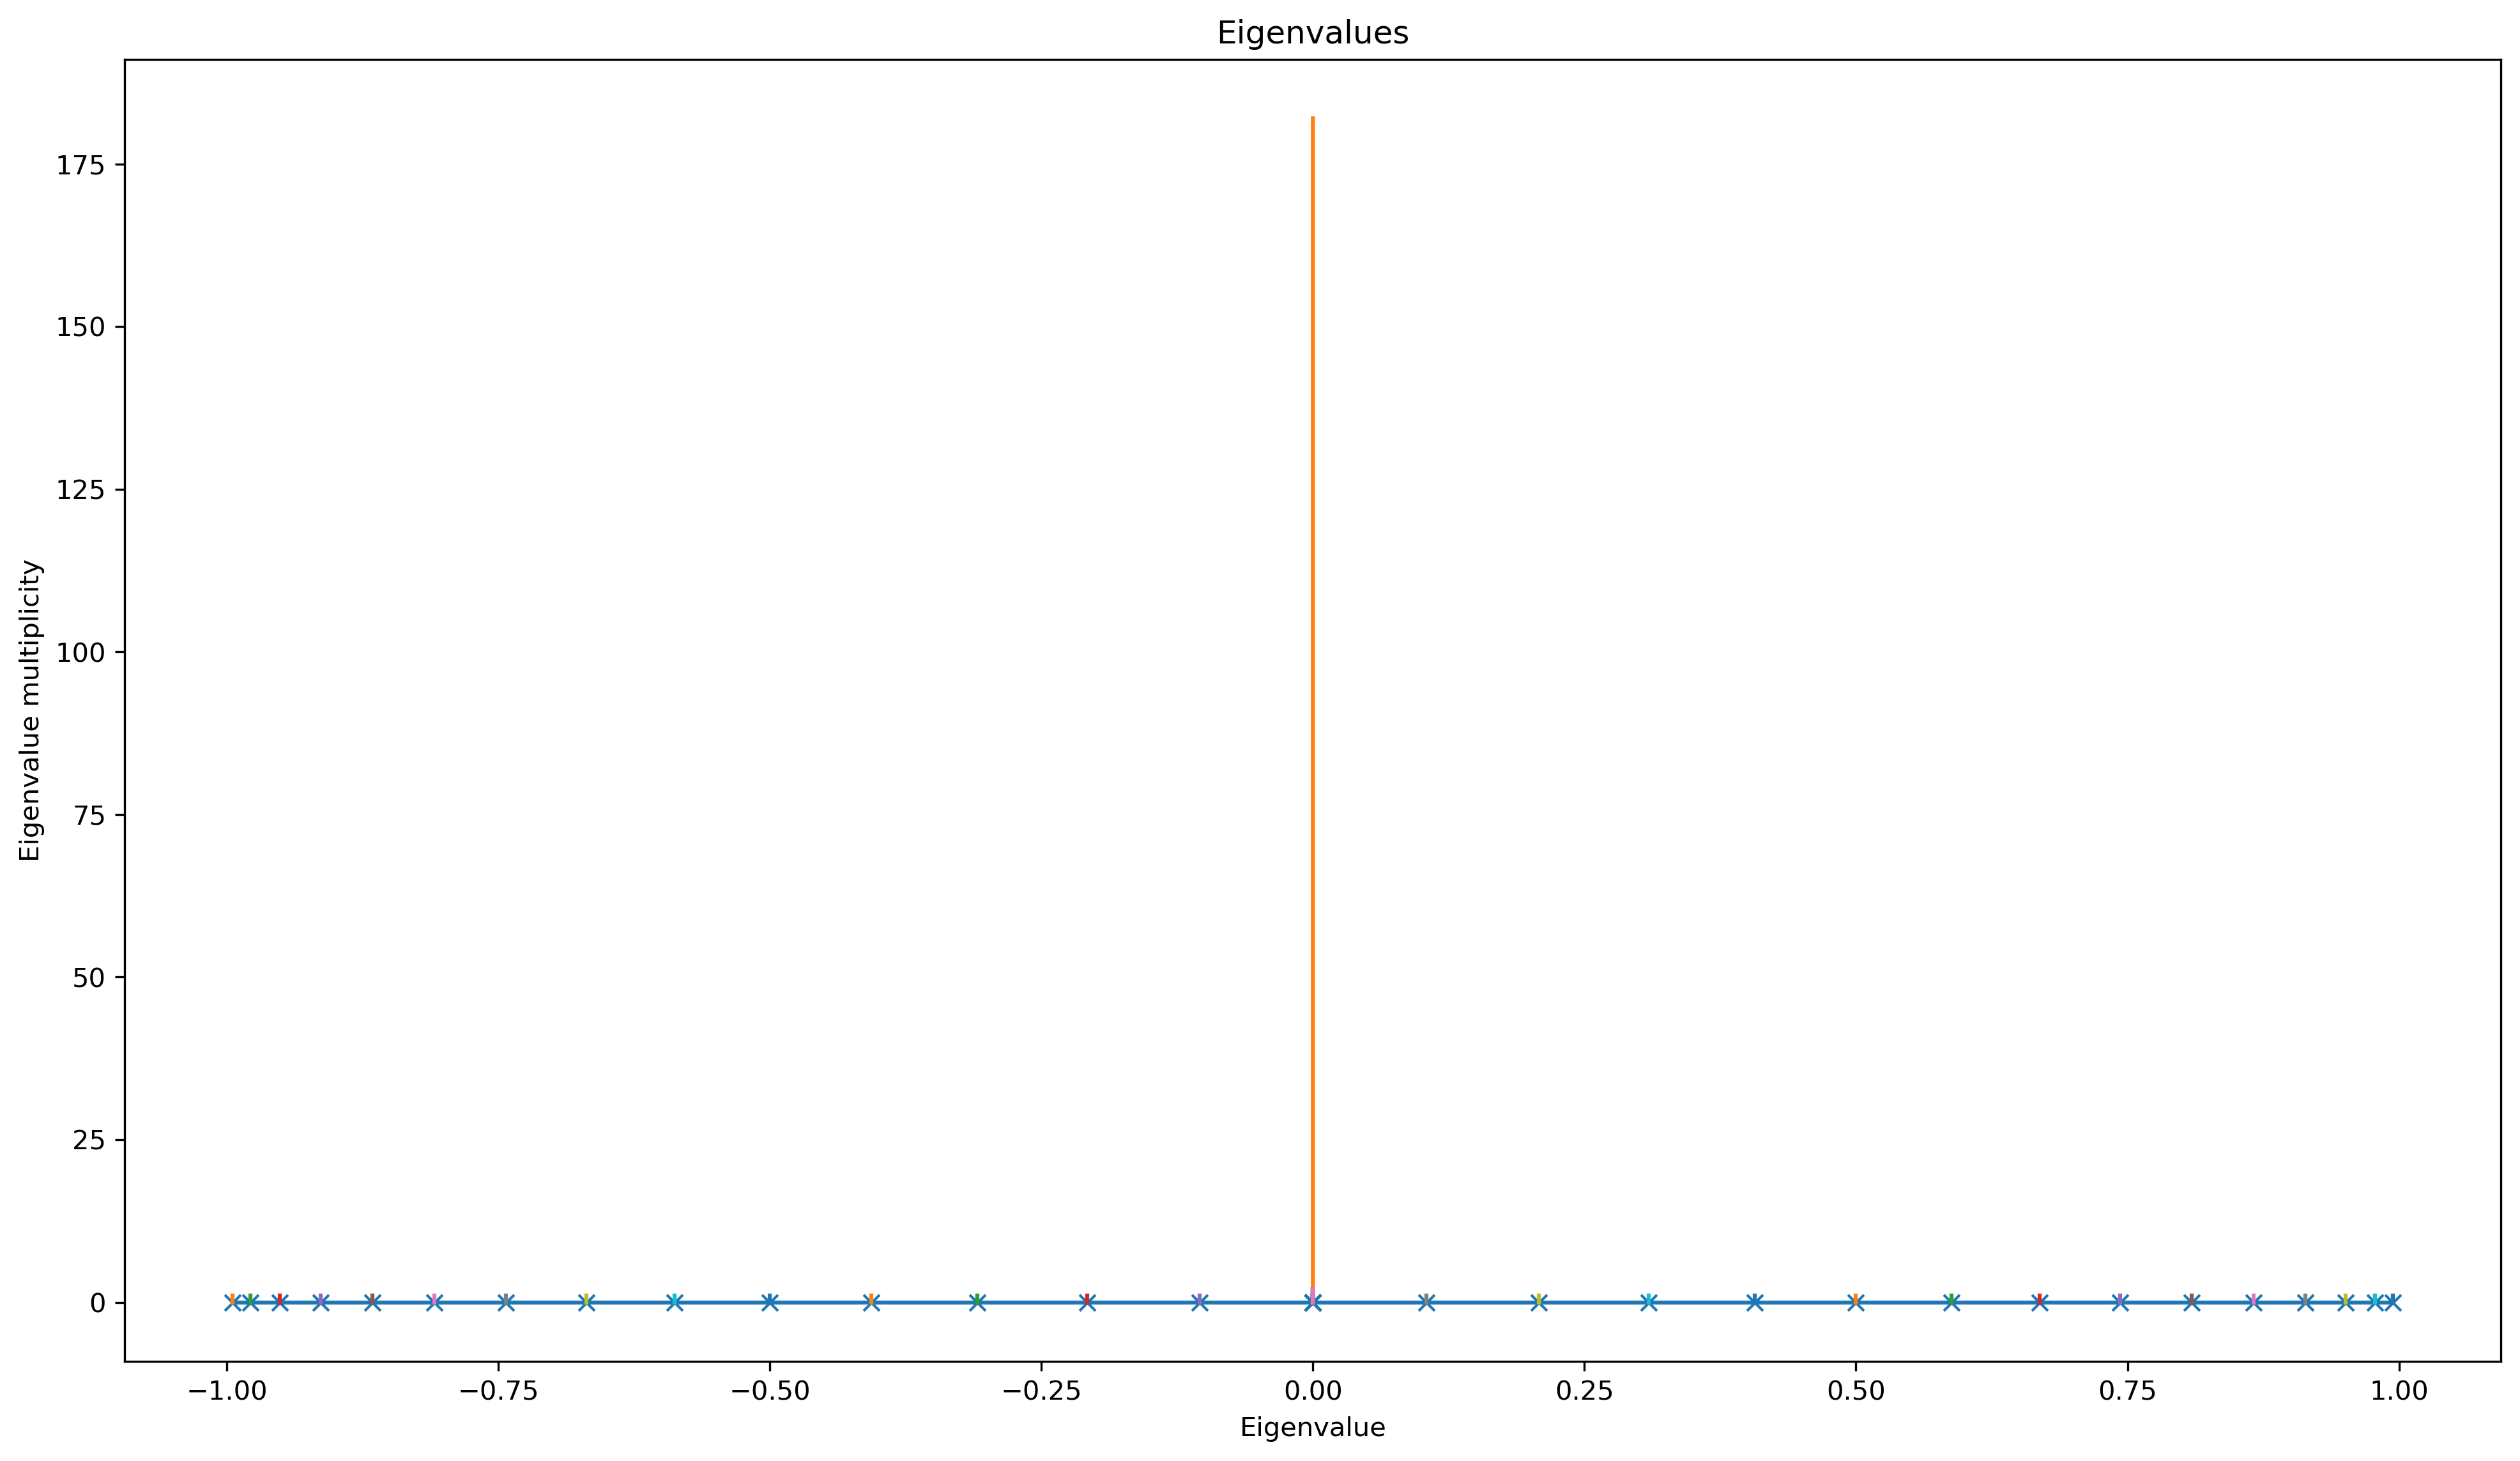

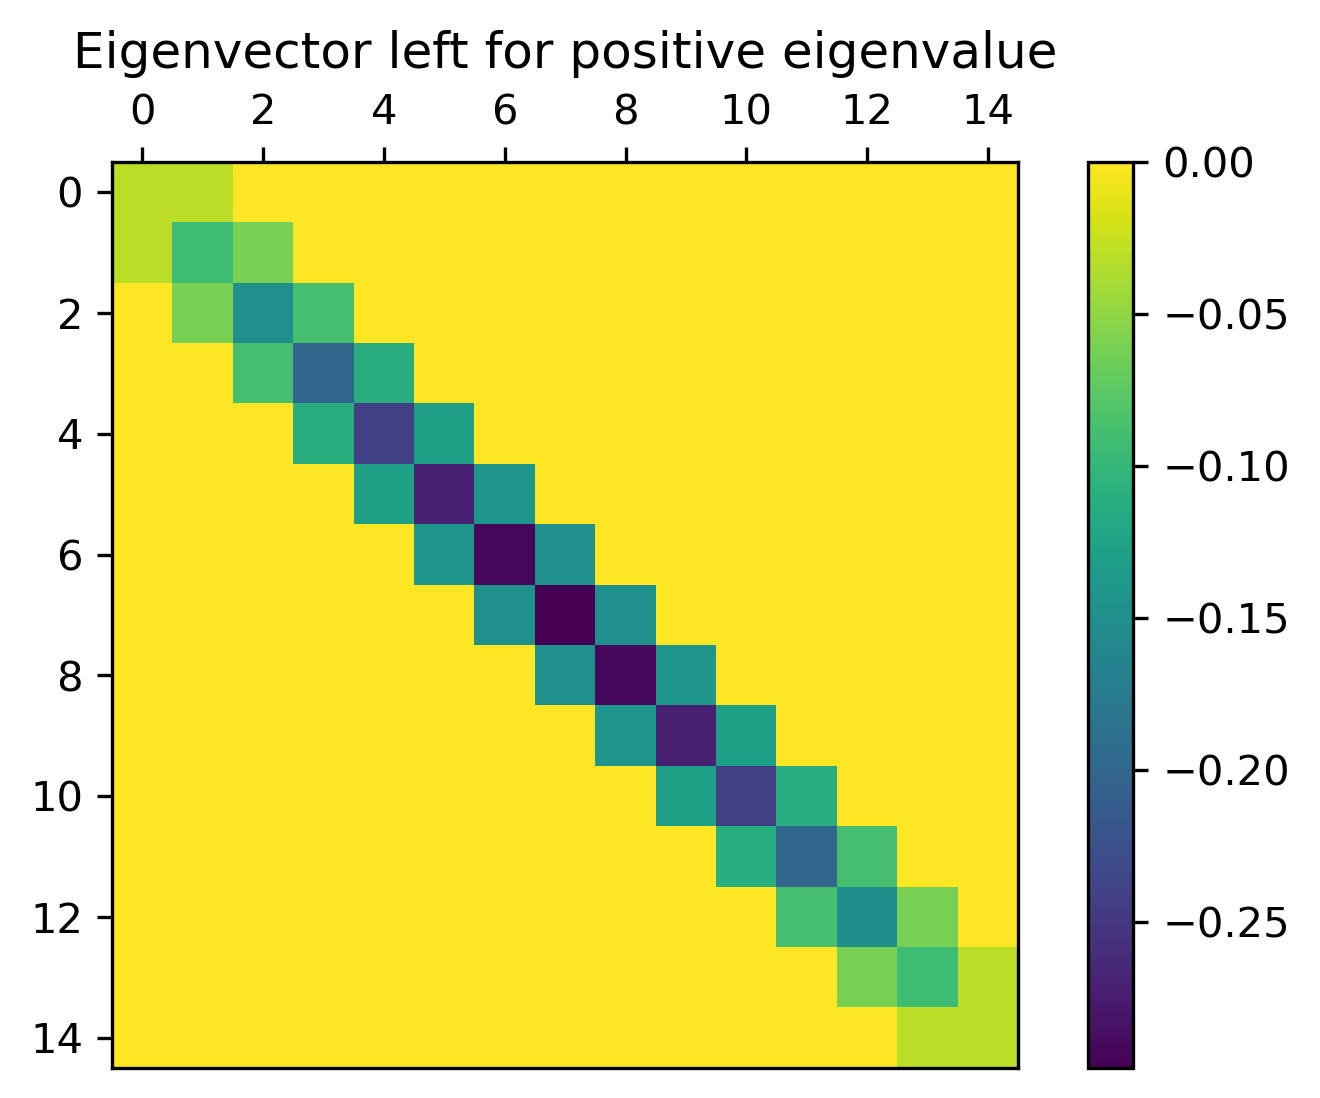

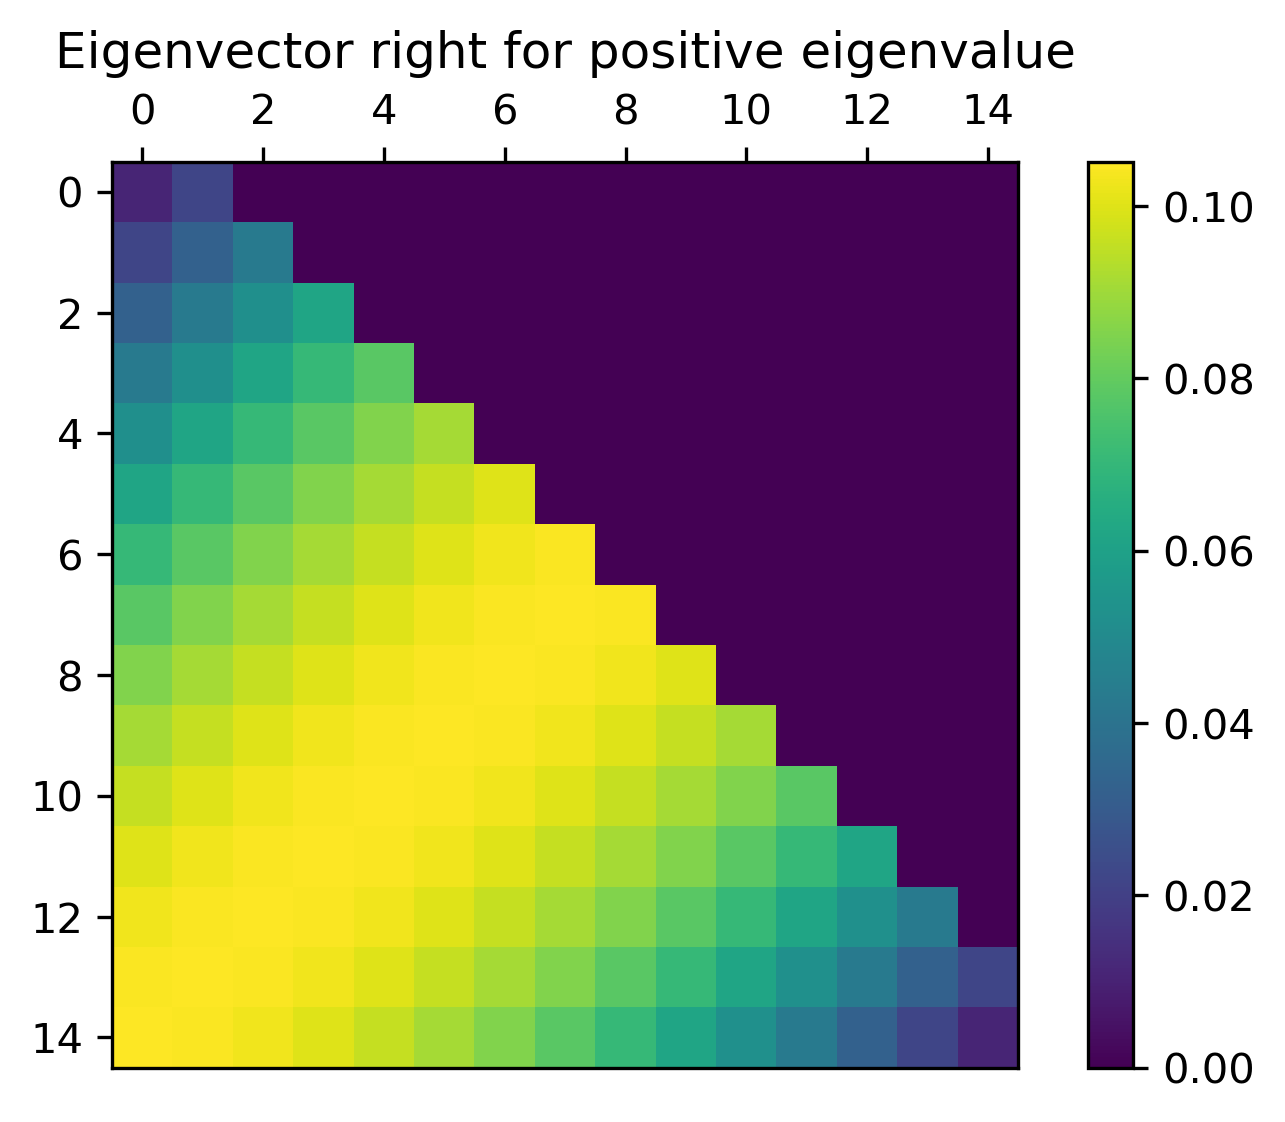

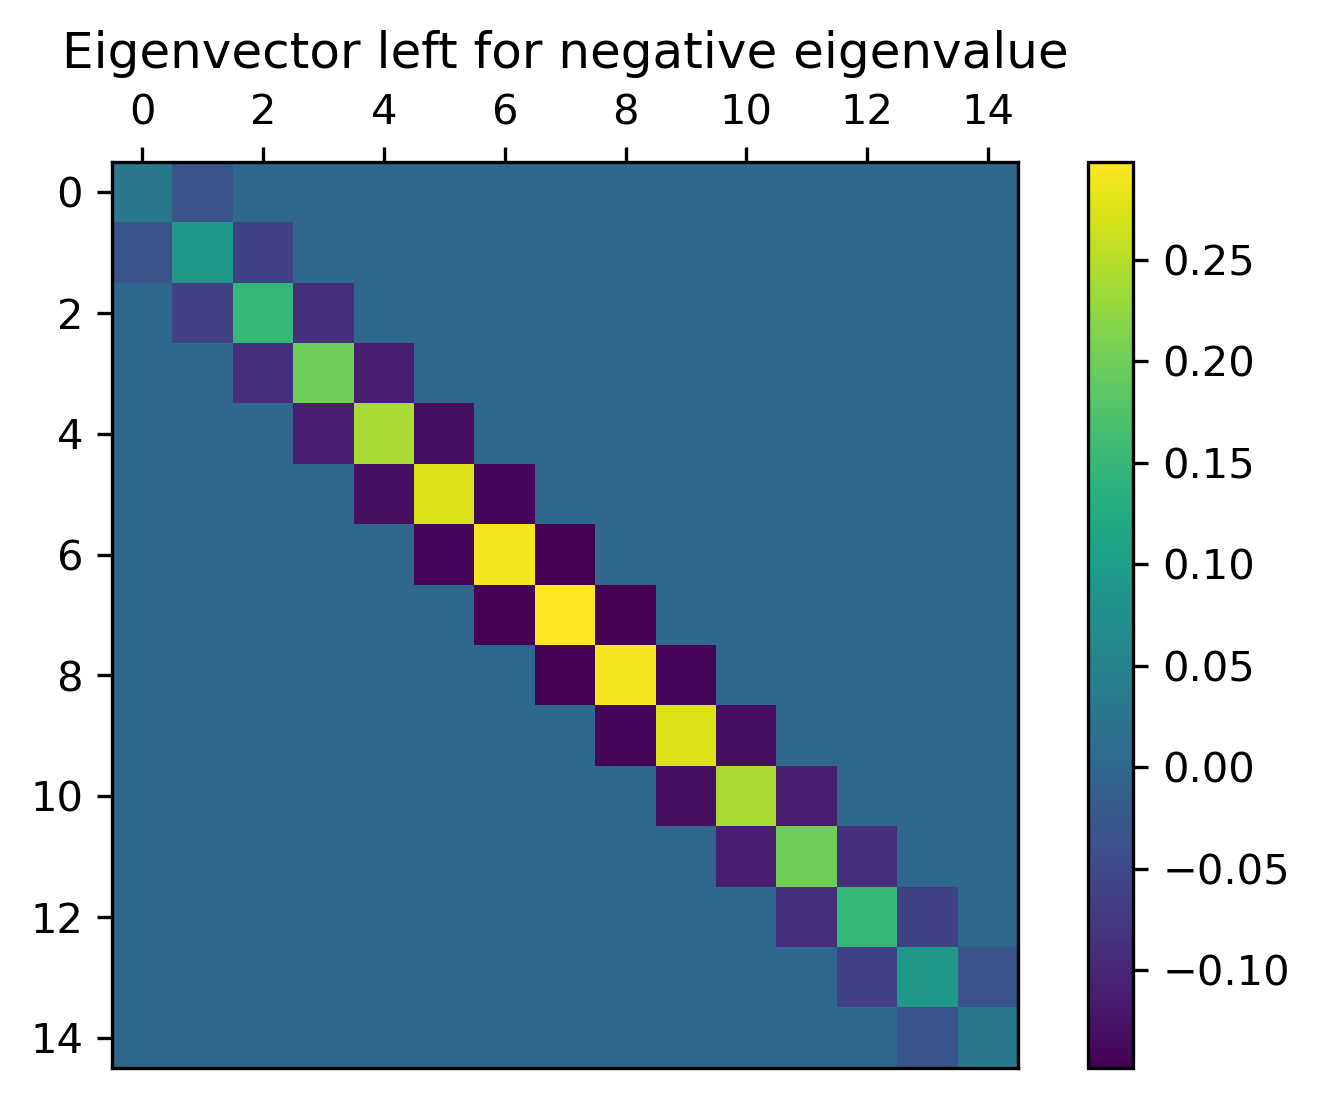

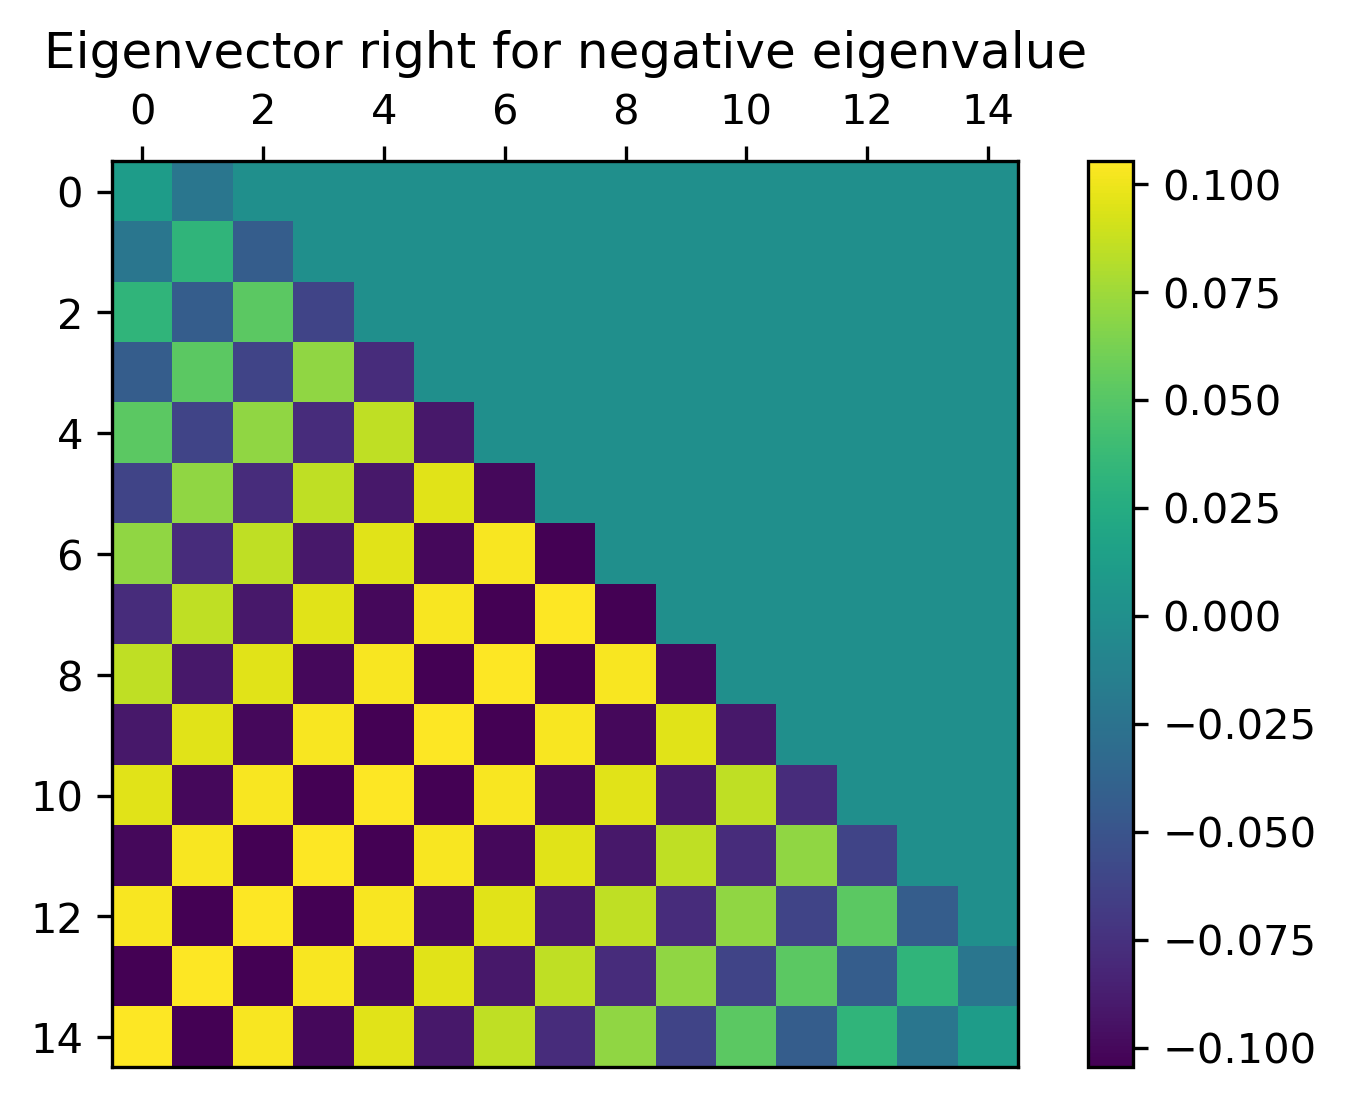

<Figure size 1800x1200 with 0 Axes>

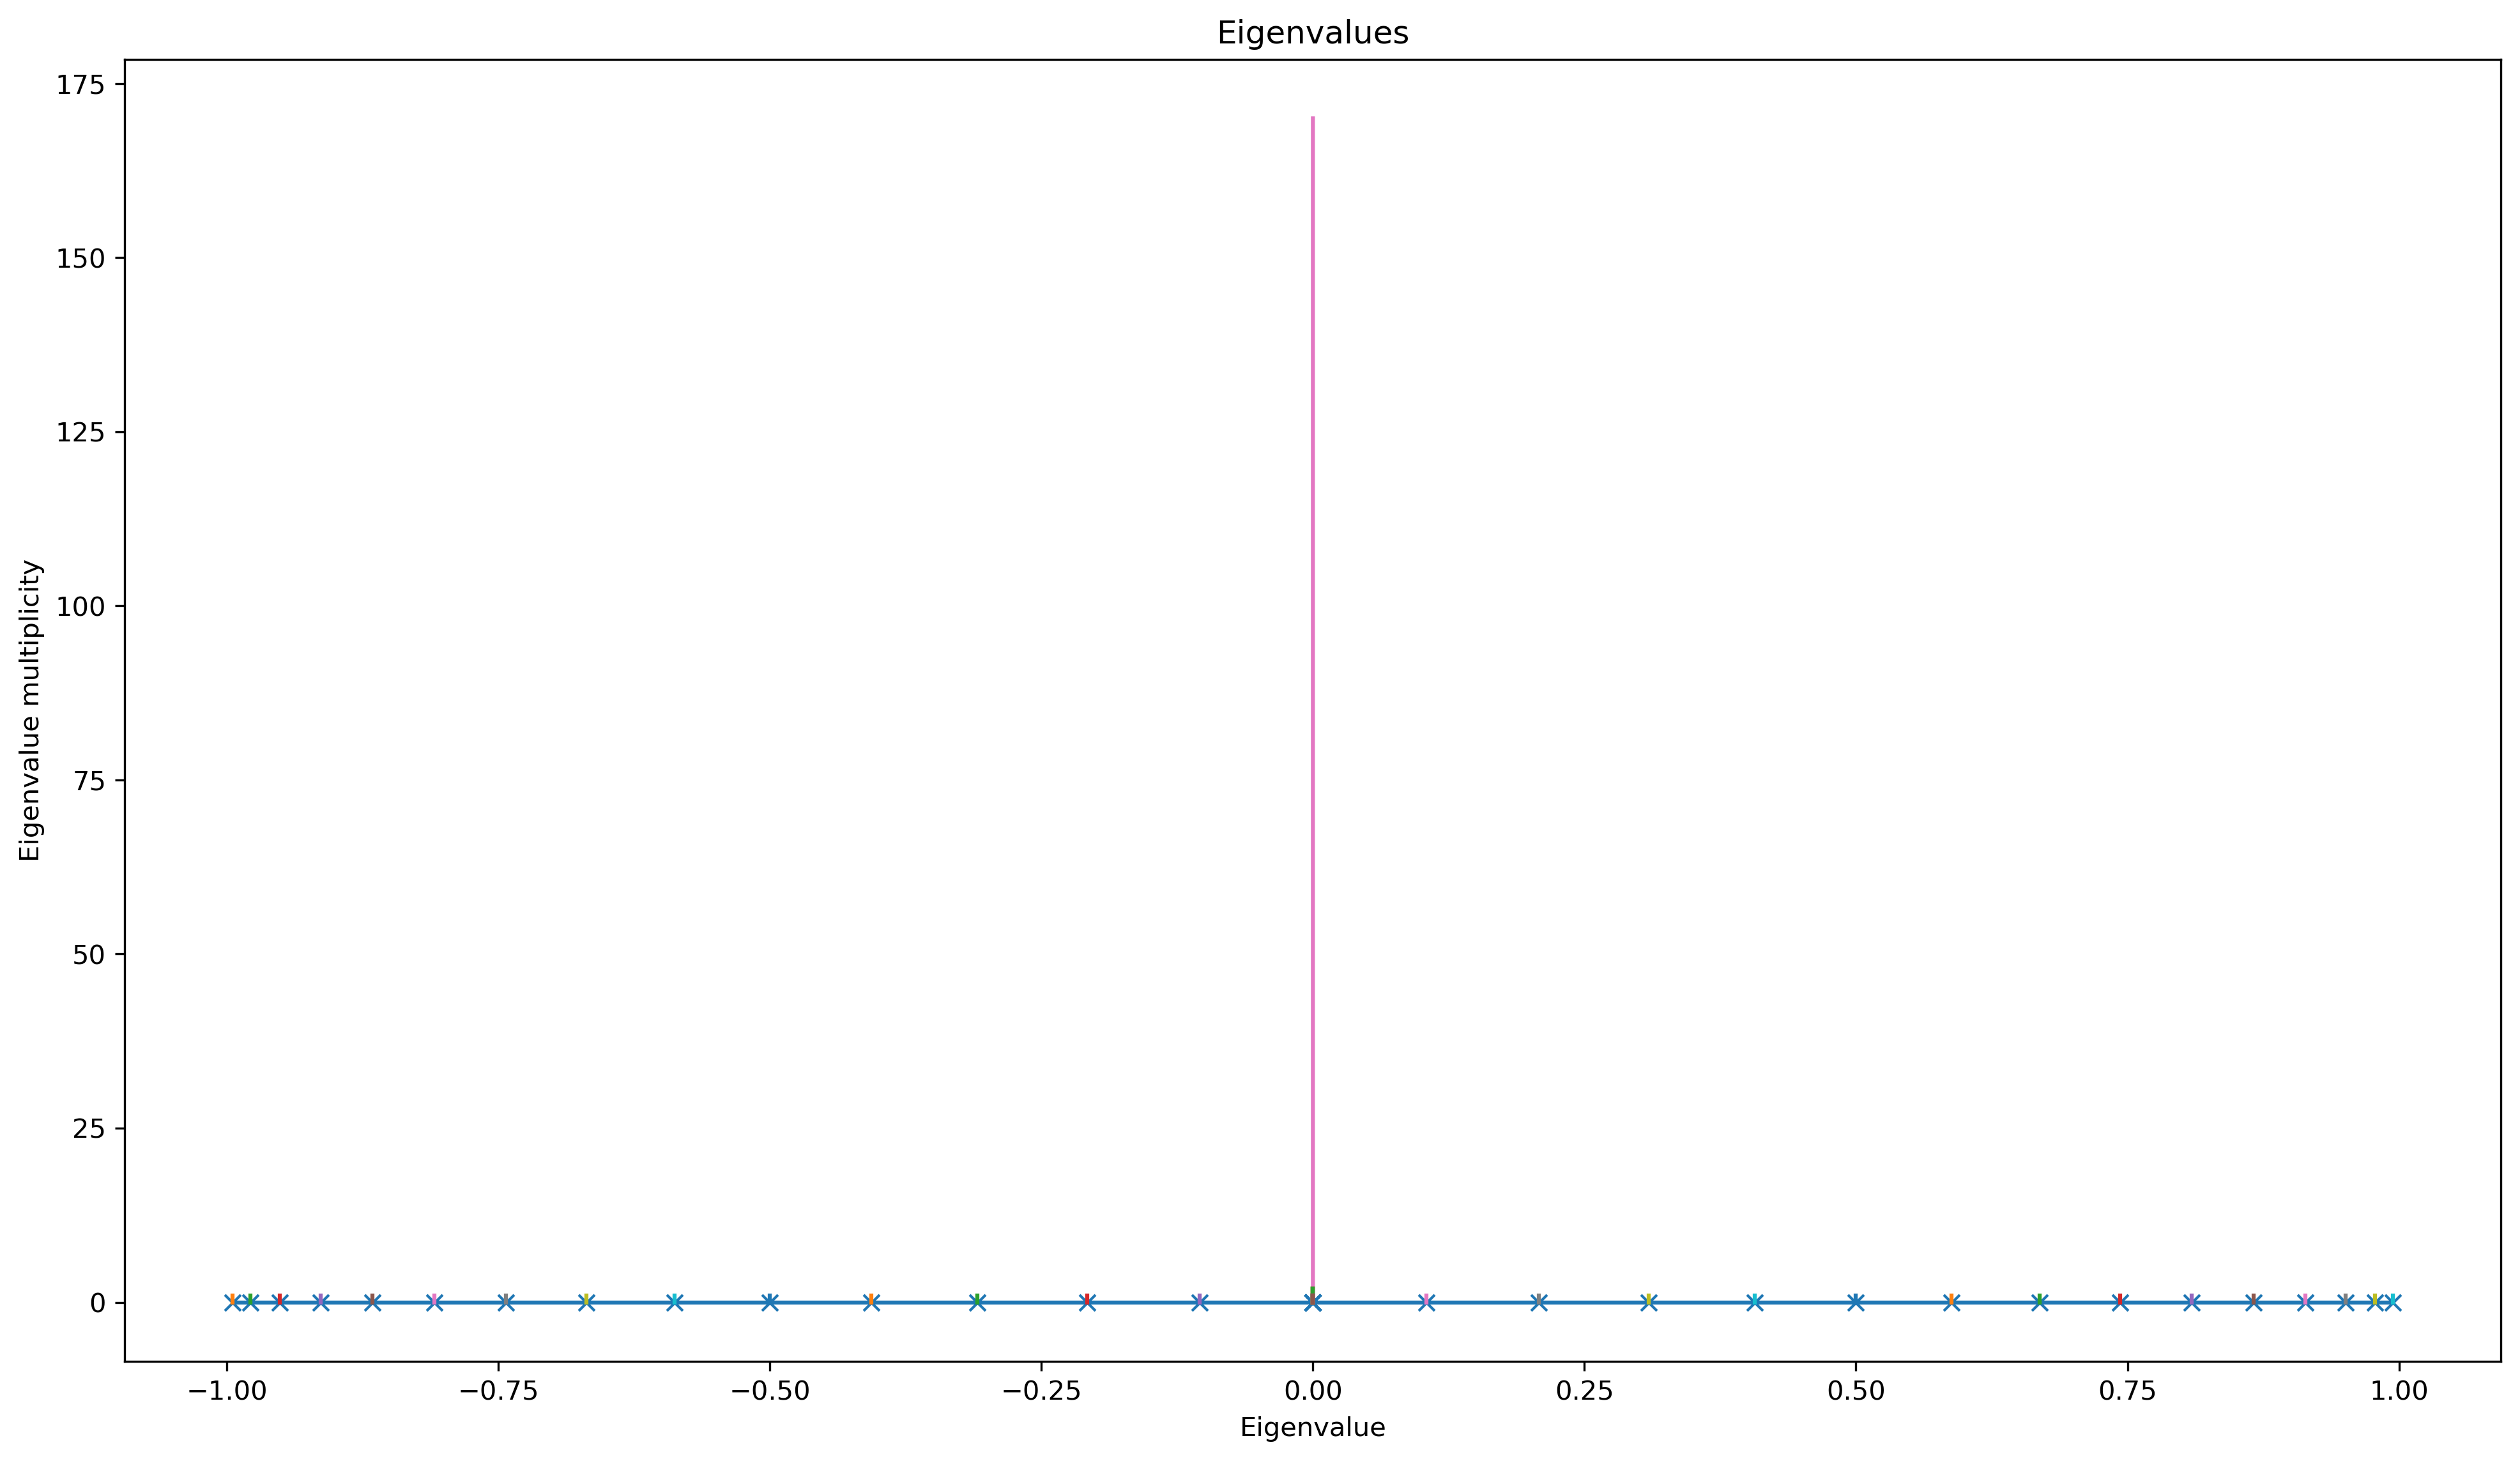

In [328]:
for qr in qrs:
    
    if qr == 'pve_border_optimal':
        continue
    make_directory(qr)
    matrix = qrs[qr]
    mx = remove_absorption_states(matrix, N)

    e_values, unique_evals, e_vec_l, e_vec_r, vl_pos, vr_pos, vl_neg, vr_neg = get_max_eigenvectors(mx)
    
    unique_evals, counts = visualise_eigenvalues(e_values, qr)
    
    # Visualise left eigenvector for max positive eigenvalue
    if (vl_pos is not None):
        visualise_eigenvector(vl_pos if (vl_pos[(N // 2) * N + (N // 2)] > 0) else -vl_pos, N - 1, qr, 'left for positive eigenvalue')
    else:
        continue
        
    # Visualise right eigenvector for max positive eigenvalue
    if (vr_pos is not None):
        visualise_eigenvector(vr_pos if (vr_pos[(N // 2) * N + (N // 2)] > 0) else -vr_pos, N - 1, qr, 'right for positive eigenvalue')
    else:
        continue
        
    # Visualise left eigenvector for min negative eigenvalue
    if (vl_neg is not None):
        visualise_eigenvector(vl_neg if (vl_neg[(N // 2) * N + (N // 2)] > 0) else -vl_neg, N - 1, qr, 'left for negative eigenvalue')
    else:
        continue
    
    # Visualise right eigenvector for min negative eigenvalue
    if (vr_neg is not None):
        visualise_eigenvector(vr_neg if (vr_neg[(N // 2) * N + (N // 2)] > 0) else -vr_neg, N - 1, qr, 'right for negative eigenvalue')
    else:
        continue
    visualise_qr(mx, qr)
    
    save_evalues(unique_evals, counts, qr, np.real(vl_pos), np.real(vr_pos), np.real(vl_neg), np.real(vr_neg))